# Pregunta de investigación

Para este trabajo se ha seleccionado la pregunta de investigación:

Skip Connections: Añadir skip connections a una red profunda generalmente mejora su desempeño en la tarea de interés.

Para refutar o demostrar la pregunta de investigación, se han utilizado tres datasets, donde 1 dataset es sintético y 2 datasets son reales. 


*   El dataset sintético corresponde al CIFAR10, que es ampliamente utilizado para probar nuevos métodos en redes neuronales, este se compone de 50k imágenes de entrenamiento y 10k de imágenes de test en 10 clases. [Link del dataset](https://keras.io/api/datasets/cifar10/)

*   El primer dataset real utilizado corresponde al Brain Tumor, se compone de imágenes de cerebros, para poder predecir si las personas poseen o no un tumor en el cerebro. [Link del dataset](https://www.kaggle.com/preetviradiya/brian-tumor-dataset)
*   El segundo dataser real utilizado corresponde al, se compone de imágenes de figuras geométricas simples, para poder identificar que tipo de figura se encuentra en cada imagen. [Link del dataset](https://www.kaggle.com/cactus3/basicshapes)

Este trabajo se ha basado en gran parte de lo realizado en el artículo “**Deep Residual Learning for Image Recognition**” en el 2015 de las personas Kaiming He, Xiangyu Zhang, Shaoqing Ren, y Jian Sun.

Toda la información utilizada en este trabajo se encontrará en el siguiente [link](https://usmcl-my.sharepoint.com/:f:/g/personal/philip_guerra_sansano_usm_cl/ElY-LWiBYg5JtkWWizrQqzQBaap8HPdlvYQviZzEV7DJ4Q?e=sUiA1u
)


# Dataset CIFAR10

## Procesamiento de datos

In [12]:
#
import pandas as pd
import numpy as np
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
#from sklearn.datasets import load_boston
import matplotlib.gridspec as gridspec


#Para trabajar sobre imagenes
import cv2
import random
import os
import matplotlib.image as mpimg
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split 
from sklearn.metrics import classification_report

#tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import MaxPooling2D, Dense, Dropout,Flatten, Conv2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import TensorBoard,EarlyStopping 

Shape X_train + X_val:  (50000, 32, 32, 3)
Shape X_test:  (10000, 32, 32, 3)


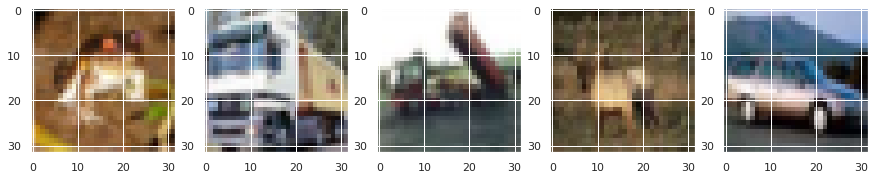

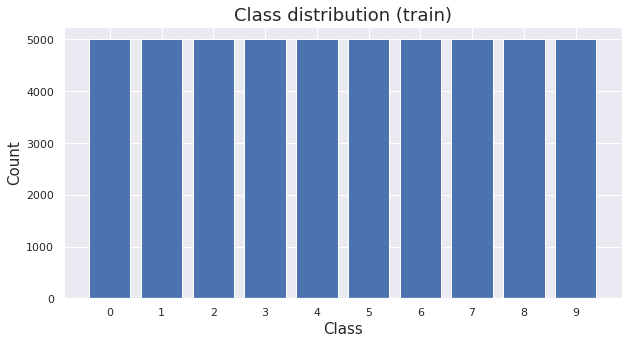

In [13]:

(X_train, y_train), (X_test, y_test) = keras.datasets.cifar10.load_data()

# assert X_train.shape == (50000, 32, 32, 3)
# assert X_test.shape == (10000, 32, 32, 3)
# assert y_train.shape == (50000, 1)
# assert y_test.shape == (10000, 1)

print("Shape X_train + X_val: ", X_train.shape)
print("Shape X_test: ", X_test.shape)

# Scale images to the [0, 1] range
X_train = X_train.astype("float32") / 255
X_test = X_test.astype("float32") / 255


# plot images
fig = plt.figure(figsize=(15, 5))

for i in range(5):    
    ax = fig.add_subplot(1, 5,i+1)
    plt.imshow(X_train[i])

# distribucion de ejemplos de entrenamiento

unique, counts = np.unique(y_train, return_counts=True)

fig = plt.figure(figsize=(10, 5))

y_pos = np.arange(len(unique))

# Create bars
plt.bar(y_pos, counts)

plt.xticks(y_pos, unique)

plt.xlabel("Class", fontsize=15)
plt.ylabel("Count", fontsize=15)
plt.title("Class distribution (train)", fontsize=18)
plt.show()


In [14]:
y_train

array([[6],
       [9],
       [9],
       ...,
       [9],
       [1],
       [1]], dtype=uint8)

0 : Airplane \\
1 : Automobile \\
2 : Bird \\
3 : Cat \\
4 : Deer \\
5 : Dog \\
6 : Frog \\
7 : Horse \\
8 : Ship \\
9 : Truck \\



In [15]:
#preparamos la data
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

X_train = X_train.reshape(X_train.shape[0], 32, 32, 3)  #aca el reshape
X_test = X_test.reshape(X_test.shape[0], 32, 32, 3)
X_val = X_val.reshape(X_val.shape[0], 32, 32, 3)

#para las etiquetas se usan one-hot
y_train = keras.utils.to_categorical(y_train)
y_val = keras.utils.to_categorical(y_val)
y_test = keras.utils.to_categorical(y_test)


# y_train = pd.get_dummies(y_train)
# y_val = pd.get_dummies(y_val)
# y_test = pd.get_dummies(y_test)

In [16]:
y_val

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 1., ..., 0., 0., 0.]], dtype=float32)

# Arquitecturas previas

Se plantean dos modelos de redes secuenciales que no poseen skip connections, a la primera se le denominará *sec_previo1* y la segunda se denominará *sec_previo2*. Son similares en profundidad, pero la *sec_previo2* se le agrego batch normalization (BN) después de cada capa convolucional y maxpooling, con el fin de poder apreciar la diferencia entre estas dos arquitecturas. Batch normalization es una técnica usada en Deep Learning que automáticamente estandariza los inputs de la capa. El efecto que presenta en la red neuronal es el de acelerar dramáticamente el proceso de entrenamiento. Es bastante usada en redes neuronales profundas ya que reduce el número de epochs necesarias para entrenar. Otra ventaja es que permite usar tazas de aprendizaje mucho más grandes, que ayuda en el problema de desvanecimiento de gradiente, que es otro problema que se puede presentar en redes muy profundas.

Luego, se plantean dos modelos de redes convolucionales con skip connections, a la primera se le denominará *skip_previo1* y la segunda se denominará *skip_previo2*. *skip_previo1* es una red similar a la *sec_previo1*, pero a esta se le agregan skip connection del tipo **zero-padding shorcuts** entre capas que poseen el mismo número de filtros, mientras que *skip_previo2* es similar a la red *skip_previo1*, pero a esta se le incluyen **projection shorcuts**, para unir capas de diferente número de filtros, por lo que sólo se utilizan dos veces en la red, esto se puede hacer mediante una capa convolucional uno a uno, que sirve para aumentar el número de filtros de la capa que está a menor profundidad.

En la siguiente imagen se aprecia como se realiza la skip connections del tipo **zero-padding shorcuts**, donde esta no agrega parámetros a la red.

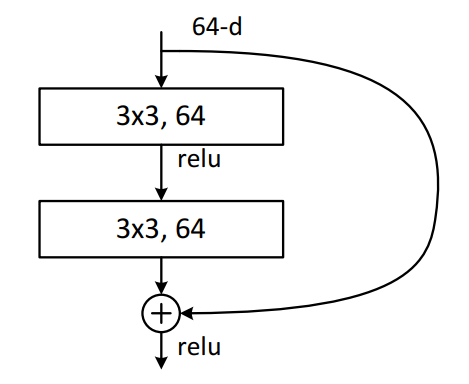

En la siguiente imagen se aprecia como se realiza la skip connections del tipo **projection shorcuts**, esta si agrega parámetros a la red, dado que se utiliza una capa convolucional uno a uno de intermediaria para igualar la dimensión asociada a el número de filtros.

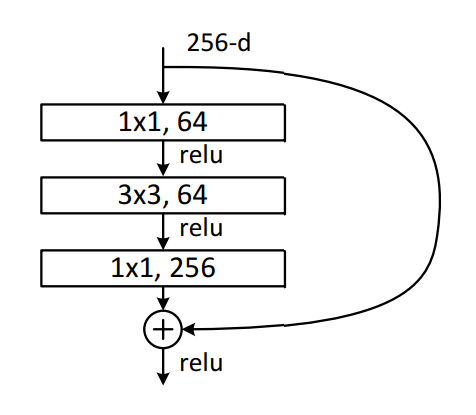

Model: "Brain_CNN"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
MyInput (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_200 (Conv2D)             (None, 32, 32, 16)   448         MyInput[0][0]                    
__________________________________________________________________________________________________
batch_normalization_174 (BatchN (None, 32, 32, 16)   64          conv2d_200[0][0]                 
__________________________________________________________________________________________________
conv2d_201 (Conv2D)             (None, 32, 32, 16)   2320        batch_normalization_174[0][0]    
__________________________________________________________________________________________

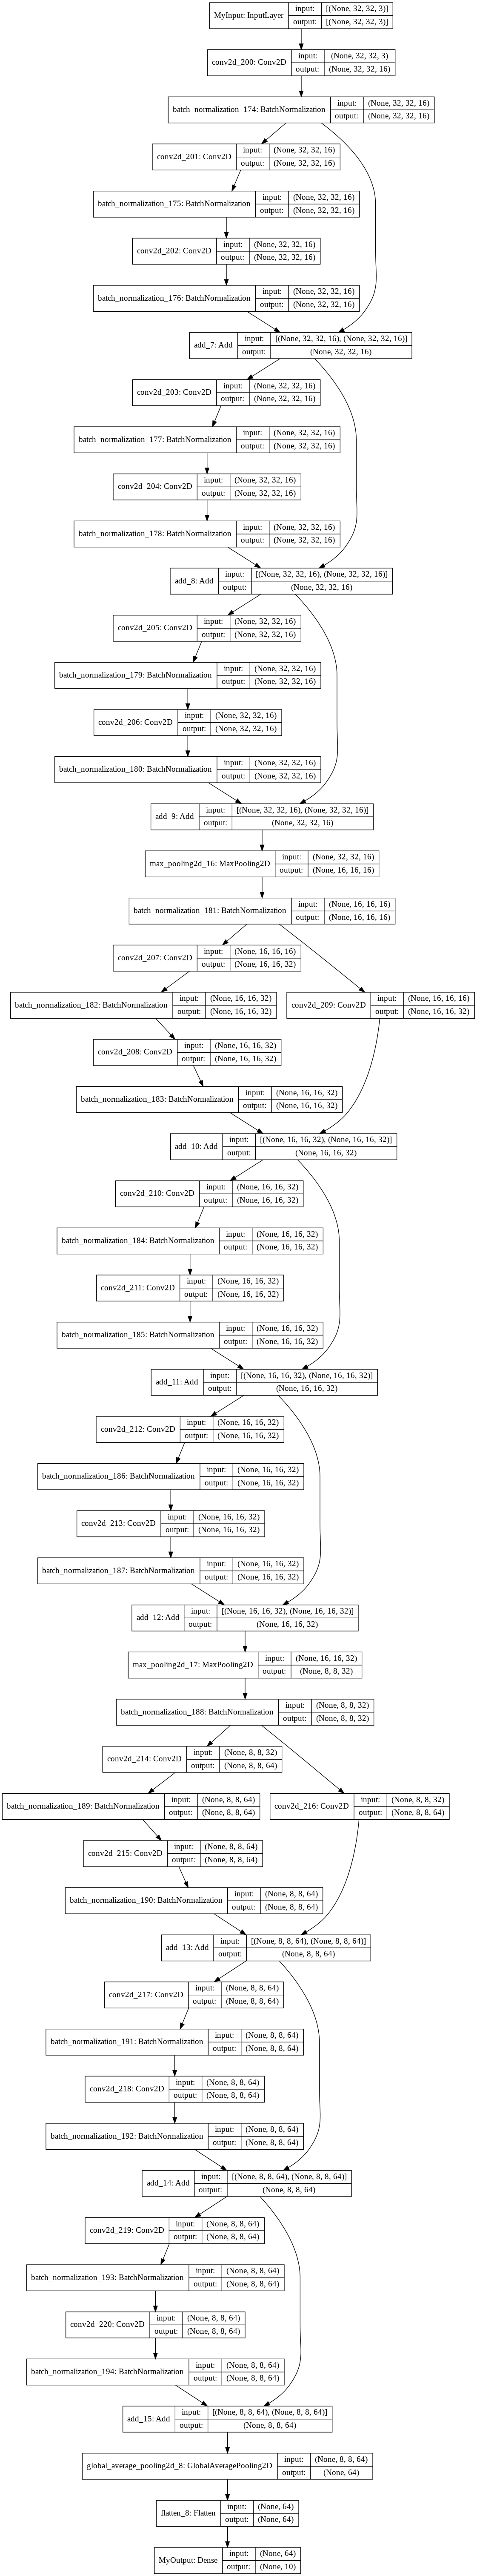

In [32]:
from keras.layers import merge

#Redes secuenciales

def get_model_CNN_sec_previo1(activation_func,seed=1234):
  
    tf.random.set_seed(seed)
    input = keras.Input(shape=(32,32,3,), name='MyInput')
    x0 = layers.Conv2D(filters = 16, kernel_size = 3, activation = activation_func, padding="same")(input) 
    x1 = layers.Conv2D(filters = 16, kernel_size = 3, activation = activation_func, padding="same")(x0)    
    x2 = layers.Conv2D(filters = 16, kernel_size = 3, activation = activation_func, padding="same")(x1)    
    x3 = layers.Conv2D(filters = 16, kernel_size = 3, activation = activation_func, padding="same")(x2)
    x4 = layers.Conv2D(filters = 16, kernel_size = 3, activation = activation_func, padding="same")(x3) 
    x5 = layers.Conv2D(filters = 16, kernel_size = 3, activation = activation_func, padding="same")(x4)
    x6 = layers.Conv2D(filters = 16, kernel_size = 3, activation = activation_func, padding="same")(x5)
    xp1 = layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid')(x6) 
    x7 = layers.Conv2D(filters = 32, kernel_size = 3, activation = activation_func, padding="same")(xp1)    
    x8 = layers.Conv2D(filters = 32, kernel_size = 3, activation = activation_func, padding="same")(x7)
    x9 = layers.Conv2D(filters = 32, kernel_size = 3, activation = activation_func, padding="same")(x8)
    x10 = layers.Conv2D(filters = 32, kernel_size = 3, activation = activation_func, padding="same")(x9)
    x11 = layers.Conv2D(filters = 32, kernel_size = 3, activation = activation_func, padding="same")(x10)
    x12 = layers.Conv2D(filters = 32, kernel_size = 3, activation = activation_func, padding="same")(x11)
    xp2 = layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid')(x12) 
    x13 = layers.Conv2D(filters = 64, kernel_size = 3, activation = activation_func, padding="same")(xp2)    
    x14 = layers.Conv2D(filters = 64, kernel_size = 3, activation = activation_func, padding="same")(x13)
    x15 = layers.Conv2D(filters = 64, kernel_size = 3, activation = activation_func, padding="same")(x14)
    x16 = layers.Conv2D(filters = 64, kernel_size = 3, activation = activation_func, padding="same")(x15)
    x17 = layers.Conv2D(filters = 64, kernel_size = 3, activation = activation_func, padding="same")(x16)
    x18 = layers.Conv2D(filters = 64, kernel_size = 3, activation = activation_func, padding="same")(x17)
    xp3 = layers.GlobalAveragePooling2D()(x18)
    xfl = layers.Flatten()(xp3)
    output = layers.Dense(10, activation='softmax', name='MyOutput')(xfl)
    model = keras.Model(inputs=input, outputs=output, name='Brain_CNN')

    return model

def get_model_CNN_sec_previo2(activation_func,seed=1234):#igual que sec1, pero con BN
  
    tf.random.set_seed(seed)
    input = keras.Input(shape=(32,32,3,), name='MyInput')
    x0 = layers.Conv2D(filters = 16, kernel_size = 3, activation = activation_func, padding="same")(input) 
    bn0 = layers.BatchNormalization()(x0)
    x1 = layers.Conv2D(filters = 16, kernel_size = 3, activation = activation_func, padding="same")(bn0)  
    bn1 = layers.BatchNormalization()(x1)  
    x2 = layers.Conv2D(filters = 16, kernel_size = 3, activation = activation_func, padding="same")(bn1)
    bn2 = layers.BatchNormalization()(x2)    
    x3 = layers.Conv2D(filters = 16, kernel_size = 3, activation = activation_func, padding="same")(bn2)
    bn3 = layers.BatchNormalization()(x3) 
    x4 = layers.Conv2D(filters = 16, kernel_size = 3, activation = activation_func, padding="same")(bn3)
    bn4 = layers.BatchNormalization()(x4)  
    x5 = layers.Conv2D(filters = 16, kernel_size = 3, activation = activation_func, padding="same")(bn4)
    bn5 = layers.BatchNormalization()(x5) 
    x6 = layers.Conv2D(filters = 16, kernel_size = 3, activation = activation_func, padding="same")(bn5)
    bn6 = layers.BatchNormalization()(x6) 
    xp1 = layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid')(bn6) 
    bnp1 = layers.BatchNormalization()(xp1) 
    x7 = layers.Conv2D(filters = 32, kernel_size = 3, activation = activation_func, padding="same")(bnp1) 
    bn7 = layers.BatchNormalization()(x7)    
    x8 = layers.Conv2D(filters = 32, kernel_size = 3, activation = activation_func, padding="same")(bn7)
    bn8 = layers.BatchNormalization()(x8)  
    x9 = layers.Conv2D(filters = 32, kernel_size = 3, activation = activation_func, padding="same")(bn8)
    bn9 = layers.BatchNormalization()(x9)  
    x10 = layers.Conv2D(filters = 32, kernel_size = 3, activation = activation_func, padding="same")(bn9)
    bn10 = layers.BatchNormalization()(x10)  
    x11 = layers.Conv2D(filters = 32, kernel_size = 3, activation = activation_func, padding="same")(bn10)
    bn11 = layers.BatchNormalization()(x11)  
    x12 = layers.Conv2D(filters = 32, kernel_size = 3, activation = activation_func, padding="same")(bn11)
    bn12 = layers.BatchNormalization()(x12)  
    xp2 = layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid')(bn12) 
    bnp2 = layers.BatchNormalization()(xp2) 
    x13 = layers.Conv2D(filters = 64, kernel_size = 3, activation = activation_func, padding="same")(bnp2) 
    bn13 = layers.BatchNormalization()(x13)     
    x14 = layers.Conv2D(filters = 64, kernel_size = 3, activation = activation_func, padding="same")(bn13)
    bn14 = layers.BatchNormalization()(x14)  
    x15 = layers.Conv2D(filters = 64, kernel_size = 3, activation = activation_func, padding="same")(bn14)
    bn15 = layers.BatchNormalization()(x15)  
    x16 = layers.Conv2D(filters = 64, kernel_size = 3, activation = activation_func, padding="same")(bn15)
    bn16 = layers.BatchNormalization()(x16)  
    x17 = layers.Conv2D(filters = 64, kernel_size = 3, activation = activation_func, padding="same")(bn16)
    bn17 = layers.BatchNormalization()(x17)  
    x18 = layers.Conv2D(filters = 64, kernel_size = 3, activation = activation_func, padding="same")(bn17)
    bn18 = layers.BatchNormalization()(x18)  
    xp3 = layers.GlobalAveragePooling2D()(bn18)
    xfl = layers.Flatten()(xp3)
    output = layers.Dense(10, activation='softmax', name='MyOutput')(xfl)
    model = keras.Model(inputs=input, outputs=output, name='Brain_CNN')

    return model

# With skip connections
def get_model_CNN_skip_previo1(activation_func,seed=1234): #with zero-padding shorcuts and batch normalization
  
    tf.random.set_seed(seed)
    input = keras.Input(shape=(32,32,3,), name='MyInput')
    x0 = layers.Conv2D(filters = 16, kernel_size = 3, activation = activation_func, padding="same")(input) 
    bn0 = layers.BatchNormalization()(x0)
    x1 = layers.Conv2D(filters = 16, kernel_size = 3, activation = activation_func, padding="same")(bn0)  
    bn1 = layers.BatchNormalization()(x1)  
    x2 = layers.Conv2D(filters = 16, kernel_size = 3, activation = activation_func, padding="same")(bn1)
    bn2 = layers.BatchNormalization()(x2) 
    block_1 = layers.add([bn0, bn2]) #zero-padding shorcut      
    x3 = layers.Conv2D(filters = 16, kernel_size = 3, activation = activation_func, padding="same")(block_1)
    bn3 = layers.BatchNormalization()(x3) 
    x4 = layers.Conv2D(filters = 16, kernel_size = 3, activation = activation_func, padding="same")(bn3)
    bn4 = layers.BatchNormalization()(x4) 
    block_2 = layers.add([block_1, bn4]) #zero-padding shorcut 
    x5 = layers.Conv2D(filters = 16, kernel_size = 3, activation = activation_func, padding="same")(block_2)
    bn5 = layers.BatchNormalization()(x5) 
    x6 = layers.Conv2D(filters = 16, kernel_size = 3, activation = activation_func, padding="same")(bn5)
    bn6 = layers.BatchNormalization()(x6) 
    block_3 = layers.add([block_2, bn6]) #zero-padding shorcut
    xp1 = layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid')(block_3) 
    bnp1 = layers.BatchNormalization()(xp1) 
    x7 = layers.Conv2D(filters = 32, kernel_size = 3, activation = activation_func, padding="same")(bnp1) 
    bn7 = layers.BatchNormalization()(x7)    
    x8 = layers.Conv2D(filters = 32, kernel_size = 3, activation = activation_func, padding="same")(bn7)
    bn8 = layers.BatchNormalization()(x8)  
    x9 = layers.Conv2D(filters = 32, kernel_size = 3, activation = activation_func, padding="same")(bn8)
    bn9 = layers.BatchNormalization()(x9)  
    x10 = layers.Conv2D(filters = 32, kernel_size = 3, activation = activation_func, padding="same")(bn9)
    bn10 = layers.BatchNormalization()(x10)  
    block_4 = layers.add([bn8, bn10]) #zero-padding shorcut
    x11 = layers.Conv2D(filters = 32, kernel_size = 3, activation = activation_func, padding="same")(block_4)
    bn11 = layers.BatchNormalization()(x11)  
    x12 = layers.Conv2D(filters = 32, kernel_size = 3, activation = activation_func, padding="same")(bn11)
    bn12 = layers.BatchNormalization()(x12)  
    block_5 = layers.add([block_4, bn12]) #zero-padding shorcut
    xp2 = layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid')(block_5) 
    bnp2 = layers.BatchNormalization()(xp2) 
    x13 = layers.Conv2D(filters = 64, kernel_size = 3, activation = activation_func, padding="same")(bnp2) 
    bn13 = layers.BatchNormalization()(x13)     
    x14 = layers.Conv2D(filters = 64, kernel_size = 3, activation = activation_func, padding="same")(bn13)
    bn14 = layers.BatchNormalization()(x14)  
    x15 = layers.Conv2D(filters = 64, kernel_size = 3, activation = activation_func, padding="same")(bn14)
    bn15 = layers.BatchNormalization()(x15)  
    x16 = layers.Conv2D(filters = 64, kernel_size = 3, activation = activation_func, padding="same")(bn15)
    bn16 = layers.BatchNormalization()(x16)  
    block_6 = layers.add([bn14, bn16]) #zero-padding shorcut
    x17 = layers.Conv2D(filters = 64, kernel_size = 3, activation = activation_func, padding="same")(block_6)
    bn17 = layers.BatchNormalization()(x17)  
    x18 = layers.Conv2D(filters = 64, kernel_size = 3, activation = activation_func, padding="same")(bn17)
    bn18 = layers.BatchNormalization()(x18)  
    block_7 = layers.add([block_6, bn18]) #zero-padding shorcut
    xp3 = layers.GlobalAveragePooling2D()(block_7)
    xfl = layers.Flatten()(xp3)
    output = layers.Dense(10, activation='softmax', name='MyOutput')(xfl)
    model = keras.Model(inputs=input, outputs=output, name='Brain_CNN')

    return model

def get_model_CNN_skip_previo2(activation_func,seed=1234): #with zero-padding shorcuts and projection shorctus, and batch normalization
  
    tf.random.set_seed(seed)
    input = keras.Input(shape=(32,32,3,), name='MyInput')
    x0 = layers.Conv2D(filters = 16, kernel_size = 3, activation = activation_func, padding="same")(input) 
    bn0 = layers.BatchNormalization()(x0)
    x1 = layers.Conv2D(filters = 16, kernel_size = 3, activation = activation_func, padding="same")(bn0)  
    bn1 = layers.BatchNormalization()(x1)  
    x2 = layers.Conv2D(filters = 16, kernel_size = 3, activation = activation_func, padding="same")(bn1)
    bn2 = layers.BatchNormalization()(x2) 
    block_1 = layers.add([bn0, bn2]) #zero-padding shorcut   
    x3 = layers.Conv2D(filters = 16, kernel_size = 3, activation = activation_func, padding="same")(block_1)
    bn3 = layers.BatchNormalization()(x3) 
    x4 = layers.Conv2D(filters = 16, kernel_size = 3, activation = activation_func, padding="same")(bn3)
    bn4 = layers.BatchNormalization()(x4) 
    block_2 = layers.add([block_1, bn4]) #zero-padding shorcut
    x5 = layers.Conv2D(filters = 16, kernel_size = 3, activation = activation_func, padding="same")(block_2)
    bn5 = layers.BatchNormalization()(x5) 
    x6 = layers.Conv2D(filters = 16, kernel_size = 3, activation = activation_func, padding="same")(bn5)
    bn6 = layers.BatchNormalization()(x6) 
    block_3 = layers.add([block_2, bn6]) #zero-padding shorcut 
    xp1 = layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid')(block_3) 
    bnp1 = layers.BatchNormalization()(xp1) 
    x7 = layers.Conv2D(filters = 32, kernel_size = 3, activation = activation_func, padding="same")(bnp1) 
    bn7 = layers.BatchNormalization()(x7)    
    x8 = layers.Conv2D(filters = 32, kernel_size = 3, activation = activation_func, padding="same")(bn7)
    bn8 = layers.BatchNormalization()(x8)  
    x1x1_1 = layers.Conv2D(filters = 32, kernel_size = 1, activation = activation_func)(bnp1)   
    block_ps1 = layers.add([x1x1_1, bn8]) #projection shorcut
    x9 = layers.Conv2D(filters = 32, kernel_size = 3, activation = activation_func, padding="same")(block_ps1)
    bn9 = layers.BatchNormalization()(x9)  
    x10 = layers.Conv2D(filters = 32, kernel_size = 3, activation = activation_func, padding="same")(bn9)
    bn10 = layers.BatchNormalization()(x10)  
    block_4 = layers.add([block_ps1, bn10]) #zero-padding shorcut
    x11 = layers.Conv2D(filters = 32, kernel_size = 3, activation = activation_func, padding="same")(block_4)
    bn11 = layers.BatchNormalization()(x11)  
    x12 = layers.Conv2D(filters = 32, kernel_size = 3, activation = activation_func, padding="same")(bn11)
    bn12 = layers.BatchNormalization()(x12)  
    block_5 = layers.add([block_4, bn12]) #zero-padding shorcut
    xp2 = layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid')(block_5) 
    bnp2 = layers.BatchNormalization()(xp2) 
    x13 = layers.Conv2D(filters = 64, kernel_size = 3, activation = activation_func, padding="same")(bnp2) 
    bn13 = layers.BatchNormalization()(x13)     
    x14 = layers.Conv2D(filters = 64, kernel_size = 3, activation = activation_func, padding="same")(bn13)
    bn14 = layers.BatchNormalization()(x14)  
    x1x1_2 = layers.Conv2D(filters = 64, kernel_size = 1, activation = activation_func)(bnp2)   
    block_ps2 = layers.add([x1x1_2, bn14]) #projection shorcut
    x15 = layers.Conv2D(filters = 64, kernel_size = 3, activation = activation_func, padding="same")(block_ps2)
    bn15 = layers.BatchNormalization()(x15)  
    x16 = layers.Conv2D(filters = 64, kernel_size = 3, activation = activation_func, padding="same")(bn15)
    bn16 = layers.BatchNormalization()(x16)  
    block_6 = layers.add([block_ps2, bn16]) #zero-padding shorcut
    x17 = layers.Conv2D(filters = 64, kernel_size = 3, activation = activation_func, padding="same")(block_6)
    bn17 = layers.BatchNormalization()(x17)  
    x18 = layers.Conv2D(filters = 64, kernel_size = 3, activation = activation_func, padding="same")(bn17)
    bn18 = layers.BatchNormalization()(x18)  
    block_7 = layers.add([block_6, bn18]) #zero-padding shorcut
    xp3 = layers.GlobalAveragePooling2D()(block_7)
    xfl = layers.Flatten()(xp3)
    output = layers.Dense(10, activation='softmax', name='MyOutput')(xfl)
    model = keras.Model(inputs=input, outputs=output, name='Brain_CNN')

    return model

model2 = get_model_CNN_skip_previo2('relu')

model2.summary()

keras.utils.plot_model(model2, show_shapes=True)

## Resultados previos

### CNN sec_previo1

Total params: 269,034

Trainable params: 269,034

Non-trainable params: 0

Epoch 1/20
1250/1250 [==============================] - 13s 9ms/step - loss: 2.3028 - accuracy: 0.0992 - val_loss: 2.3030 - val_accuracy: 0.0967
Epoch 2/20
1250/1250 [==============================] - 11s 9ms/step - loss: 2.3028 - accuracy: 0.0995 - val_loss: 2.3029 - val_accuracy: 0.0967
Epoch 3/20
1250/1250 [==============================] - 11s 9ms/step - loss: 2.3027 - accuracy: 0.0988 - val_loss: 2.3027 - val_accuracy: 0.0967
Epoch 4/20
1250/1250 [==============================] - 11s 9ms/step - loss: 2.3028 - accuracy: 0.0973 - val_loss: 2.3027 - val_accuracy: 0.1004
Epoch 5/20
1250/1250 [==============================] - 11s 9ms/step - loss: 2.3028 - accuracy: 0.0980 - val_loss: 2.3028 - val_accuracy: 0.0953
Epoch 6/20
1250/1250 [==============================] - 11s 9ms/step - loss: 2.3027 - accuracy: 0.0988 - val_loss: 2.3029 - val_accuracy: 0.0967
Epoch 7/20
1250/1250 [==============================] - 11s 9ms/step - loss: 2.3028 - accuracy: 0.0982 - val_loss: 2.3028 - val_ac

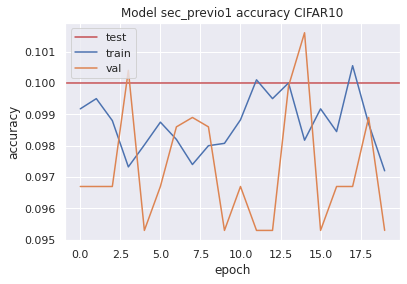

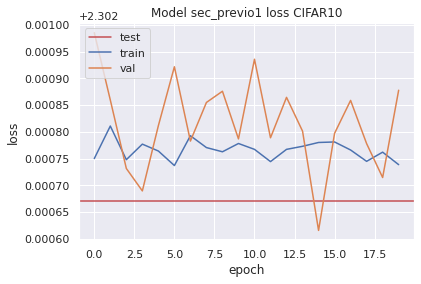

In [ ]:
# CNN sec_previo1
_batch_size = 32

model2.compile( loss='categorical_crossentropy', optimizer = keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])

# Entrenar modelo
history = model2.fit(
    x = X_train,
    y = y_train,
    batch_size=_batch_size,
    epochs=20,
    verbose=1,

    validation_data=(X_val, y_val),
)

sec_previo1_train_accu = history.history['accuracy']
sec_previo1_val_accu = history.history['val_accuracy']
sec_previo1_train_loss = history.history['loss']
sec_previo1_val_loss = history.history['val_loss']

Test = model2.evaluate(X_test,y_test)
plt.axhline(Test[1],label='test',color='r')
plt.plot(sec_previo1_train_accu,label='train')
plt.plot(sec_previo1_val_accu,label='val')
plt.title('Model sec_previo1 accuracy CIFAR10')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.show()

plt.axhline(Test[0],label='test',color='r')
plt.plot(sec_previo1_train_loss,label='train')
plt.plot(sec_previo1_val_loss,label='val')
plt.title('Model sec_previo1 loss CIFAR10')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.show()

### CNN sec_previo2

Total params: 271,978

Trainable params: 270,506

Non-trainable params: 1,472

Epoch 1/20
1250/1250 [==============================] - 17s 12ms/step - loss: 1.5385 - accuracy: 0.4276 - val_loss: 1.4029 - val_accuracy: 0.5077
Epoch 2/20
1250/1250 [==============================] - 15s 12ms/step - loss: 1.1330 - accuracy: 0.5929 - val_loss: 1.1464 - val_accuracy: 0.6037
Epoch 3/20
1250/1250 [==============================] - 14s 12ms/step - loss: 0.9320 - accuracy: 0.6700 - val_loss: 0.9715 - val_accuracy: 0.6697
Epoch 4/20
1250/1250 [==============================] - 14s 12ms/step - loss: 0.8087 - accuracy: 0.7186 - val_loss: 0.8454 - val_accuracy: 0.7087
Epoch 5/20
1250/1250 [==============================] - 14s 12ms/step - loss: 0.7300 - accuracy: 0.7491 - val_loss: 0.8129 - val_accuracy: 0.7290
Epoch 6/20
1250/1250 [==============================] - 15s 12ms/step - loss: 0.6546 - accuracy: 0.7743 - val_loss: 0.7379 - val_accuracy: 0.7506
Epoch 7/20
1250/1250 [==============================] - 14s 12ms/step - loss: 0.6004 - accuracy: 0.7919 - val_loss: 0.7106 -

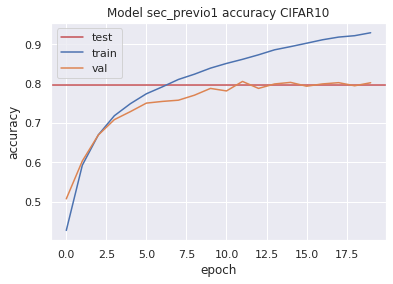

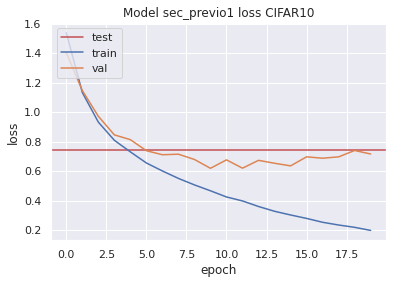

In [18]:
# CNN sec_previo2
_batch_size = 32

model2.compile( loss='categorical_crossentropy', optimizer = keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])

# Entrenar modelo
history = model2.fit(
    x = X_train,
    y = y_train,
    batch_size=_batch_size,
    epochs=20,
    verbose=1,

    validation_data=(X_val, y_val),
)

sec_previo2_train_accu = history.history['accuracy']
sec_previo2_val_accu = history.history['val_accuracy']
sec_previo2_train_loss = history.history['loss']
sec_previo2_val_loss = history.history['val_loss']

Test = model2.evaluate(X_test,y_test)
plt.axhline(Test[1],label='test',color='r')
plt.plot(sec_previo2_train_accu,label='train')
plt.plot(sec_previo2_val_accu,label='val')
plt.title('Model sec_previo1 accuracy CIFAR10')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.show()

plt.axhline(Test[0],label='test',color='r')
plt.plot(sec_previo2_train_loss,label='train')
plt.plot(sec_previo2_val_loss,label='val')
plt.title('Model sec_previo1 loss CIFAR10')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.show()

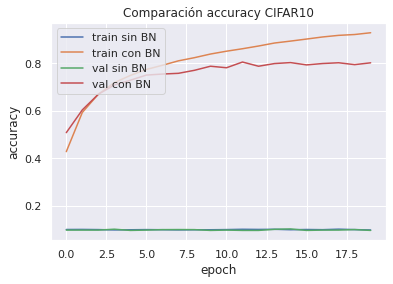

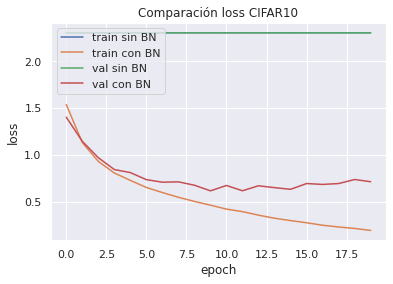

In [23]:


plt.plot(sec_previo1_train_accu,label='train sin BN')
plt.plot(sec_previo2_train_accu,label='train con BN')
plt.plot(sec_previo1_val_accu,label='val sin BN')
plt.plot(sec_previo2_val_accu,label='val con BN')
plt.title('Comparación accuracy CIFAR10')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.show()


plt.plot(sec_previo1_train_loss,label='train sin BN')
plt.plot(sec_previo2_train_loss,label='train con BN')
plt.plot(sec_previo1_val_loss,label='val sin BN')
plt.plot(sec_previo2_val_loss,label='val con BN')
plt.title('Comparación loss CIFAR10')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.show()

En base al gráfico presentado arriba, se observa claramente que la red secuencial sin skip connections prácticamente no se entrena a diferencia de cuando se incluye batch normalization, por lo que de aquí en adelante todas los modelos de redes se consideraran con batch normalization (BN).

### CNN skip_previo1
 
Total params: 271,978

Trainable params: 270,506

Non-trainable params: 1,472

Epoch 1/20
1250/1250 [==============================] - 18s 12ms/step - loss: 1.3409 - accuracy: 0.5158 - val_loss: 1.1248 - val_accuracy: 0.5966
Epoch 2/20
1250/1250 [==============================] - 15s 12ms/step - loss: 0.9332 - accuracy: 0.6704 - val_loss: 0.8939 - val_accuracy: 0.6903
Epoch 3/20
1250/1250 [==============================] - 15s 12ms/step - loss: 0.7668 - accuracy: 0.7316 - val_loss: 0.7688 - val_accuracy: 0.7374
Epoch 4/20
1250/1250 [==============================] - 15s 12ms/step - loss: 0.6601 - accuracy: 0.7709 - val_loss: 0.6608 - val_accuracy: 0.7714
Epoch 5/20
1250/1250 [==============================] - 15s 12ms/step - loss: 0.5811 - accuracy: 0.7990 - val_loss: 0.6571 - val_accuracy: 0.7758
Epoch 6/20
1250/1250 [==============================] - 15s 12ms/step - loss: 0.5160 - accuracy: 0.8219 - val_loss: 0.6677 - val_accuracy: 0.7743
Epoch 7/20
1250/1250 [==============================] - 15s 12ms/step - loss: 0.4568 - accuracy: 0.8418 - val_loss: 0.5766 -

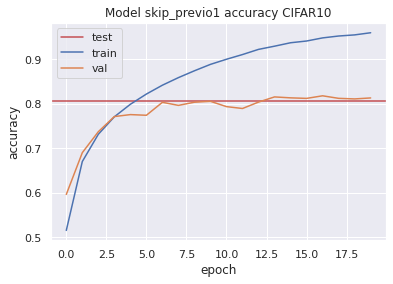

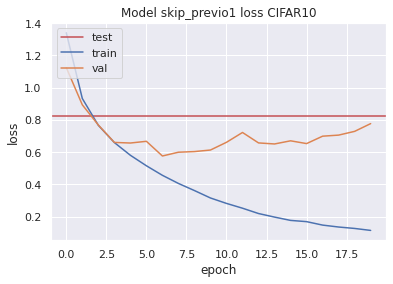

In [31]:
# CNN skip_previo1
_batch_size = 32

model2.compile( loss='categorical_crossentropy', optimizer = keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])

# Entrenar modelo
history = model2.fit(
    x = X_train,
    y = y_train,
    batch_size=_batch_size,
    epochs=20,
    verbose=1,

    validation_data=(X_val, y_val),
)

skip_previo1_train_accu = history.history['accuracy']
skip_previo1_val_accu = history.history['val_accuracy']
skip_previo1_train_loss = history.history['loss']
skip_previo1_val_loss = history.history['val_loss']

Test = model2.evaluate(X_test,y_test)
plt.axhline(Test[1],label='test',color='r')
plt.plot(skip_previo1_train_accu,label='train')
plt.plot(skip_previo1_val_accu,label='val')
plt.title('Model skip_previo1 accuracy CIFAR10')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.show()

plt.axhline(Test[0],label='test',color='r')
plt.plot(skip_previo1_train_loss,label='train')
plt.plot(skip_previo1_val_loss,label='val')
plt.title('Model skip_previo1 loss CIFAR10')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.show()

### CNN skip_previo2

Total params: 274,634

Trainable params: 273,162

Non-trainable params: 1,472

Epoch 1/20
1250/1250 [==============================] - 18s 13ms/step - loss: 1.3163 - accuracy: 0.5233 - val_loss: 1.0518 - val_accuracy: 0.6305
Epoch 2/20
1250/1250 [==============================] - 15s 12ms/step - loss: 0.9088 - accuracy: 0.6795 - val_loss: 0.8776 - val_accuracy: 0.6898
Epoch 3/20
1250/1250 [==============================] - 15s 12ms/step - loss: 0.7433 - accuracy: 0.7401 - val_loss: 0.7947 - val_accuracy: 0.7280
Epoch 4/20
1250/1250 [==============================] - 15s 12ms/step - loss: 0.6317 - accuracy: 0.7798 - val_loss: 0.6726 - val_accuracy: 0.7666
Epoch 5/20
1250/1250 [==============================] - 16s 12ms/step - loss: 0.5421 - accuracy: 0.8126 - val_loss: 0.6699 - val_accuracy: 0.7683
Epoch 6/20
1250/1250 [==============================] - 15s 12ms/step - loss: 0.4754 - accuracy: 0.8340 - val_loss: 0.6313 - val_accuracy: 0.7856
Epoch 7/20
1250/1250 [==============================] - 15s 12ms/step - loss: 0.4151 - accuracy: 0.8540 - val_loss: 0.5922 -

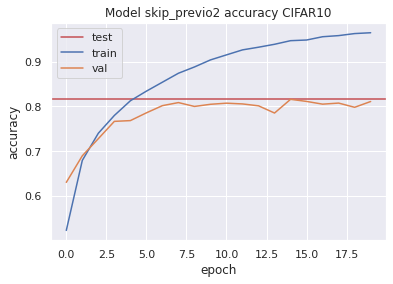

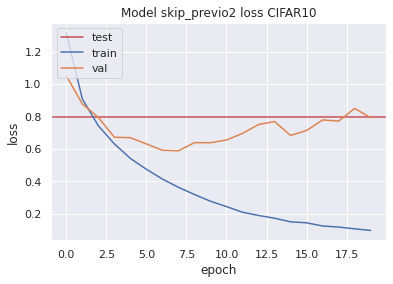

In [33]:
# CNN skip_previo2
_batch_size = 32

model2.compile( loss='categorical_crossentropy', optimizer = keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])

# Entrenar modelo
history = model2.fit(
    x = X_train,
    y = y_train,
    batch_size=_batch_size,
    epochs=20,
    verbose=1,

    validation_data=(X_val, y_val),
)

skip_previo2_train_accu = history.history['accuracy']
skip_previo2_val_accu = history.history['val_accuracy']
skip_previo2_train_loss = history.history['loss']
skip_previo2_val_loss = history.history['val_loss']

Test = model2.evaluate(X_test,y_test)
plt.axhline(Test[1],label='test',color='r')
plt.plot(skip_previo2_train_accu,label='train')
plt.plot(skip_previo2_val_accu,label='val')
plt.title('Model skip_previo2 accuracy CIFAR10')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.show()

plt.axhline(Test[0],label='test',color='r')
plt.plot(skip_previo2_train_loss,label='train')
plt.plot(skip_previo2_val_loss,label='val')
plt.title('Model skip_previo2 loss CIFAR10')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.show()

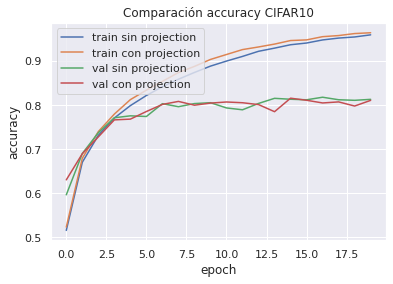

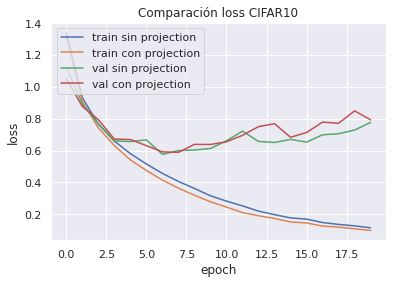

In [39]:
plt.plot(skip_previo1_train_accu,label='train sin projection')
plt.plot(skip_previo2_train_accu,label='train con projection')
plt.plot(skip_previo1_val_accu,label='val sin projection')
plt.plot(skip_previo2_val_accu,label='val con projection')
plt.title('Comparación accuracy CIFAR10')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.show()


plt.plot(skip_previo1_train_loss,label='train sin projection')
plt.plot(skip_previo2_train_loss,label='train con projection')
plt.plot(skip_previo1_val_loss,label='val sin projection')
plt.plot(skip_previo2_val_loss,label='val con projection')
plt.title('Comparación loss CIFAR10')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.show()

De acuerdo a la gráfica, se observa una leve diferencia entre las arquitecturas con skip connections cuando se incluyen **projection shorcuts**, donde mejora el entrenamiento, es por ello que de aquí en adelante las arquitecturas con skip connections incluiran **zero-padding shorcuts** y **projection shorcuts**.

# Arquitecturas finales

Las arquitecturas a utilizar serán 3 sin skip connections y 3 con skip connections, donde se va aumentando la profundidad de estás para poder demostrar que la utilización de skip connections mitiga el efecto de la degradación (la precisión del entrenamiento) que se plantea en el artículo nombrada en un principio, cabe recalcar que el problema de desvanecimiento de gradiente es mitigado gracias a la utilización de batch normalization.

Model: "Brain_CNN"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
MyInput (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_359 (Conv2D)             (None, 32, 32, 16)   448         MyInput[0][0]                    
__________________________________________________________________________________________________
batch_normalization_333 (BatchN (None, 32, 32, 16)   64          conv2d_359[0][0]                 
__________________________________________________________________________________________________
conv2d_360 (Conv2D)             (None, 32, 32, 16)   2320        batch_normalization_333[0][0]    
__________________________________________________________________________________________

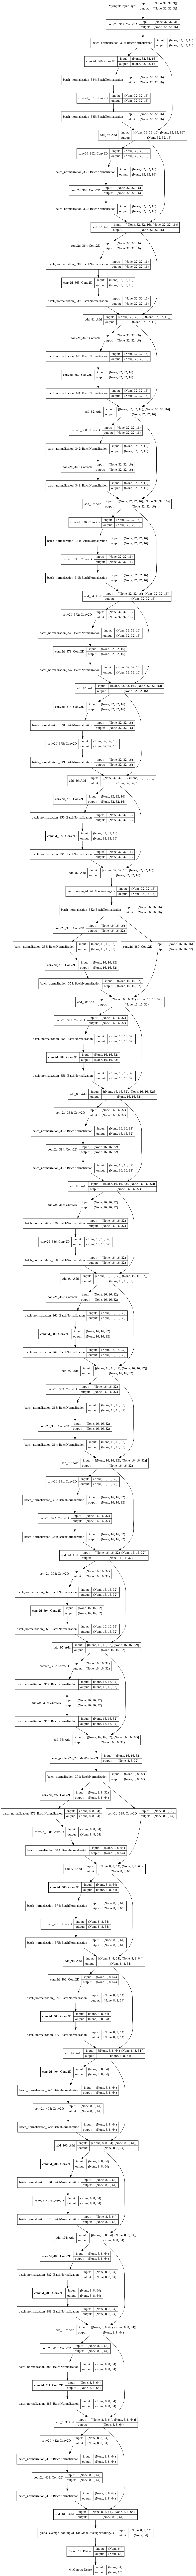

In [41]:
#modelos finales
from keras.layers import merge
# Without skip connections but with batch normalization

def get_model_CNN_sec1(activation_func,seed=1234):
  
    tf.random.set_seed(seed)
    input = keras.Input(shape=(32,32,3,), name='MyInput')
    x0 = layers.Conv2D(filters = 16, kernel_size = 3, activation = activation_func, padding="same")(input) 
    bn0 = layers.BatchNormalization()(x0)
    x1 = layers.Conv2D(filters = 16, kernel_size = 3, activation = activation_func, padding="same")(bn0)  
    bn1 = layers.BatchNormalization()(x1)  
    x2 = layers.Conv2D(filters = 16, kernel_size = 3, activation = activation_func, padding="same")(bn1)
    bn2 = layers.BatchNormalization()(x2)    
    x3 = layers.Conv2D(filters = 16, kernel_size = 3, activation = activation_func, padding="same")(bn2)
    bn3 = layers.BatchNormalization()(x3) 
    x4 = layers.Conv2D(filters = 16, kernel_size = 3, activation = activation_func, padding="same")(bn3)
    bn4 = layers.BatchNormalization()(x4)  
    x5 = layers.Conv2D(filters = 16, kernel_size = 3, activation = activation_func, padding="same")(bn4)
    bn5 = layers.BatchNormalization()(x5) 
    x6 = layers.Conv2D(filters = 16, kernel_size = 3, activation = activation_func, padding="same")(bn5)
    bn6 = layers.BatchNormalization()(x6) 
    xp1 = layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid')(bn6) 
    bnp1 = layers.BatchNormalization()(xp1) 
    x7 = layers.Conv2D(filters = 32, kernel_size = 3, activation = activation_func, padding="same")(bnp1) 
    bn7 = layers.BatchNormalization()(x7)    
    x8 = layers.Conv2D(filters = 32, kernel_size = 3, activation = activation_func, padding="same")(bn7)
    bn8 = layers.BatchNormalization()(x8)  
    x9 = layers.Conv2D(filters = 32, kernel_size = 3, activation = activation_func, padding="same")(bn8)
    bn9 = layers.BatchNormalization()(x9)  
    x10 = layers.Conv2D(filters = 32, kernel_size = 3, activation = activation_func, padding="same")(bn9)
    bn10 = layers.BatchNormalization()(x10)  
    x11 = layers.Conv2D(filters = 32, kernel_size = 3, activation = activation_func, padding="same")(bn10)
    bn11 = layers.BatchNormalization()(x11)  
    x12 = layers.Conv2D(filters = 32, kernel_size = 3, activation = activation_func, padding="same")(bn11)
    bn12 = layers.BatchNormalization()(x12)  
    xp2 = layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid')(bn12) 
    bnp2 = layers.BatchNormalization()(xp2) 
    x13 = layers.Conv2D(filters = 64, kernel_size = 3, activation = activation_func, padding="same")(bnp2) 
    bn13 = layers.BatchNormalization()(x13)     
    x14 = layers.Conv2D(filters = 64, kernel_size = 3, activation = activation_func, padding="same")(bn13)
    bn14 = layers.BatchNormalization()(x14)  
    x15 = layers.Conv2D(filters = 64, kernel_size = 3, activation = activation_func, padding="same")(bn14)
    bn15 = layers.BatchNormalization()(x15)  
    x16 = layers.Conv2D(filters = 64, kernel_size = 3, activation = activation_func, padding="same")(bn15)
    bn16 = layers.BatchNormalization()(x16)  
    x17 = layers.Conv2D(filters = 64, kernel_size = 3, activation = activation_func, padding="same")(bn16)
    bn17 = layers.BatchNormalization()(x17)  
    x18 = layers.Conv2D(filters = 64, kernel_size = 3, activation = activation_func, padding="same")(bn17)
    bn18 = layers.BatchNormalization()(x18)  
    xp3 = layers.GlobalAveragePooling2D()(bn18)
    xfl = layers.Flatten()(xp3)
    output = layers.Dense(10, activation='softmax', name='MyOutput')(xfl)
    model = keras.Model(inputs=input, outputs=output, name='Brain_CNN')

    return model

def get_model_CNN_sec2(activation_func,seed=1234):#igual que sec2, pero con más profundidad
  
    tf.random.set_seed(seed)
    input = keras.Input(shape=(32,32,3,), name='MyInput')
    x0 = layers.Conv2D(filters = 16, kernel_size = 3, activation = activation_func, padding="same")(input) 
    bn0 = layers.BatchNormalization()(x0)
    x1 = layers.Conv2D(filters = 16, kernel_size = 3, activation = activation_func, padding="same")(bn0)  
    bn1 = layers.BatchNormalization()(x1)  
    x2 = layers.Conv2D(filters = 16, kernel_size = 3, activation = activation_func, padding="same")(bn1)
    bn2 = layers.BatchNormalization()(x2)    
    x3 = layers.Conv2D(filters = 16, kernel_size = 3, activation = activation_func, padding="same")(bn2)
    bn3 = layers.BatchNormalization()(x3) 
    x4 = layers.Conv2D(filters = 16, kernel_size = 3, activation = activation_func, padding="same")(bn3)
    bn4 = layers.BatchNormalization()(x4)  
    x5 = layers.Conv2D(filters = 16, kernel_size = 3, activation = activation_func, padding="same")(bn4)
    bn5 = layers.BatchNormalization()(x5) 
    x6 = layers.Conv2D(filters = 16, kernel_size = 3, activation = activation_func, padding="same")(bn5)
    bn6 = layers.BatchNormalization()(x6) 
    x7 = layers.Conv2D(filters = 16, kernel_size = 3, activation = activation_func, padding="same")(bn6)
    bn7 = layers.BatchNormalization()(x7) 
    x8 = layers.Conv2D(filters = 16, kernel_size = 3, activation = activation_func, padding="same")(bn7)
    bn8 = layers.BatchNormalization()(x8)  
    x9 = layers.Conv2D(filters = 16, kernel_size = 3, activation = activation_func, padding="same")(bn8)
    bn9 = layers.BatchNormalization()(x9) 
    x10 = layers.Conv2D(filters = 16, kernel_size = 3, activation = activation_func, padding="same")(bn9)
    bn10 = layers.BatchNormalization()(x10) 
    xp1 = layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid')(bn10) 
    bnp1 = layers.BatchNormalization()(xp1) 
    x11 = layers.Conv2D(filters = 32, kernel_size = 3, activation = activation_func, padding="same")(bnp1) 
    bn11 = layers.BatchNormalization()(x11)    
    x12 = layers.Conv2D(filters = 32, kernel_size = 3, activation = activation_func, padding="same")(bn11)
    bn12 = layers.BatchNormalization()(x12)  
    x13 = layers.Conv2D(filters = 32, kernel_size = 3, activation = activation_func, padding="same")(bn12)
    bn13 = layers.BatchNormalization()(x13)  
    x14 = layers.Conv2D(filters = 32, kernel_size = 3, activation = activation_func, padding="same")(bn13)
    bn14 = layers.BatchNormalization()(x14)  
    x15 = layers.Conv2D(filters = 32, kernel_size = 3, activation = activation_func, padding="same")(bn14)
    bn15 = layers.BatchNormalization()(x15)  
    x16 = layers.Conv2D(filters = 32, kernel_size = 3, activation = activation_func, padding="same")(bn15)
    bn16 = layers.BatchNormalization()(x16)  
    x17 = layers.Conv2D(filters = 32, kernel_size = 3, activation = activation_func, padding="same")(bn16)
    bn17 = layers.BatchNormalization()(x17)  
    x18 = layers.Conv2D(filters = 32, kernel_size = 3, activation = activation_func, padding="same")(bn17)
    bn18 = layers.BatchNormalization()(x18)  
    x19 = layers.Conv2D(filters = 32, kernel_size = 3, activation = activation_func, padding="same")(bn18)
    bn19 = layers.BatchNormalization()(x19)  
    x20 = layers.Conv2D(filters = 32, kernel_size = 3, activation = activation_func, padding="same")(bn19)
    bn20 = layers.BatchNormalization()(x20)  
    xp2 = layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid')(bn20) 
    bnp2 = layers.BatchNormalization()(xp2) 
    x21 = layers.Conv2D(filters = 64, kernel_size = 3, activation = activation_func, padding="same")(bnp2) 
    bn21 = layers.BatchNormalization()(x21)     
    x22 = layers.Conv2D(filters = 64, kernel_size = 3, activation = activation_func, padding="same")(bn21)
    bn22 = layers.BatchNormalization()(x22)  
    x23 = layers.Conv2D(filters = 64, kernel_size = 3, activation = activation_func, padding="same")(bn22)
    bn23 = layers.BatchNormalization()(x23)  
    x24 = layers.Conv2D(filters = 64, kernel_size = 3, activation = activation_func, padding="same")(bn23)
    bn24 = layers.BatchNormalization()(x24)  
    x25 = layers.Conv2D(filters = 64, kernel_size = 3, activation = activation_func, padding="same")(bn24)
    bn25 = layers.BatchNormalization()(x25)  
    x26 = layers.Conv2D(filters = 64, kernel_size = 3, activation = activation_func, padding="same")(bn25)
    bn26 = layers.BatchNormalization()(x26)  
    x27 = layers.Conv2D(filters = 64, kernel_size = 3, activation = activation_func, padding="same")(bn26)
    bn27 = layers.BatchNormalization()(x27)  
    x28 = layers.Conv2D(filters = 64, kernel_size = 3, activation = activation_func, padding="same")(bn27)
    bn28 = layers.BatchNormalization()(x28)  
    x29 = layers.Conv2D(filters = 64, kernel_size = 3, activation = activation_func, padding="same")(bn28)
    bn29 = layers.BatchNormalization()(x29)  
    x30 = layers.Conv2D(filters = 64, kernel_size = 3, activation = activation_func, padding="same")(bn29)
    bn30 = layers.BatchNormalization()(x30) 
    xp3 = layers.GlobalAveragePooling2D()(bn30)
    xfl = layers.Flatten()(xp3)
    output = layers.Dense(10, activation='softmax', name='MyOutput')(xfl)
    model = keras.Model(inputs=input, outputs=output, name='Brain_CNN')

    return model

def get_model_CNN_sec3(activation_func,seed=1234):#igual que sec3, pero con más profundidad
  
    tf.random.set_seed(seed)
    input = keras.Input(shape=(32,32,3,), name='MyInput')
    x0 = layers.Conv2D(filters = 16, kernel_size = 3, activation = activation_func, padding="same")(input) 
    bn = layers.BatchNormalization()(x0)
    x  = layers.Conv2D(filters = 16, kernel_size = 3, activation = activation_func, padding="same")(bn)  
    bn = layers.BatchNormalization()(x)  
    x  = layers.Conv2D(filters = 16, kernel_size = 3, activation = activation_func, padding="same")(bn)  
    bn = layers.BatchNormalization()(x) 
    x  = layers.Conv2D(filters = 16, kernel_size = 3, activation = activation_func, padding="same")(bn)  
    bn = layers.BatchNormalization()(x) 
    x  = layers.Conv2D(filters = 16, kernel_size = 3, activation = activation_func, padding="same")(bn)  
    bn = layers.BatchNormalization()(x) 
    x  = layers.Conv2D(filters = 16, kernel_size = 3, activation = activation_func, padding="same")(bn)  
    bn = layers.BatchNormalization()(x) 
    x  = layers.Conv2D(filters = 16, kernel_size = 3, activation = activation_func, padding="same")(bn)  
    bn = layers.BatchNormalization()(x) 
    x  = layers.Conv2D(filters = 16, kernel_size = 3, activation = activation_func, padding="same")(bn)  
    bn = layers.BatchNormalization()(x) 
    x  = layers.Conv2D(filters = 16, kernel_size = 3, activation = activation_func, padding="same")(bn)  
    bn = layers.BatchNormalization()(x) 
    x  = layers.Conv2D(filters = 16, kernel_size = 3, activation = activation_func, padding="same")(bn)  
    bn = layers.BatchNormalization()(x) 
    x  = layers.Conv2D(filters = 16, kernel_size = 3, activation = activation_func, padding="same")(bn)  
    bn = layers.BatchNormalization()(x) 
    x  = layers.Conv2D(filters = 16, kernel_size = 3, activation = activation_func, padding="same")(bn)  
    bn = layers.BatchNormalization()(x) 
    x  = layers.Conv2D(filters = 16, kernel_size = 3, activation = activation_func, padding="same")(bn)  
    bn = layers.BatchNormalization()(x) 
    x  = layers.Conv2D(filters = 16, kernel_size = 3, activation = activation_func, padding="same")(bn)  
    bn = layers.BatchNormalization()(x) 
    x  = layers.Conv2D(filters = 16, kernel_size = 3, activation = activation_func, padding="same")(bn)  
    bn = layers.BatchNormalization()(x) 
    x  = layers.Conv2D(filters = 16, kernel_size = 3, activation = activation_func, padding="same")(bn)  
    bn = layers.BatchNormalization()(x) 
    x  = layers.Conv2D(filters = 16, kernel_size = 3, activation = activation_func, padding="same")(bn)  
    bn = layers.BatchNormalization()(x) 
    x  = layers.Conv2D(filters = 16, kernel_size = 3, activation = activation_func, padding="same")(bn)  
    bn = layers.BatchNormalization()(x) 
    x  = layers.Conv2D(filters = 16, kernel_size = 3, activation = activation_func, padding="same")(bn)  
    bn = layers.BatchNormalization()(x)
    xp1 = layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid')(bn) 
    bnp1 = layers.BatchNormalization()(xp1)
    x  = layers.Conv2D(filters = 32, kernel_size = 3, activation = activation_func, padding="same")(bnp1)  
    bn = layers.BatchNormalization()(x)  
    x  = layers.Conv2D(filters = 32, kernel_size = 3, activation = activation_func, padding="same")(bn)  
    bn = layers.BatchNormalization()(x) 
    x  = layers.Conv2D(filters = 32, kernel_size = 3, activation = activation_func, padding="same")(bn)  
    bn = layers.BatchNormalization()(x) 
    x  = layers.Conv2D(filters = 32, kernel_size = 3, activation = activation_func, padding="same")(bn)  
    bn = layers.BatchNormalization()(x) 
    x  = layers.Conv2D(filters = 32, kernel_size = 3, activation = activation_func, padding="same")(bn)  
    bn = layers.BatchNormalization()(x) 
    x  = layers.Conv2D(filters = 32, kernel_size = 3, activation = activation_func, padding="same")(bn)  
    bn = layers.BatchNormalization()(x) 
    x  = layers.Conv2D(filters = 32, kernel_size = 3, activation = activation_func, padding="same")(bn)  
    bn = layers.BatchNormalization()(x) 
    x  = layers.Conv2D(filters = 32, kernel_size = 3, activation = activation_func, padding="same")(bn)  
    bn = layers.BatchNormalization()(x) 
    x  = layers.Conv2D(filters = 32, kernel_size = 3, activation = activation_func, padding="same")(bn)  
    bn = layers.BatchNormalization()(x) 
    x  = layers.Conv2D(filters = 32, kernel_size = 3, activation = activation_func, padding="same")(bn)  
    bn = layers.BatchNormalization()(x) 
    x  = layers.Conv2D(filters = 32, kernel_size = 3, activation = activation_func, padding="same")(bn)  
    bn = layers.BatchNormalization()(x) 
    x  = layers.Conv2D(filters = 32, kernel_size = 3, activation = activation_func, padding="same")(bn)  
    bn = layers.BatchNormalization()(x) 
    x  = layers.Conv2D(filters = 32, kernel_size = 3, activation = activation_func, padding="same")(bn)  
    bn = layers.BatchNormalization()(x) 
    x  = layers.Conv2D(filters = 32, kernel_size = 3, activation = activation_func, padding="same")(bn)  
    bn = layers.BatchNormalization()(x) 
    x  = layers.Conv2D(filters = 32, kernel_size = 3, activation = activation_func, padding="same")(bn)  
    bn = layers.BatchNormalization()(x) 
    x  = layers.Conv2D(filters = 32, kernel_size = 3, activation = activation_func, padding="same")(bn)  
    bn = layers.BatchNormalization()(x) 
    x  = layers.Conv2D(filters = 32, kernel_size = 3, activation = activation_func, padding="same")(bn)  
    bn = layers.BatchNormalization()(x) 
    x  = layers.Conv2D(filters = 32, kernel_size = 3, activation = activation_func, padding="same")(bn)  
    bn = layers.BatchNormalization()(x) 
    xp2 = layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid')(bn) 
    bnp2 = layers.BatchNormalization()(xp2)
    x  = layers.Conv2D(filters = 64, kernel_size = 3, activation = activation_func, padding="same")(bnp2)  
    bn = layers.BatchNormalization()(x)  
    x  = layers.Conv2D(filters = 64, kernel_size = 3, activation = activation_func, padding="same")(bn)  
    bn = layers.BatchNormalization()(x) 
    x  = layers.Conv2D(filters = 64, kernel_size = 3, activation = activation_func, padding="same")(bn)  
    bn = layers.BatchNormalization()(x) 
    x  = layers.Conv2D(filters = 64, kernel_size = 3, activation = activation_func, padding="same")(bn)  
    bn = layers.BatchNormalization()(x) 
    x  = layers.Conv2D(filters = 64, kernel_size = 3, activation = activation_func, padding="same")(bn)  
    bn = layers.BatchNormalization()(x) 
    x  = layers.Conv2D(filters = 64, kernel_size = 3, activation = activation_func, padding="same")(bn)  
    bn = layers.BatchNormalization()(x) 
    x  = layers.Conv2D(filters = 64, kernel_size = 3, activation = activation_func, padding="same")(bn)  
    bn = layers.BatchNormalization()(x) 
    x  = layers.Conv2D(filters = 64, kernel_size = 3, activation = activation_func, padding="same")(bn)  
    bn = layers.BatchNormalization()(x) 
    x  = layers.Conv2D(filters = 64, kernel_size = 3, activation = activation_func, padding="same")(bn)  
    bn = layers.BatchNormalization()(x) 
    x  = layers.Conv2D(filters = 64, kernel_size = 3, activation = activation_func, padding="same")(bn)  
    bn = layers.BatchNormalization()(x) 
    x  = layers.Conv2D(filters = 64, kernel_size = 3, activation = activation_func, padding="same")(bn)  
    bn = layers.BatchNormalization()(x) 
    x  = layers.Conv2D(filters = 64, kernel_size = 3, activation = activation_func, padding="same")(bn)  
    bn = layers.BatchNormalization()(x) 
    x  = layers.Conv2D(filters = 64, kernel_size = 3, activation = activation_func, padding="same")(bn)  
    bn = layers.BatchNormalization()(x) 
    x  = layers.Conv2D(filters = 64, kernel_size = 3, activation = activation_func, padding="same")(bn)  
    bn = layers.BatchNormalization()(x) 
    x  = layers.Conv2D(filters = 64, kernel_size = 3, activation = activation_func, padding="same")(bn)  
    bn = layers.BatchNormalization()(x) 
    x  = layers.Conv2D(filters = 64, kernel_size = 3, activation = activation_func, padding="same")(bn)  
    bn = layers.BatchNormalization()(x) 
    x  = layers.Conv2D(filters = 64, kernel_size = 3, activation = activation_func, padding="same")(bn)  
    bn = layers.BatchNormalization()(x) 
    x  = layers.Conv2D(filters = 64, kernel_size = 3, activation = activation_func, padding="same")(bn)  
    bn = layers.BatchNormalization()(x)
    xp3 = layers.GlobalAveragePooling2D()(bn)
    xfl = layers.Flatten()(xp3)
    output = layers.Dense(10, activation='softmax', name='MyOutput')(xfl)
    model = keras.Model(inputs=input, outputs=output, name='Brain_CNN')

    return model

# With skip connections

def get_model_CNN_skip1(activation_func,seed=1234): #with zero-padding shorcuts and projection shorctus, and batch normalization
  
    tf.random.set_seed(seed)
    input = keras.Input(shape=(32,32,3,), name='MyInput')
    x0 = layers.Conv2D(filters = 16, kernel_size = 3, activation = activation_func, padding="same")(input) 
    bn0 = layers.BatchNormalization()(x0)
    x1 = layers.Conv2D(filters = 16, kernel_size = 3, activation = activation_func, padding="same")(bn0)  
    bn1 = layers.BatchNormalization()(x1)  
    x2 = layers.Conv2D(filters = 16, kernel_size = 3, activation = activation_func, padding="same")(bn1)
    bn2 = layers.BatchNormalization()(x2) 
    block_1 = layers.add([bn0, bn2]) #zero-padding shorcut   
    x3 = layers.Conv2D(filters = 16, kernel_size = 3, activation = activation_func, padding="same")(block_1)
    bn3 = layers.BatchNormalization()(x3) 
    x4 = layers.Conv2D(filters = 16, kernel_size = 3, activation = activation_func, padding="same")(bn3)
    bn4 = layers.BatchNormalization()(x4) 
    block_2 = layers.add([block_1, bn4]) #zero-padding shorcut
    x5 = layers.Conv2D(filters = 16, kernel_size = 3, activation = activation_func, padding="same")(block_2)
    bn5 = layers.BatchNormalization()(x5) 
    x6 = layers.Conv2D(filters = 16, kernel_size = 3, activation = activation_func, padding="same")(bn5)
    bn6 = layers.BatchNormalization()(x6) 
    block_3 = layers.add([block_2, bn6]) #zero-padding shorcut 
    xp1 = layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid')(block_3) 
    bnp1 = layers.BatchNormalization()(xp1) 
    x7 = layers.Conv2D(filters = 32, kernel_size = 3, activation = activation_func, padding="same")(bnp1) 
    bn7 = layers.BatchNormalization()(x7)    
    x8 = layers.Conv2D(filters = 32, kernel_size = 3, activation = activation_func, padding="same")(bn7)
    bn8 = layers.BatchNormalization()(x8)  
    x1x1_1 = layers.Conv2D(filters = 32, kernel_size = 1, activation = activation_func)(bnp1)   
    block_ps1 = layers.add([x1x1_1, bn8]) #projection shorcut
    x9 = layers.Conv2D(filters = 32, kernel_size = 3, activation = activation_func, padding="same")(block_ps1)
    bn9 = layers.BatchNormalization()(x9)  
    x10 = layers.Conv2D(filters = 32, kernel_size = 3, activation = activation_func, padding="same")(bn9)
    bn10 = layers.BatchNormalization()(x10)  
    block_4 = layers.add([block_ps1, bn10]) #zero-padding shorcut
    x11 = layers.Conv2D(filters = 32, kernel_size = 3, activation = activation_func, padding="same")(block_4)
    bn11 = layers.BatchNormalization()(x11)  
    x12 = layers.Conv2D(filters = 32, kernel_size = 3, activation = activation_func, padding="same")(bn11)
    bn12 = layers.BatchNormalization()(x12)  
    block_5 = layers.add([block_4, bn12]) #zero-padding shorcut
    xp2 = layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid')(block_5) 
    bnp2 = layers.BatchNormalization()(xp2) 
    x13 = layers.Conv2D(filters = 64, kernel_size = 3, activation = activation_func, padding="same")(bnp2) 
    bn13 = layers.BatchNormalization()(x13)     
    x14 = layers.Conv2D(filters = 64, kernel_size = 3, activation = activation_func, padding="same")(bn13)
    bn14 = layers.BatchNormalization()(x14)  
    x1x1_2 = layers.Conv2D(filters = 64, kernel_size = 1, activation = activation_func)(bnp2)   
    block_ps2 = layers.add([x1x1_2, bn14]) #projection shorcut
    x15 = layers.Conv2D(filters = 64, kernel_size = 3, activation = activation_func, padding="same")(block_ps2)
    bn15 = layers.BatchNormalization()(x15)  
    x16 = layers.Conv2D(filters = 64, kernel_size = 3, activation = activation_func, padding="same")(bn15)
    bn16 = layers.BatchNormalization()(x16)  
    block_6 = layers.add([block_ps2, bn16]) #zero-padding shorcut
    x17 = layers.Conv2D(filters = 64, kernel_size = 3, activation = activation_func, padding="same")(block_6)
    bn17 = layers.BatchNormalization()(x17)  
    x18 = layers.Conv2D(filters = 64, kernel_size = 3, activation = activation_func, padding="same")(bn17)
    bn18 = layers.BatchNormalization()(x18)  
    block_7 = layers.add([block_6, bn18]) #zero-padding shorcut
    xp3 = layers.GlobalAveragePooling2D()(block_7)
    xfl = layers.Flatten()(xp3)
    output = layers.Dense(10, activation='softmax', name='MyOutput')(xfl)
    model = keras.Model(inputs=input, outputs=output, name='Brain_CNN')

    return model

def get_model_CNN_skip2(activation_func,seed=1234): ##with zero-padding shorcuts and projection shorctus, and batch normalization, but more layer with equal filters number
  
    tf.random.set_seed(seed)
    input = keras.Input(shape=(32,32,3,), name='MyInput')
    x0 = layers.Conv2D(filters = 16, kernel_size = 3, activation = activation_func, padding="same")(input) 
    bn0 = layers.BatchNormalization()(x0)
    x1 = layers.Conv2D(filters = 16, kernel_size = 3, activation = activation_func, padding="same")(bn0)
    bn1 = layers.BatchNormalization()(x1)    
    x2 = layers.Conv2D(filters = 16, kernel_size = 3, activation = activation_func, padding="same")(bn1)
    bn2 = layers.BatchNormalization()(x2)
    block_1 = layers.add([bn0, bn2])      
    x3 = layers.Conv2D(filters = 16, kernel_size = 3, activation = activation_func, padding="same")(block_1)
    bn3 = layers.BatchNormalization()(x3)
    x4 = layers.Conv2D(filters = 16, kernel_size = 3, activation = activation_func, padding="same")(bn3)
    bn4 = layers.BatchNormalization()(x4)
    block_2 = layers.add([block_1, bn4])  
    x5 = layers.Conv2D(filters = 16, kernel_size = 3, activation = activation_func, padding="same")(block_2)
    bn5 = layers.BatchNormalization()(x5)
    x6 = layers.Conv2D(filters = 16, kernel_size = 3, activation = activation_func, padding="same")(bn5)
    bn6 = layers.BatchNormalization()(x6)
    block_3 = layers.add([block_2, bn6]) 
    x7 = layers.Conv2D(filters = 16, kernel_size = 3, activation = activation_func, padding="same")(block_3)
    bn7 = layers.BatchNormalization()(x7)
    x8 = layers.Conv2D(filters = 16, kernel_size = 3, activation = activation_func, padding="same")(bn7)
    bn8 = layers.BatchNormalization()(x8)
    block_4 = layers.add([block_3, bn8]) 
    x9 = layers.Conv2D(filters = 16, kernel_size = 3, activation = activation_func, padding="same")(block_4)
    bn9 = layers.BatchNormalization()(x9)
    x10 = layers.Conv2D(filters = 16, kernel_size = 3, activation = activation_func, padding="same")(bn9)
    bn10 = layers.BatchNormalization()(x10)
    block_5 = layers.add([block_4, bn10]) 
    xp1 = layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid')(block_5) 
    bnp1 = layers.BatchNormalization()(xp1)
    x11 = layers.Conv2D(filters = 32, kernel_size = 3, activation = activation_func, padding="same")(bnp1) 
    bn11 = layers.BatchNormalization()(x11)   
    x12 = layers.Conv2D(filters = 32, kernel_size = 3, activation = activation_func, padding="same")(bn11)
    bn12 = layers.BatchNormalization()(x12)
    x1x1_1 = layers.Conv2D(filters = 32, kernel_size = 1, activation = activation_func)(bnp1)   
    block_ps1 = layers.add([x1x1_1, bn12]) 
    x13 = layers.Conv2D(filters = 32, kernel_size = 3, activation = activation_func, padding="same")(block_ps1)
    bn13 = layers.BatchNormalization()(x13)
    x14 = layers.Conv2D(filters = 32, kernel_size = 3, activation = activation_func, padding="same")(bn13)
    bn14 = layers.BatchNormalization()(x14)
    block_6 = layers.add([block_ps1, bn14])
    x15 = layers.Conv2D(filters = 32, kernel_size = 3, activation = activation_func, padding="same")(block_6)
    bn15 = layers.BatchNormalization()(x15)
    x16 = layers.Conv2D(filters = 32, kernel_size = 3, activation = activation_func, padding="same")(bn15)
    bn16 = layers.BatchNormalization()(x16)
    block_7 = layers.add([block_6, bn16])
    x17 = layers.Conv2D(filters = 32, kernel_size = 3, activation = activation_func, padding="same")(block_7)
    bn17 = layers.BatchNormalization()(x17)
    x18 = layers.Conv2D(filters = 32, kernel_size = 3, activation = activation_func, padding="same")(bn17)
    bn18 = layers.BatchNormalization()(x18)
    block_8 = layers.add([block_7, bn18])
    x19 = layers.Conv2D(filters = 32, kernel_size = 3, activation = activation_func, padding="same")(block_8)
    bn19 = layers.BatchNormalization()(x19)
    x20 = layers.Conv2D(filters = 32, kernel_size = 3, activation = activation_func, padding="same")(bn19)
    bn20 = layers.BatchNormalization()(x20)
    block_9 = layers.add([block_8, bn20])
    xp2 = layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid')(block_9) 
    bnp2 = layers.BatchNormalization()(xp2)
    x21 = layers.Conv2D(filters = 64, kernel_size = 3, activation = activation_func, padding="same")(bnp2)    
    bn21 = layers.BatchNormalization()(x21)
    x22 = layers.Conv2D(filters = 64, kernel_size = 3, activation = activation_func, padding="same")(bn21)
    bn22 = layers.BatchNormalization()(x22)
    x1x1_2 = layers.Conv2D(filters = 64, kernel_size = 1, activation = activation_func)(bnp2)   
    block_ps2 = layers.add([x1x1_2, bn22]) 
    x23 = layers.Conv2D(filters = 64, kernel_size = 3, activation = activation_func, padding="same")(block_ps2)
    bn23 = layers.BatchNormalization()(x23)
    x24 = layers.Conv2D(filters = 64, kernel_size = 3, activation = activation_func, padding="same")(bn23)
    bn24 = layers.BatchNormalization()(x24)
    block_10 = layers.add([block_ps2, bn24])
    x25 = layers.Conv2D(filters = 64, kernel_size = 3, activation = activation_func, padding="same")(block_10)
    bn25 = layers.BatchNormalization()(x25)
    x26 = layers.Conv2D(filters = 64, kernel_size = 3, activation = activation_func, padding="same")(bn25)
    bn26 = layers.BatchNormalization()(x26)
    block_11 = layers.add([block_10, bn26])
    x27 = layers.Conv2D(filters = 64, kernel_size = 3, activation = activation_func, padding="same")(block_11)
    bn27 = layers.BatchNormalization()(x27)
    x28 = layers.Conv2D(filters = 64, kernel_size = 3, activation = activation_func, padding="same")(bn27)
    bn28 = layers.BatchNormalization()(x28)
    block_12 = layers.add([block_11, bn28])
    xp3 = layers.GlobalAveragePooling2D()(block_12)
    xfl = layers.Flatten()(xp3)
    output = layers.Dense(10, activation='softmax', name='MyOutput')(xfl)
    model = keras.Model(inputs=input, outputs=output, name='Brain_CNN')

    return model

def get_model_CNN_skip3(activation_func,seed=1234): ##with zero-padding shorcuts and projection shorctus, and batch normalization, but more layer than model skip3 with equal filters number 
  
    tf.random.set_seed(seed)
    input = keras.Input(shape=(32,32,3,), name='MyInput')
    x0 = layers.Conv2D(filters = 16, kernel_size = 3, activation = activation_func, padding="same")(input) 
    bn0 = layers.BatchNormalization()(x0)
    x1 = layers.Conv2D(filters = 16, kernel_size = 3, activation = activation_func, padding="same")(bn0)
    bn1 = layers.BatchNormalization()(x1)    
    x2 = layers.Conv2D(filters = 16, kernel_size = 3, activation = activation_func, padding="same")(bn1)
    bn2 = layers.BatchNormalization()(x2)
    block_1 = layers.add([bn0, bn2])      
    x3 = layers.Conv2D(filters = 16, kernel_size = 3, activation = activation_func, padding="same")(block_1)
    bn3 = layers.BatchNormalization()(x3)
    x4 = layers.Conv2D(filters = 16, kernel_size = 3, activation = activation_func, padding="same")(bn3)
    bn4 = layers.BatchNormalization()(x4)
    block_2 = layers.add([block_1, bn4])  
    x5 = layers.Conv2D(filters = 16, kernel_size = 3, activation = activation_func, padding="same")(block_2)
    bn5 = layers.BatchNormalization()(x5)
    x6 = layers.Conv2D(filters = 16, kernel_size = 3, activation = activation_func, padding="same")(bn5)
    bn6 = layers.BatchNormalization()(x6)
    block_3 = layers.add([block_2, bn6]) 
    x7 = layers.Conv2D(filters = 16, kernel_size = 3, activation = activation_func, padding="same")(block_3)
    bn7 = layers.BatchNormalization()(x7)
    x8 = layers.Conv2D(filters = 16, kernel_size = 3, activation = activation_func, padding="same")(bn7)
    bn8 = layers.BatchNormalization()(x8)
    block_4 = layers.add([block_3, bn8]) 
    x9 = layers.Conv2D(filters = 16, kernel_size = 3, activation = activation_func, padding="same")(block_4)
    bn9 = layers.BatchNormalization()(x9)
    x10 = layers.Conv2D(filters = 16, kernel_size = 3, activation = activation_func, padding="same")(bn9)
    bn10 = layers.BatchNormalization()(x10)
    block_5 = layers.add([block_4, bn10]) 
    x11 = layers.Conv2D(filters = 16, kernel_size = 3, activation = activation_func, padding="same")(block_5)
    bn11 = layers.BatchNormalization()(x11)    
    x12 = layers.Conv2D(filters = 16, kernel_size = 3, activation = activation_func, padding="same")(bn11)
    bn12 = layers.BatchNormalization()(x12)
    block_6 = layers.add([block_5, bn12])      
    x13 = layers.Conv2D(filters = 16, kernel_size = 3, activation = activation_func, padding="same")(block_6)
    bn13 = layers.BatchNormalization()(x13)
    x14 = layers.Conv2D(filters = 16, kernel_size = 3, activation = activation_func, padding="same")(bn13)
    bn14 = layers.BatchNormalization()(x14)
    block_7 = layers.add([block_6, bn14])  
    x15 = layers.Conv2D(filters = 16, kernel_size = 3, activation = activation_func, padding="same")(block_7)
    bn15 = layers.BatchNormalization()(x15)
    x16 = layers.Conv2D(filters = 16, kernel_size = 3, activation = activation_func, padding="same")(bn15)
    bn16 = layers.BatchNormalization()(x16)
    block_8 = layers.add([block_7, bn16]) 
    x17 = layers.Conv2D(filters = 16, kernel_size = 3, activation = activation_func, padding="same")(block_8)
    bn17 = layers.BatchNormalization()(x17)
    x18 = layers.Conv2D(filters = 16, kernel_size = 3, activation = activation_func, padding="same")(bn17)
    bn18 = layers.BatchNormalization()(x18)
    block_9 = layers.add([block_8, bn18]) 
    xp1 = layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid')(block_9) 
    bnp1 = layers.BatchNormalization()(xp1)
    x19 = layers.Conv2D(filters = 32, kernel_size = 3, activation = activation_func, padding="same")(bnp1) 
    bn19 = layers.BatchNormalization()(x19)   
    x20 = layers.Conv2D(filters = 32, kernel_size = 3, activation = activation_func, padding="same")(bn19)
    bn20 = layers.BatchNormalization()(x20)
    x1x1_1 = layers.Conv2D(filters = 32, kernel_size = 1, activation = activation_func)(bnp1)   
    block_ps1 = layers.add([x1x1_1, bn20]) 
    x21 = layers.Conv2D(filters = 32, kernel_size = 3, activation = activation_func, padding="same")(block_ps1)
    bn21 = layers.BatchNormalization()(x21)
    x22 = layers.Conv2D(filters = 32, kernel_size = 3, activation = activation_func, padding="same")(bn21)
    bn22 = layers.BatchNormalization()(x22)
    block_10 = layers.add([block_ps1, bn22])
    x23 = layers.Conv2D(filters = 32, kernel_size = 3, activation = activation_func, padding="same")(block_10)
    bn23 = layers.BatchNormalization()(x23)
    x24 = layers.Conv2D(filters = 32, kernel_size = 3, activation = activation_func, padding="same")(bn23)
    bn24 = layers.BatchNormalization()(x24)
    block_11 = layers.add([block_10, bn24])
    x25 = layers.Conv2D(filters = 32, kernel_size = 3, activation = activation_func, padding="same")(block_11)
    bn25 = layers.BatchNormalization()(x25)
    x26 = layers.Conv2D(filters = 32, kernel_size = 3, activation = activation_func, padding="same")(bn25)
    bn26 = layers.BatchNormalization()(x26)
    block_12 = layers.add([block_11, bn26])
    x27 = layers.Conv2D(filters = 32, kernel_size = 3, activation = activation_func, padding="same")(block_12)
    bn27 = layers.BatchNormalization()(x27)
    x28 = layers.Conv2D(filters = 32, kernel_size = 3, activation = activation_func, padding="same")(bn27)
    bn28 = layers.BatchNormalization()(x28)
    block_13 = layers.add([block_12, bn28])
    x29 = layers.Conv2D(filters = 32, kernel_size = 3, activation = activation_func, padding="same")(block_13)
    bn29 = layers.BatchNormalization()(x29)
    x30 = layers.Conv2D(filters = 32, kernel_size = 3, activation = activation_func, padding="same")(bn29)
    bn30 = layers.BatchNormalization()(x30)
    block_14 = layers.add([block_13, bn30])
    x31 = layers.Conv2D(filters = 32, kernel_size = 3, activation = activation_func, padding="same")(block_14)
    bn31 = layers.BatchNormalization()(x31)
    x32 = layers.Conv2D(filters = 32, kernel_size = 3, activation = activation_func, padding="same")(bn31)
    bn32 = layers.BatchNormalization()(x32)
    block_15 = layers.add([block_14, bn32])
    x33 = layers.Conv2D(filters = 32, kernel_size = 3, activation = activation_func, padding="same")(block_15)
    bn33 = layers.BatchNormalization()(x33)
    x34 = layers.Conv2D(filters = 32, kernel_size = 3, activation = activation_func, padding="same")(bn33)
    bn34 = layers.BatchNormalization()(x34)
    block_16 = layers.add([block_15, bn34])
    x35 = layers.Conv2D(filters = 32, kernel_size = 3, activation = activation_func, padding="same")(block_16)
    bn35 = layers.BatchNormalization()(x35)
    x36 = layers.Conv2D(filters = 32, kernel_size = 3, activation = activation_func, padding="same")(bn35)
    bn36 = layers.BatchNormalization()(x36)
    block_17 = layers.add([block_16, bn36])
    xp2 = layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid')(block_17) 
    bnp2 = layers.BatchNormalization()(xp2)
    x37 = layers.Conv2D(filters = 64, kernel_size = 3, activation = activation_func, padding="same")(bnp2)    
    bn37 = layers.BatchNormalization()(x37)
    x38 = layers.Conv2D(filters = 64, kernel_size = 3, activation = activation_func, padding="same")(bn37)
    bn38 = layers.BatchNormalization()(x38)
    x1x1_2 = layers.Conv2D(filters = 64, kernel_size = 1, activation = activation_func)(bnp2)   
    block_ps2 = layers.add([x1x1_2, bn38]) 
    x39 = layers.Conv2D(filters = 64, kernel_size = 3, activation = activation_func, padding="same")(block_ps2)
    bn39 = layers.BatchNormalization()(x39)
    x40 = layers.Conv2D(filters = 64, kernel_size = 3, activation = activation_func, padding="same")(bn39)
    bn40 = layers.BatchNormalization()(x40)
    block_18 = layers.add([block_ps2, bn40])
    x41 = layers.Conv2D(filters = 64, kernel_size = 3, activation = activation_func, padding="same")(block_18)
    bn41 = layers.BatchNormalization()(x41)
    x42 = layers.Conv2D(filters = 64, kernel_size = 3, activation = activation_func, padding="same")(bn41)
    bn42 = layers.BatchNormalization()(x42)
    block_19 = layers.add([block_18, bn42])
    x43 = layers.Conv2D(filters = 64, kernel_size = 3, activation = activation_func, padding="same")(block_19)
    bn43 = layers.BatchNormalization()(x43)
    x44 = layers.Conv2D(filters = 64, kernel_size = 3, activation = activation_func, padding="same")(bn43)
    bn44 = layers.BatchNormalization()(x44)
    block_20 = layers.add([block_19, bn44])
    x45 = layers.Conv2D(filters = 64, kernel_size = 3, activation = activation_func, padding="same")(block_20)
    bn45 = layers.BatchNormalization()(x45)
    x46 = layers.Conv2D(filters = 64, kernel_size = 3, activation = activation_func, padding="same")(bn45)
    bn46 = layers.BatchNormalization()(x46)
    block_21 = layers.add([block_20, bn46])
    x47 = layers.Conv2D(filters = 64, kernel_size = 3, activation = activation_func, padding="same")(block_21)
    bn47 = layers.BatchNormalization()(x47)
    x48 = layers.Conv2D(filters = 64, kernel_size = 3, activation = activation_func, padding="same")(bn47)
    bn48 = layers.BatchNormalization()(x48)
    block_22 = layers.add([block_21, bn48])
    x49 = layers.Conv2D(filters = 64, kernel_size = 3, activation = activation_func, padding="same")(block_22)
    bn49 = layers.BatchNormalization()(x49)
    x50 = layers.Conv2D(filters = 64, kernel_size = 3, activation = activation_func, padding="same")(bn49)
    bn50 = layers.BatchNormalization()(x50)
    block_23 = layers.add([block_22, bn50])
    x51 = layers.Conv2D(filters = 64, kernel_size = 3, activation = activation_func, padding="same")(block_23)
    bn51 = layers.BatchNormalization()(x51)
    x52 = layers.Conv2D(filters = 64, kernel_size = 3, activation = activation_func, padding="same")(bn51)
    bn52 = layers.BatchNormalization()(x52)
    block_24 = layers.add([block_23, bn52])
    xp3 = layers.GlobalAveragePooling2D()(block_24)
    xfl = layers.Flatten()(xp3)
    output = layers.Dense(10, activation='softmax', name='MyOutput')(xfl)
    model = keras.Model(inputs=input, outputs=output, name='Brain_CNN')

    return model

model2 = get_model_CNN_skip3('relu')

model2.summary()

keras.utils.plot_model(model2, show_shapes=True)

## Resultados finales

### CNN sec1

Total params: 271,978

Trainable params: 270,506

Non-trainable params: 1,472

Epoch 1/20
1250/1250 [==============================] - 17s 12ms/step - loss: 1.5007 - accuracy: 0.4493 - val_loss: 1.5300 - val_accuracy: 0.4971
Epoch 2/20
1250/1250 [==============================] - 14s 11ms/step - loss: 1.0931 - accuracy: 0.6096 - val_loss: 1.1422 - val_accuracy: 0.6151
Epoch 3/20
1250/1250 [==============================] - 14s 12ms/step - loss: 0.9123 - accuracy: 0.6816 - val_loss: 0.8785 - val_accuracy: 0.6999
Epoch 4/20
1250/1250 [==============================] - 14s 11ms/step - loss: 0.7869 - accuracy: 0.7272 - val_loss: 0.8166 - val_accuracy: 0.7216
Epoch 5/20
1250/1250 [==============================] - 15s 12ms/step - loss: 0.7029 - accuracy: 0.7553 - val_loss: 0.7398 - val_accuracy: 0.7451
Epoch 6/20
1250/1250 [==============================] - 14s 12ms/step - loss: 0.6364 - accuracy: 0.7816 - val_loss: 0.7345 - val_accuracy: 0.7532
Epoch 7/20
1250/1250 [==============================] - 15s 12ms/step - loss: 0.5800 - accuracy: 0.7991 - val_loss: 0.6617 -

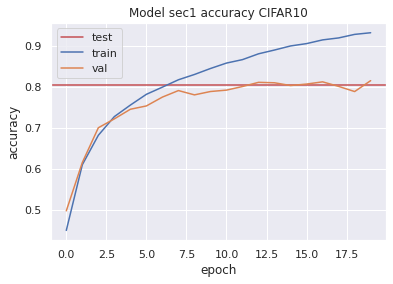

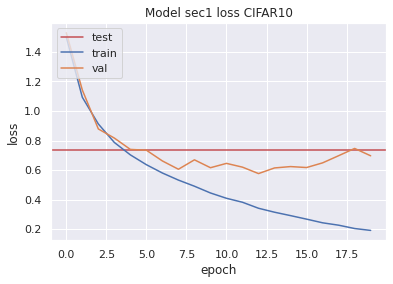

In [25]:
# CNN sec1
_batch_size = 32

model2.compile( loss='categorical_crossentropy', optimizer = keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])

# Entrenar modelo
history = model2.fit(
    x = X_train,
    y = y_train,
    batch_size=_batch_size,
    epochs=20,
    verbose=1,

    validation_data=(X_val, y_val),
)

sec1_train_accu = history.history['accuracy']
sec1_val_accu = history.history['val_accuracy']
sec1_train_loss = history.history['loss']
sec1_val_loss = history.history['val_loss']

Test = model2.evaluate(X_test,y_test)
plt.axhline(Test[1],label='test',color='r')
plt.plot(sec1_train_accu,label='train')
plt.plot(sec1_val_accu,label='val')
plt.title('Model sec1 accuracy CIFAR10')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.show()

plt.axhline(Test[0],label='test',color='r')
plt.plot(sec1_train_loss,label='train')
plt.plot(sec1_val_loss,label='val')
plt.title('Model sec1 loss CIFAR10')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.show()


### CNN sec2

Total params: 467,754

Trainable params: 465,386

Non-trainable params: 2,368

Epoch 1/20
1250/1250 [==============================] - 25s 18ms/step - loss: 1.7789 - accuracy: 0.3379 - val_loss: 1.9273 - val_accuracy: 0.3636
Epoch 2/20
1250/1250 [==============================] - 21s 17ms/step - loss: 1.5146 - accuracy: 0.4468 - val_loss: 1.6084 - val_accuracy: 0.4492
Epoch 3/20
1250/1250 [==============================] - 21s 17ms/step - loss: 1.3400 - accuracy: 0.5159 - val_loss: 1.3700 - val_accuracy: 0.5140
Epoch 4/20
1250/1250 [==============================] - 22s 18ms/step - loss: 1.1865 - accuracy: 0.5777 - val_loss: 1.2919 - val_accuracy: 0.5597
Epoch 5/20
1250/1250 [==============================] - 21s 17ms/step - loss: 1.0543 - accuracy: 0.6258 - val_loss: 1.2161 - val_accuracy: 0.5885
Epoch 6/20
1250/1250 [==============================] - 21s 17ms/step - loss: 0.9518 - accuracy: 0.6665 - val_loss: 0.9532 - val_accuracy: 0.6705
Epoch 7/20
1250/1250 [==============================] - 21s 17ms/step - loss: 0.8729 - accuracy: 0.6936 - val_loss: 0.8971 -

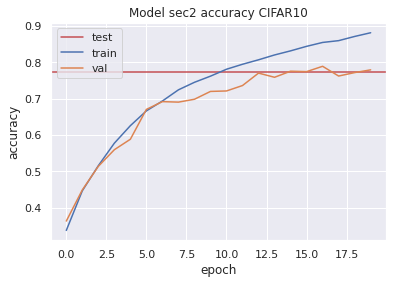

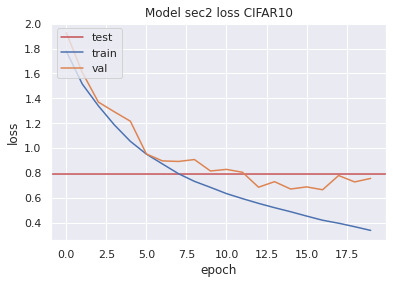

In [27]:
# CNN sec2
_batch_size = 32

model2.compile( loss='categorical_crossentropy', optimizer = keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])

# Entrenar modelo
history = model2.fit(
    x = X_train,
    y = y_train,
    batch_size=_batch_size,
    epochs=20,
    verbose=1,

    validation_data=(X_val, y_val),
)

sec2_train_accu = history.history['accuracy']
sec2_val_accu = history.history['val_accuracy']
sec2_train_loss = history.history['loss']
sec2_val_loss = history.history['val_loss']

Test = model2.evaluate(X_test,y_test)
plt.axhline(Test[1],label='test',color='r')
plt.plot(sec2_train_accu,label='train')
plt.plot(sec2_val_accu,label='val')
plt.title('Model sec2 accuracy CIFAR10')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.show()

plt.axhline(Test[0],label='test',color='r')
plt.plot(sec2_train_loss,label='train')
plt.plot(sec2_val_loss,label='val')
plt.title('Model sec2 loss CIFAR10')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper left')
#plt.xlim([0,10])
#plt.ylim([0.2,1])
plt.show()


### CNN sec3

Total params: 859,306

Trainable params: 855,146

Non-trainable params: 4,160

Epoch 1/20
1250/1250 [==============================] - 42s 30ms/step - loss: 2.1966 - accuracy: 0.1618 - val_loss: 2.2322 - val_accuracy: 0.2012
Epoch 2/20
1250/1250 [==============================] - 35s 28ms/step - loss: 1.9315 - accuracy: 0.2644 - val_loss: 2.1087 - val_accuracy: 0.2809
Epoch 3/20
1250/1250 [==============================] - 36s 29ms/step - loss: 1.8256 - accuracy: 0.3093 - val_loss: 1.7819 - val_accuracy: 0.3307
Epoch 4/20
1250/1250 [==============================] - 36s 28ms/step - loss: 1.7463 - accuracy: 0.3415 - val_loss: 1.7076 - val_accuracy: 0.3609
Epoch 5/20
1250/1250 [==============================] - 36s 28ms/step - loss: 1.6884 - accuracy: 0.3669 - val_loss: 1.7664 - val_accuracy: 0.3581
Epoch 6/20
1250/1250 [==============================] - 36s 29ms/step - loss: 1.6274 - accuracy: 0.3950 - val_loss: 1.6916 - val_accuracy: 0.3922
Epoch 7/20
1250/1250 [==============================] - 36s 28ms/step - loss: 1.5687 - accuracy: 0.4230 - val_loss: 2.1269 -

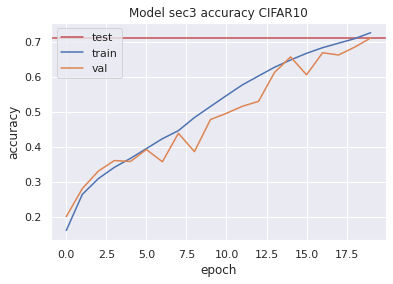

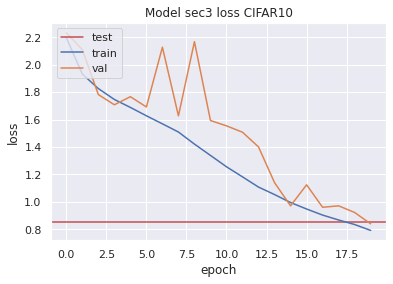

In [29]:
# CNN sec3
_batch_size = 32

model2.compile( loss='categorical_crossentropy', optimizer = keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])

# Entrenar modelo
history = model2.fit(
    x = X_train,
    y = y_train,
    batch_size=_batch_size,
    epochs=20,
    verbose=1,

    validation_data=(X_val, y_val),
)

sec3_train_accu = history.history['accuracy']
sec3_val_accu = history.history['val_accuracy']
sec3_train_loss = history.history['loss']
sec3_val_loss = history.history['val_loss']

Test = model2.evaluate(X_test,y_test)
plt.axhline(Test[1],label='test',color='r')
plt.plot(sec3_train_accu,label='train')
plt.plot(sec3_val_accu,label='val')
plt.title('Model sec3 accuracy CIFAR10')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.show()

plt.axhline(Test[0],label='test',color='r')
plt.plot(sec3_train_loss,label='train')
plt.plot(sec3_val_loss,label='val')
plt.title('Model sec3 loss CIFAR10')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.show()


### CNN skip1

Total params: 274,634

Trainable params: 273,162

Non-trainable params: 1,472

Epoch 1/20
1250/1250 [==============================] - 18s 13ms/step - loss: 1.3154 - accuracy: 0.5304 - val_loss: 1.0607 - val_accuracy: 0.6225
Epoch 2/20
1250/1250 [==============================] - 16s 13ms/step - loss: 0.9024 - accuracy: 0.6833 - val_loss: 0.8748 - val_accuracy: 0.6957
Epoch 3/20
1250/1250 [==============================] - 15s 12ms/step - loss: 0.7392 - accuracy: 0.7424 - val_loss: 0.7547 - val_accuracy: 0.7394
Epoch 4/20
1250/1250 [==============================] - 15s 12ms/step - loss: 0.6264 - accuracy: 0.7825 - val_loss: 0.6586 - val_accuracy: 0.7718
Epoch 5/20
1250/1250 [==============================] - 15s 12ms/step - loss: 0.5388 - accuracy: 0.8134 - val_loss: 0.6889 - val_accuracy: 0.7652
Epoch 6/20
1250/1250 [==============================] - 15s 12ms/step - loss: 0.4739 - accuracy: 0.8355 - val_loss: 0.6304 - val_accuracy: 0.7892
Epoch 7/20
1250/1250 [==============================] - 16s 12ms/step - loss: 0.4170 - accuracy: 0.8565 - val_loss: 0.5763 -

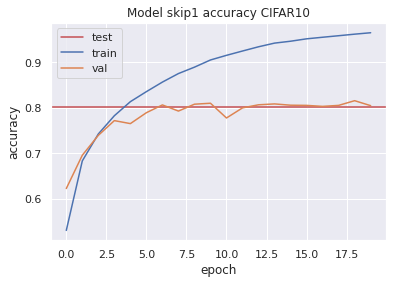

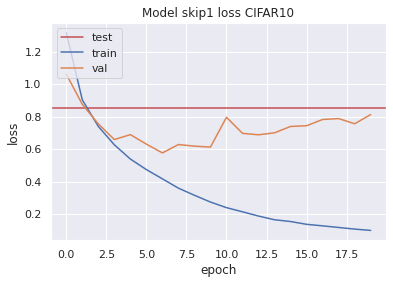

In [38]:
# CNN skip1 
_batch_size = 32

model2.compile( loss='categorical_crossentropy', optimizer = keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])

# Entrenar modelo
history = model2.fit(
    x = X_train,
    y = y_train,
    batch_size=_batch_size,
    epochs=20,
    verbose=1,

    validation_data=(X_val, y_val),
)

skip1_train_accu = history.history['accuracy']
skip1_val_accu = history.history['val_accuracy']
skip1_train_loss = history.history['loss']
skip1_val_loss = history.history['val_loss']

Test = model2.evaluate(X_test,y_test)
plt.axhline(Test[1],label='test',color='r')
plt.plot(skip1_train_accu,label='train')
plt.plot(skip1_val_accu,label='val')
plt.title('Model skip1 accuracy CIFAR10')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.show()

plt.axhline(Test[0],label='test',color='r')
plt.plot(skip1_train_loss,label='train')
plt.plot(skip1_val_loss,label='val')
plt.title('Model skip1 loss CIFAR10')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.show()

### CNN skip2

Total params: 396,042

Trainable params: 393,930

Non-trainable params: 2,112

Epoch 1/20
1250/1250 [==============================] - 26s 19ms/step - loss: 1.4220 - accuracy: 0.4857 - val_loss: 1.1710 - val_accuracy: 0.5925
Epoch 2/20
1250/1250 [==============================] - 23s 18ms/step - loss: 0.9269 - accuracy: 0.6745 - val_loss: 0.8893 - val_accuracy: 0.6898
Epoch 3/20
1250/1250 [==============================] - 22s 18ms/step - loss: 0.7333 - accuracy: 0.7447 - val_loss: 0.7575 - val_accuracy: 0.7444
Epoch 4/20
1250/1250 [==============================] - 22s 17ms/step - loss: 0.6225 - accuracy: 0.7853 - val_loss: 0.7175 - val_accuracy: 0.7538
Epoch 5/20
1250/1250 [==============================] - 22s 17ms/step - loss: 0.5327 - accuracy: 0.8163 - val_loss: 0.6971 - val_accuracy: 0.7667
Epoch 6/20
1250/1250 [==============================] - 22s 17ms/step - loss: 0.4615 - accuracy: 0.8398 - val_loss: 0.6028 - val_accuracy: 0.7984
Epoch 7/20
1250/1250 [==============================] - 22s 17ms/step - loss: 0.3998 - accuracy: 0.8618 - val_loss: 0.5861 -

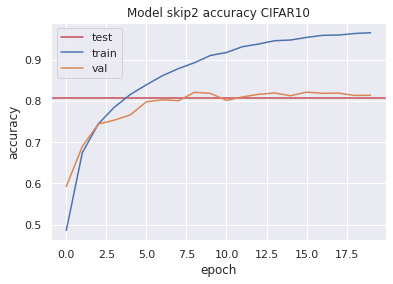

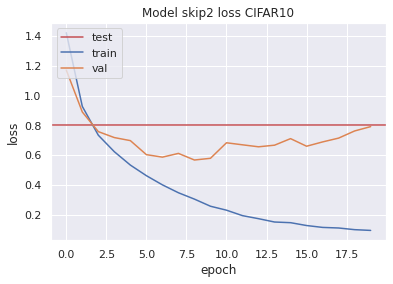

In [36]:
# CNN skip2
_batch_size = 32

model2.compile( loss='categorical_crossentropy', optimizer = keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])

# Entrenar modelo
history = model2.fit(
    x = X_train,
    y = y_train,
    batch_size=_batch_size,
    epochs=20,
    verbose=1,

    validation_data=(X_val, y_val),
)

skip2_train_accu = history.history['accuracy']
skip2_val_accu = history.history['val_accuracy']
skip2_train_loss = history.history['loss']
skip2_val_loss = history.history['val_loss']

Test = model2.evaluate(X_test,y_test)
plt.axhline(Test[1],label='test',color='r')
plt.plot(skip2_train_accu,label='train')
plt.plot(skip2_val_accu,label='val')
plt.title('Model skip2 accuracy CIFAR10')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.show()

plt.axhline(Test[0],label='test',color='r')
plt.plot(skip2_train_loss,label='train')
plt.plot(skip2_val_loss,label='val')
plt.title('Model skip2 loss CIFAR10')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.show()

### CNN skip3

Total params: 787,594

Trainable params: 783,690

Non-trainable params: 3,904

Epoch 1/20
1250/1250 [==============================] - 42s 30ms/step - loss: 1.5055 - accuracy: 0.4546 - val_loss: 1.2268 - val_accuracy: 0.5750
Epoch 2/20
1250/1250 [==============================] - 37s 29ms/step - loss: 1.0254 - accuracy: 0.6357 - val_loss: 1.0144 - val_accuracy: 0.6489
Epoch 3/20
1250/1250 [==============================] - 37s 29ms/step - loss: 0.8080 - accuracy: 0.7189 - val_loss: 0.8497 - val_accuracy: 0.7127
Epoch 4/20
1250/1250 [==============================] - 36s 29ms/step - loss: 0.6743 - accuracy: 0.7650 - val_loss: 0.6794 - val_accuracy: 0.7647
Epoch 5/20
1250/1250 [==============================] - 37s 29ms/step - loss: 0.5701 - accuracy: 0.8058 - val_loss: 0.6752 - val_accuracy: 0.7704
Epoch 6/20
1250/1250 [==============================] - 36s 29ms/step - loss: 0.4956 - accuracy: 0.8275 - val_loss: 0.6733 - val_accuracy: 0.7757
Epoch 7/20
1250/1250 [==============================] - 37s 29ms/step - loss: 0.4192 - accuracy: 0.8558 - val_loss: 0.5810 -

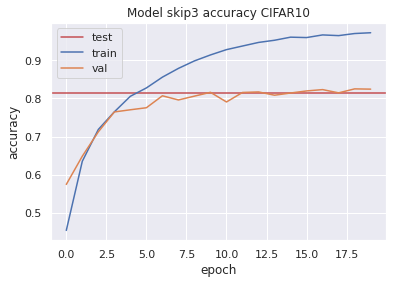

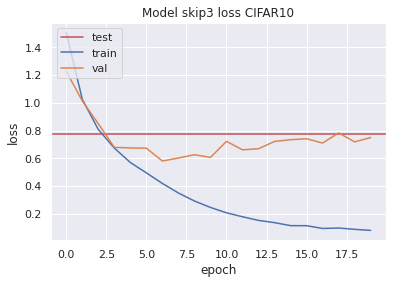

In [42]:
# CNN skip3
_batch_size = 32

model2.compile( loss='categorical_crossentropy', optimizer = keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])

# Entrenar modelo
history = model2.fit(
    x = X_train,
    y = y_train,
    batch_size=_batch_size,
    epochs=20,
    verbose=1,

    validation_data=(X_val, y_val),
)

skip3_train_accu = history.history['accuracy']
skip3_val_accu = history.history['val_accuracy']
skip3_train_loss = history.history['loss']
skip3_val_loss = history.history['val_loss']

Test = model2.evaluate(X_test,y_test)
plt.axhline(Test[1],label='test',color='r')
plt.plot(skip3_train_accu,label='train')
plt.plot(skip3_val_accu,label='val')
plt.title('Model skip3 accuracy CIFAR10')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.show()

plt.axhline(Test[0],label='test',color='r')
plt.plot(skip3_train_loss,label='train')
plt.plot(skip3_val_loss,label='val')
plt.title('Model skip3 loss CIFAR10')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.show()

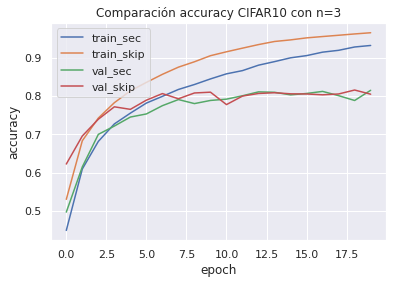

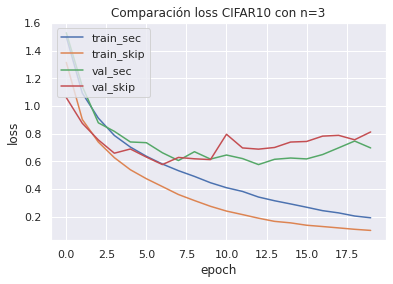

In [45]:
plt.plot(sec1_train_accu,label='train_sec')
plt.plot(skip1_train_accu,label='train_skip')
plt.plot(sec1_val_accu,label='val_sec')
plt.plot(skip1_val_accu,label='val_skip')
plt.title('Comparación accuracy CIFAR10 con n=3')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.show()


plt.plot(sec1_train_loss,label='train_sec')
plt.plot(skip1_train_loss,label='train_skip')
plt.plot(sec1_val_loss,label='val_sec')
plt.plot(skip1_val_loss,label='val_skip')
plt.title('Comparación loss CIFAR10 con n=3')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.show()

En esta gráfica no se aprecia gran diferencia en el entrenamiento sin skip connections y con skip connections, dado que la red no es muy profunda, por lo que aún no se presenta el problema de degradación.

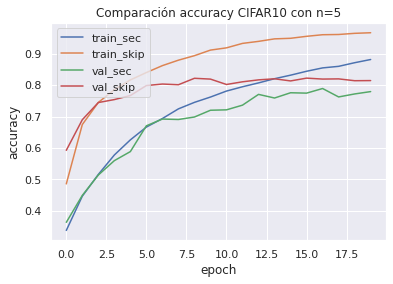

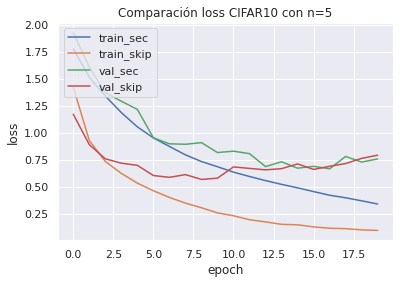

In [48]:
plt.plot(sec2_train_accu,label='train_sec')
plt.plot(skip2_train_accu,label='train_skip')
plt.plot(sec2_val_accu,label='val_sec')
plt.plot(skip2_val_accu,label='val_skip')
plt.title('Comparación accuracy CIFAR10 con n=5')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.show()


plt.plot(sec2_train_loss,label='train_sec')
plt.plot(skip2_train_loss,label='train_skip')
plt.plot(sec2_val_loss,label='val_sec')
plt.plot(skip2_val_loss,label='val_skip')
plt.title('Comparación loss CIFAR10 con n=5')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.show()

En esta gráfica se aprecia un poco mejor que en la anterior el efecto de la degradación al aumentar la profundidad.

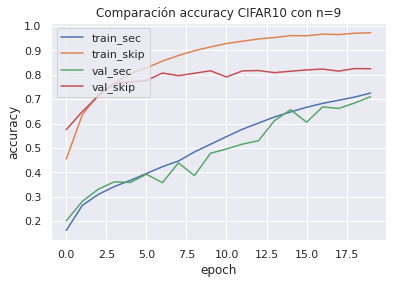

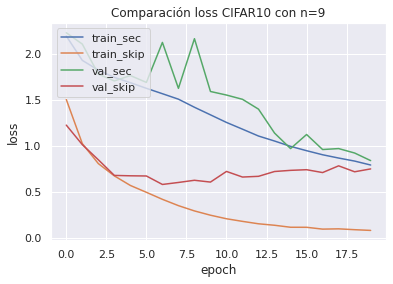

In [47]:
plt.plot(sec3_train_accu,label='train_sec')
plt.plot(skip3_train_accu,label='train_skip')
plt.plot(sec3_val_accu,label='val_sec')
plt.plot(skip3_val_accu,label='val_skip')
plt.title('Comparación accuracy CIFAR10 con n=9')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.show()


plt.plot(sec3_train_loss,label='train_sec')
plt.plot(skip3_train_loss,label='train_skip')
plt.plot(sec3_val_loss,label='val_sec')
plt.plot(skip3_val_loss,label='val_skip')
plt.title('Comparación loss CIFAR10 con n=9')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.show()

En esta gráfica, dada la gran profundidad de la red se aprecia que la red sin skip connections presenta complicaciones en el entrenamiento a diferencia de la red que incluye skip connections.

# Dataset Brain-*Tumor*

## Procesamiento de imagenes

In [49]:
# hacer la conexión a Google Drive

from google.colab import drive

colab_flag = True

if (colab_flag):
    drive.mount('/content/drive')


#path = '/content/drive/MyDrive/AyudantiaNN/T2'
# path = '/content/drive/MyDrive/2021-1/Redes_neuronales_artificiales/Tarea1/Guerra'
path = '/content/drive/MyDrive/2021-1/ANN/Tarea 1'

Mounted at /content/drive


In [50]:
#
import pandas as pd
import numpy as np
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
#from sklearn.datasets import load_boston
import matplotlib.gridspec as gridspec


#Para trabajar sobre imagenes
import cv2
import random
import os
import matplotlib.image as mpimg
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split 
from sklearn.metrics import classification_report

#tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import MaxPooling2D, Dense, Dropout,Flatten, Conv2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import TensorBoard,EarlyStopping 

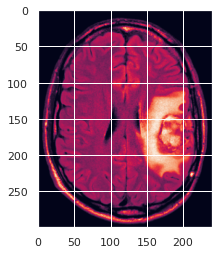

In [51]:
plt.imshow(mpimg.imread(path+'/Brain-Images/Cancer (1).png'))

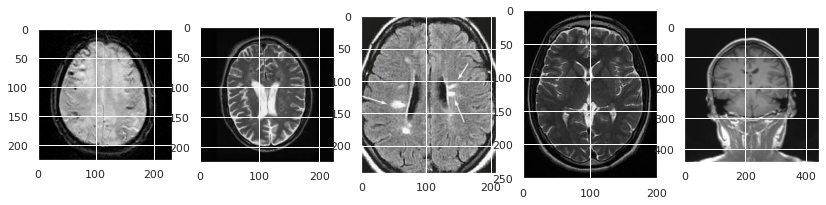

In [52]:
img_folder = path+'/Brain-Images'

fig = plt.figure(figsize=(14, 10))
#image_path = '/content/drive/MyDrive/2021-1/Redes_neuronales_artificiales/Tarea1/Guerra/brain_images2'

# revisar algunas imágenes
for i in range(5):

    file = os.listdir(img_folder)[i+20] 

    image_path= os.path.join(img_folder, file)
    
    img= mpimg.imread(image_path)
    
    ax = fig.add_subplot(1, 5,i+1)
    
    plt.imshow(img)


In [53]:
if (colab_flag):
    # cambie esta ruta a la necesaria según sea el caso. El arhivo es new_bee_wasps.csv   
    data_brain = pd.read_csv(path + '/metadata.csv' ,header=0,engine='python')
else:
    data_bee_wasps = pd.read_csv('new_bee_wasps.csv' ,header=0,engine='python')

In [54]:
data_brain.head()
#data_brain.shape

Unnamed: 0            image  class format mode          shape
0           0   Cancer (1).jpg  tumor   JPEG  RGB  (512, 512, 3)
1           1   Cancer (1).png  tumor    PNG    L     (300, 240)
2           2   Cancer (1).tif  tumor   TIFF  RGB  (256, 256, 3)
3           3  Cancer (10).jpg  tumor   JPEG  RGB  (512, 512, 3)
4           4  Cancer (10).tif  tumor   TIFF  RGB  (256, 256, 3)

In [55]:
data_brain.shape

(4600, 6)

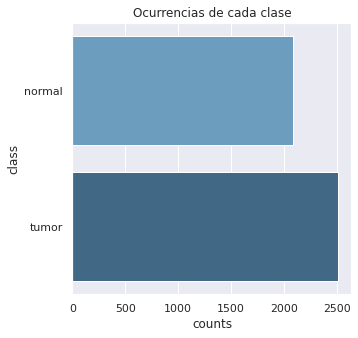

In [56]:
#distribucion de clases
kd = data_brain.groupby(['class']).size().reset_index(name='counts')
fig, ax = plt.subplots(figsize=(5,5),nrows=1)
sns.barplot(data=kd, y='class', x='counts', palette="Blues_d",ax=ax)
ax.set_title('Ocurrencias de cada clase')
plt.show()

In [57]:
#cargar las imagenes
img_folder = path+'/Brain-Images'
def process_dataset(img_folder, width, height):
    data = []
    ids = []
   
    for filename in os.listdir(img_folder):
        
        
        image_path = os.path.join(img_folder, filename)
        image = cv2.imread( image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # ahora trabajamos con imágenes RGB

        # hacemos un resize del tamaño de las imágenes antes de ingresarlo a nuestro modelo
        image = cv2.resize(image, (width, height)) # por ejemplo, 52 x 52 x 3 (3 canales => rojo, verde y azul)
        image = np.array(image)
        image = image.astype('float32')
        image /= 255 # escalar a [0, 1] 


        # obtener la clase correspondiente en los datos del csv usando la id de la imagen
        c = data_brain.loc[data_brain['image'] == filename]['class'].values[0]
                 
        data.append([c, image])

        ids.append(filename)
    
    return np.array(data), np.array(ids)

#img_folder = 'new_images_bee_wasp'

# img_data -> class, image
img_data,  ids = process_dataset(img_folder, 32, 32)

print(img_data[0][1].shape)

(32, 32, 3)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


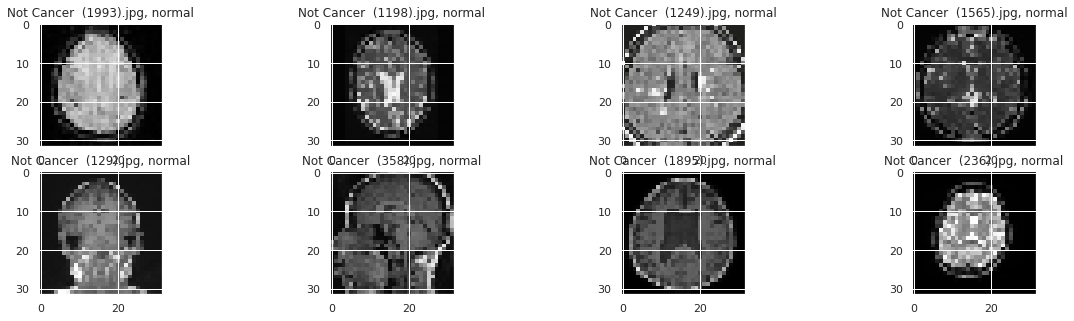

In [58]:
fig = plt.figure(figsize=(20, 5))

for i in range(8):
    img = Image.fromarray(np.uint8(img_data[i+20][1] * 255))
    
    ax = fig.add_subplot(2, 4, i+1)
    ax.title.set_text(ids[i] + ', ' + img_data[i+20][0] )

    plt.imshow(img, interpolation='none')

In [59]:
n_classes = 2

X = np.array(img_data[:, 1].tolist())

# codificación one-hot para etiquetas (bee o wasp)
Y =  pd.get_dummies(img_data[:, 0])

Y

normal  tumor
0          1      0
1          1      0
2          1      0
3          1      0
4          1      0
...      ...    ...
4595       0      1
4596       0      1
4597       0      1
4598       0      1
4599       0      1

[4600 rows x 2 columns]

In [60]:
# split en train, val y test
_validation_split = 0.2

# Split de los ejemplos de entrenamiento
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=_validation_split, random_state=0)


print("X,y Shapes:", X.shape, Y.shape)
print("X,y Train Shapes:", X_train.shape, y_train.shape)
print("X,y Val Shapes:", X_val.shape, y_val.shape)
print("X,y Test Shapes:", X_test.shape, y_test.shape)



X,y Shapes: (4600, 32, 32, 3) (4600, 2)
X,y Train Shapes: (2944, 32, 32, 3) (2944, 2)
X,y Val Shapes: (736, 32, 32, 3) (736, 2)
X,y Test Shapes: (920, 32, 32, 3) (920, 2)


## Arquitecturas

Model: "Brain_CNN"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
MyInput (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_583 (Conv2D)             (None, 32, 32, 16)   448         MyInput[0][0]                    
__________________________________________________________________________________________________
batch_normalization_565 (BatchN (None, 32, 32, 16)   64          conv2d_583[0][0]                 
__________________________________________________________________________________________________
conv2d_584 (Conv2D)             (None, 32, 32, 16)   2320        batch_normalization_565[0][0]    
__________________________________________________________________________________________

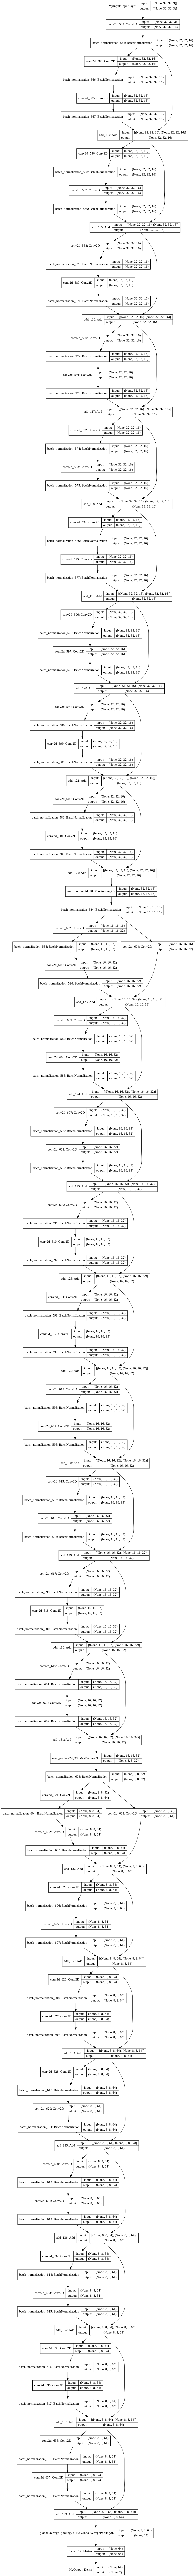

In [71]:
#modelos finales
from keras.layers import merge
# Without skip connections but with batch normalization

def get_model_CNN_sec1(activation_func,seed=1234):
  
    tf.random.set_seed(seed)
    input = keras.Input(shape=(32,32,3,), name='MyInput')
    x0 = layers.Conv2D(filters = 16, kernel_size = 3, activation = activation_func, padding="same")(input) 
    bn0 = layers.BatchNormalization()(x0)
    x1 = layers.Conv2D(filters = 16, kernel_size = 3, activation = activation_func, padding="same")(bn0)  
    bn1 = layers.BatchNormalization()(x1)  
    x2 = layers.Conv2D(filters = 16, kernel_size = 3, activation = activation_func, padding="same")(bn1)
    bn2 = layers.BatchNormalization()(x2)    
    x3 = layers.Conv2D(filters = 16, kernel_size = 3, activation = activation_func, padding="same")(bn2)
    bn3 = layers.BatchNormalization()(x3) 
    x4 = layers.Conv2D(filters = 16, kernel_size = 3, activation = activation_func, padding="same")(bn3)
    bn4 = layers.BatchNormalization()(x4)  
    x5 = layers.Conv2D(filters = 16, kernel_size = 3, activation = activation_func, padding="same")(bn4)
    bn5 = layers.BatchNormalization()(x5) 
    x6 = layers.Conv2D(filters = 16, kernel_size = 3, activation = activation_func, padding="same")(bn5)
    bn6 = layers.BatchNormalization()(x6) 
    xp1 = layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid')(bn6) 
    bnp1 = layers.BatchNormalization()(xp1) 
    x7 = layers.Conv2D(filters = 32, kernel_size = 3, activation = activation_func, padding="same")(bnp1) 
    bn7 = layers.BatchNormalization()(x7)    
    x8 = layers.Conv2D(filters = 32, kernel_size = 3, activation = activation_func, padding="same")(bn7)
    bn8 = layers.BatchNormalization()(x8)  
    x9 = layers.Conv2D(filters = 32, kernel_size = 3, activation = activation_func, padding="same")(bn8)
    bn9 = layers.BatchNormalization()(x9)  
    x10 = layers.Conv2D(filters = 32, kernel_size = 3, activation = activation_func, padding="same")(bn9)
    bn10 = layers.BatchNormalization()(x10)  
    x11 = layers.Conv2D(filters = 32, kernel_size = 3, activation = activation_func, padding="same")(bn10)
    bn11 = layers.BatchNormalization()(x11)  
    x12 = layers.Conv2D(filters = 32, kernel_size = 3, activation = activation_func, padding="same")(bn11)
    bn12 = layers.BatchNormalization()(x12)  
    xp2 = layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid')(bn12) 
    bnp2 = layers.BatchNormalization()(xp2) 
    x13 = layers.Conv2D(filters = 64, kernel_size = 3, activation = activation_func, padding="same")(bnp2) 
    bn13 = layers.BatchNormalization()(x13)     
    x14 = layers.Conv2D(filters = 64, kernel_size = 3, activation = activation_func, padding="same")(bn13)
    bn14 = layers.BatchNormalization()(x14)  
    x15 = layers.Conv2D(filters = 64, kernel_size = 3, activation = activation_func, padding="same")(bn14)
    bn15 = layers.BatchNormalization()(x15)  
    x16 = layers.Conv2D(filters = 64, kernel_size = 3, activation = activation_func, padding="same")(bn15)
    bn16 = layers.BatchNormalization()(x16)  
    x17 = layers.Conv2D(filters = 64, kernel_size = 3, activation = activation_func, padding="same")(bn16)
    bn17 = layers.BatchNormalization()(x17)  
    x18 = layers.Conv2D(filters = 64, kernel_size = 3, activation = activation_func, padding="same")(bn17)
    bn18 = layers.BatchNormalization()(x18)  
    xp3 = layers.GlobalAveragePooling2D()(bn18)
    xfl = layers.Flatten()(xp3)
    output = layers.Dense(2, activation='softmax', name='MyOutput')(xfl)
    model = keras.Model(inputs=input, outputs=output, name='Brain_CNN')

    return model


def get_model_CNN_sec3(activation_func,seed=1234):#igual que sec3, pero con más profundidad
  
    tf.random.set_seed(seed)
    input = keras.Input(shape=(32,32,3,), name='MyInput')
    x0 = layers.Conv2D(filters = 16, kernel_size = 3, activation = activation_func, padding="same")(input) 
    bn = layers.BatchNormalization()(x0)
    x  = layers.Conv2D(filters = 16, kernel_size = 3, activation = activation_func, padding="same")(bn)  
    bn = layers.BatchNormalization()(x)  
    x  = layers.Conv2D(filters = 16, kernel_size = 3, activation = activation_func, padding="same")(bn)  
    bn = layers.BatchNormalization()(x) 
    x  = layers.Conv2D(filters = 16, kernel_size = 3, activation = activation_func, padding="same")(bn)  
    bn = layers.BatchNormalization()(x) 
    x  = layers.Conv2D(filters = 16, kernel_size = 3, activation = activation_func, padding="same")(bn)  
    bn = layers.BatchNormalization()(x) 
    x  = layers.Conv2D(filters = 16, kernel_size = 3, activation = activation_func, padding="same")(bn)  
    bn = layers.BatchNormalization()(x) 
    x  = layers.Conv2D(filters = 16, kernel_size = 3, activation = activation_func, padding="same")(bn)  
    bn = layers.BatchNormalization()(x) 
    x  = layers.Conv2D(filters = 16, kernel_size = 3, activation = activation_func, padding="same")(bn)  
    bn = layers.BatchNormalization()(x) 
    x  = layers.Conv2D(filters = 16, kernel_size = 3, activation = activation_func, padding="same")(bn)  
    bn = layers.BatchNormalization()(x) 
    x  = layers.Conv2D(filters = 16, kernel_size = 3, activation = activation_func, padding="same")(bn)  
    bn = layers.BatchNormalization()(x) 
    x  = layers.Conv2D(filters = 16, kernel_size = 3, activation = activation_func, padding="same")(bn)  
    bn = layers.BatchNormalization()(x) 
    x  = layers.Conv2D(filters = 16, kernel_size = 3, activation = activation_func, padding="same")(bn)  
    bn = layers.BatchNormalization()(x) 
    x  = layers.Conv2D(filters = 16, kernel_size = 3, activation = activation_func, padding="same")(bn)  
    bn = layers.BatchNormalization()(x) 
    x  = layers.Conv2D(filters = 16, kernel_size = 3, activation = activation_func, padding="same")(bn)  
    bn = layers.BatchNormalization()(x) 
    x  = layers.Conv2D(filters = 16, kernel_size = 3, activation = activation_func, padding="same")(bn)  
    bn = layers.BatchNormalization()(x) 
    x  = layers.Conv2D(filters = 16, kernel_size = 3, activation = activation_func, padding="same")(bn)  
    bn = layers.BatchNormalization()(x) 
    x  = layers.Conv2D(filters = 16, kernel_size = 3, activation = activation_func, padding="same")(bn)  
    bn = layers.BatchNormalization()(x) 
    x  = layers.Conv2D(filters = 16, kernel_size = 3, activation = activation_func, padding="same")(bn)  
    bn = layers.BatchNormalization()(x) 
    x  = layers.Conv2D(filters = 16, kernel_size = 3, activation = activation_func, padding="same")(bn)  
    bn = layers.BatchNormalization()(x)
    xp1 = layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid')(bn) 
    bnp1 = layers.BatchNormalization()(xp1)
    x  = layers.Conv2D(filters = 32, kernel_size = 3, activation = activation_func, padding="same")(bnp1)  
    bn = layers.BatchNormalization()(x)  
    x  = layers.Conv2D(filters = 32, kernel_size = 3, activation = activation_func, padding="same")(bn)  
    bn = layers.BatchNormalization()(x) 
    x  = layers.Conv2D(filters = 32, kernel_size = 3, activation = activation_func, padding="same")(bn)  
    bn = layers.BatchNormalization()(x) 
    x  = layers.Conv2D(filters = 32, kernel_size = 3, activation = activation_func, padding="same")(bn)  
    bn = layers.BatchNormalization()(x) 
    x  = layers.Conv2D(filters = 32, kernel_size = 3, activation = activation_func, padding="same")(bn)  
    bn = layers.BatchNormalization()(x) 
    x  = layers.Conv2D(filters = 32, kernel_size = 3, activation = activation_func, padding="same")(bn)  
    bn = layers.BatchNormalization()(x) 
    x  = layers.Conv2D(filters = 32, kernel_size = 3, activation = activation_func, padding="same")(bn)  
    bn = layers.BatchNormalization()(x) 
    x  = layers.Conv2D(filters = 32, kernel_size = 3, activation = activation_func, padding="same")(bn)  
    bn = layers.BatchNormalization()(x) 
    x  = layers.Conv2D(filters = 32, kernel_size = 3, activation = activation_func, padding="same")(bn)  
    bn = layers.BatchNormalization()(x) 
    x  = layers.Conv2D(filters = 32, kernel_size = 3, activation = activation_func, padding="same")(bn)  
    bn = layers.BatchNormalization()(x) 
    x  = layers.Conv2D(filters = 32, kernel_size = 3, activation = activation_func, padding="same")(bn)  
    bn = layers.BatchNormalization()(x) 
    x  = layers.Conv2D(filters = 32, kernel_size = 3, activation = activation_func, padding="same")(bn)  
    bn = layers.BatchNormalization()(x) 
    x  = layers.Conv2D(filters = 32, kernel_size = 3, activation = activation_func, padding="same")(bn)  
    bn = layers.BatchNormalization()(x) 
    x  = layers.Conv2D(filters = 32, kernel_size = 3, activation = activation_func, padding="same")(bn)  
    bn = layers.BatchNormalization()(x) 
    x  = layers.Conv2D(filters = 32, kernel_size = 3, activation = activation_func, padding="same")(bn)  
    bn = layers.BatchNormalization()(x) 
    x  = layers.Conv2D(filters = 32, kernel_size = 3, activation = activation_func, padding="same")(bn)  
    bn = layers.BatchNormalization()(x) 
    x  = layers.Conv2D(filters = 32, kernel_size = 3, activation = activation_func, padding="same")(bn)  
    bn = layers.BatchNormalization()(x) 
    x  = layers.Conv2D(filters = 32, kernel_size = 3, activation = activation_func, padding="same")(bn)  
    bn = layers.BatchNormalization()(x) 
    xp2 = layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid')(bn) 
    bnp2 = layers.BatchNormalization()(xp2)
    x  = layers.Conv2D(filters = 64, kernel_size = 3, activation = activation_func, padding="same")(bnp2)  
    bn = layers.BatchNormalization()(x)  
    x  = layers.Conv2D(filters = 64, kernel_size = 3, activation = activation_func, padding="same")(bn)  
    bn = layers.BatchNormalization()(x) 
    x  = layers.Conv2D(filters = 64, kernel_size = 3, activation = activation_func, padding="same")(bn)  
    bn = layers.BatchNormalization()(x) 
    x  = layers.Conv2D(filters = 64, kernel_size = 3, activation = activation_func, padding="same")(bn)  
    bn = layers.BatchNormalization()(x) 
    x  = layers.Conv2D(filters = 64, kernel_size = 3, activation = activation_func, padding="same")(bn)  
    bn = layers.BatchNormalization()(x) 
    x  = layers.Conv2D(filters = 64, kernel_size = 3, activation = activation_func, padding="same")(bn)  
    bn = layers.BatchNormalization()(x) 
    x  = layers.Conv2D(filters = 64, kernel_size = 3, activation = activation_func, padding="same")(bn)  
    bn = layers.BatchNormalization()(x) 
    x  = layers.Conv2D(filters = 64, kernel_size = 3, activation = activation_func, padding="same")(bn)  
    bn = layers.BatchNormalization()(x) 
    x  = layers.Conv2D(filters = 64, kernel_size = 3, activation = activation_func, padding="same")(bn)  
    bn = layers.BatchNormalization()(x) 
    x  = layers.Conv2D(filters = 64, kernel_size = 3, activation = activation_func, padding="same")(bn)  
    bn = layers.BatchNormalization()(x) 
    x  = layers.Conv2D(filters = 64, kernel_size = 3, activation = activation_func, padding="same")(bn)  
    bn = layers.BatchNormalization()(x) 
    x  = layers.Conv2D(filters = 64, kernel_size = 3, activation = activation_func, padding="same")(bn)  
    bn = layers.BatchNormalization()(x) 
    x  = layers.Conv2D(filters = 64, kernel_size = 3, activation = activation_func, padding="same")(bn)  
    bn = layers.BatchNormalization()(x) 
    x  = layers.Conv2D(filters = 64, kernel_size = 3, activation = activation_func, padding="same")(bn)  
    bn = layers.BatchNormalization()(x) 
    x  = layers.Conv2D(filters = 64, kernel_size = 3, activation = activation_func, padding="same")(bn)  
    bn = layers.BatchNormalization()(x) 
    x  = layers.Conv2D(filters = 64, kernel_size = 3, activation = activation_func, padding="same")(bn)  
    bn = layers.BatchNormalization()(x) 
    x  = layers.Conv2D(filters = 64, kernel_size = 3, activation = activation_func, padding="same")(bn)  
    bn = layers.BatchNormalization()(x) 
    x  = layers.Conv2D(filters = 64, kernel_size = 3, activation = activation_func, padding="same")(bn)  
    bn = layers.BatchNormalization()(x)
    xp3 = layers.GlobalAveragePooling2D()(bn)
    xfl = layers.Flatten()(xp3)
    output = layers.Dense(2, activation='softmax', name='MyOutput')(xfl)
    model = keras.Model(inputs=input, outputs=output, name='Brain_CNN')

    return model

# With skip connections

def get_model_CNN_skip1(activation_func,seed=1234): #with zero-padding shorcuts and projection shorctus, and batch normalization
  
    tf.random.set_seed(seed)
    input = keras.Input(shape=(32,32,3,), name='MyInput')
    x0 = layers.Conv2D(filters = 16, kernel_size = 3, activation = activation_func, padding="same")(input) 
    bn0 = layers.BatchNormalization()(x0)
    x1 = layers.Conv2D(filters = 16, kernel_size = 3, activation = activation_func, padding="same")(bn0)  
    bn1 = layers.BatchNormalization()(x1)  
    x2 = layers.Conv2D(filters = 16, kernel_size = 3, activation = activation_func, padding="same")(bn1)
    bn2 = layers.BatchNormalization()(x2) 
    block_1 = layers.add([bn0, bn2]) #zero-padding shorcut   
    x3 = layers.Conv2D(filters = 16, kernel_size = 3, activation = activation_func, padding="same")(block_1)
    bn3 = layers.BatchNormalization()(x3) 
    x4 = layers.Conv2D(filters = 16, kernel_size = 3, activation = activation_func, padding="same")(bn3)
    bn4 = layers.BatchNormalization()(x4) 
    block_2 = layers.add([block_1, bn4]) #zero-padding shorcut
    x5 = layers.Conv2D(filters = 16, kernel_size = 3, activation = activation_func, padding="same")(block_2)
    bn5 = layers.BatchNormalization()(x5) 
    x6 = layers.Conv2D(filters = 16, kernel_size = 3, activation = activation_func, padding="same")(bn5)
    bn6 = layers.BatchNormalization()(x6) 
    block_3 = layers.add([block_2, bn6]) #zero-padding shorcut 
    xp1 = layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid')(block_3) 
    bnp1 = layers.BatchNormalization()(xp1) 
    x7 = layers.Conv2D(filters = 32, kernel_size = 3, activation = activation_func, padding="same")(bnp1) 
    bn7 = layers.BatchNormalization()(x7)    
    x8 = layers.Conv2D(filters = 32, kernel_size = 3, activation = activation_func, padding="same")(bn7)
    bn8 = layers.BatchNormalization()(x8)  
    x1x1_1 = layers.Conv2D(filters = 32, kernel_size = 1, activation = activation_func)(bnp1)   
    block_ps1 = layers.add([x1x1_1, bn8]) #projection shorcut
    x9 = layers.Conv2D(filters = 32, kernel_size = 3, activation = activation_func, padding="same")(block_ps1)
    bn9 = layers.BatchNormalization()(x9)  
    x10 = layers.Conv2D(filters = 32, kernel_size = 3, activation = activation_func, padding="same")(bn9)
    bn10 = layers.BatchNormalization()(x10)  
    block_4 = layers.add([block_ps1, bn10]) #zero-padding shorcut
    x11 = layers.Conv2D(filters = 32, kernel_size = 3, activation = activation_func, padding="same")(block_4)
    bn11 = layers.BatchNormalization()(x11)  
    x12 = layers.Conv2D(filters = 32, kernel_size = 3, activation = activation_func, padding="same")(bn11)
    bn12 = layers.BatchNormalization()(x12)  
    block_5 = layers.add([block_4, bn12]) #zero-padding shorcut
    xp2 = layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid')(block_5) 
    bnp2 = layers.BatchNormalization()(xp2) 
    x13 = layers.Conv2D(filters = 64, kernel_size = 3, activation = activation_func, padding="same")(bnp2) 
    bn13 = layers.BatchNormalization()(x13)     
    x14 = layers.Conv2D(filters = 64, kernel_size = 3, activation = activation_func, padding="same")(bn13)
    bn14 = layers.BatchNormalization()(x14)  
    x1x1_2 = layers.Conv2D(filters = 64, kernel_size = 1, activation = activation_func)(bnp2)   
    block_ps2 = layers.add([x1x1_2, bn14]) #projection shorcut
    x15 = layers.Conv2D(filters = 64, kernel_size = 3, activation = activation_func, padding="same")(block_ps2)
    bn15 = layers.BatchNormalization()(x15)  
    x16 = layers.Conv2D(filters = 64, kernel_size = 3, activation = activation_func, padding="same")(bn15)
    bn16 = layers.BatchNormalization()(x16)  
    block_6 = layers.add([block_ps2, bn16]) #zero-padding shorcut
    x17 = layers.Conv2D(filters = 64, kernel_size = 3, activation = activation_func, padding="same")(block_6)
    bn17 = layers.BatchNormalization()(x17)  
    x18 = layers.Conv2D(filters = 64, kernel_size = 3, activation = activation_func, padding="same")(bn17)
    bn18 = layers.BatchNormalization()(x18)  
    block_7 = layers.add([block_6, bn18]) #zero-padding shorcut
    xp3 = layers.GlobalAveragePooling2D()(block_7)
    xfl = layers.Flatten()(xp3)
    output = layers.Dense(2, activation='softmax', name='MyOutput')(xfl)
    model = keras.Model(inputs=input, outputs=output, name='Brain_CNN')

    return model

def get_model_CNN_skip3(activation_func,seed=1234): ##with zero-padding shorcuts and projection shorctus, and batch normalization, but more layer than model skip3 with equal filters number 
  
    tf.random.set_seed(seed)
    input = keras.Input(shape=(32,32,3,), name='MyInput')
    x0 = layers.Conv2D(filters = 16, kernel_size = 3, activation = activation_func, padding="same")(input) 
    bn0 = layers.BatchNormalization()(x0)
    x1 = layers.Conv2D(filters = 16, kernel_size = 3, activation = activation_func, padding="same")(bn0)
    bn1 = layers.BatchNormalization()(x1)    
    x2 = layers.Conv2D(filters = 16, kernel_size = 3, activation = activation_func, padding="same")(bn1)
    bn2 = layers.BatchNormalization()(x2)
    block_1 = layers.add([bn0, bn2])      
    x3 = layers.Conv2D(filters = 16, kernel_size = 3, activation = activation_func, padding="same")(block_1)
    bn3 = layers.BatchNormalization()(x3)
    x4 = layers.Conv2D(filters = 16, kernel_size = 3, activation = activation_func, padding="same")(bn3)
    bn4 = layers.BatchNormalization()(x4)
    block_2 = layers.add([block_1, bn4])  
    x5 = layers.Conv2D(filters = 16, kernel_size = 3, activation = activation_func, padding="same")(block_2)
    bn5 = layers.BatchNormalization()(x5)
    x6 = layers.Conv2D(filters = 16, kernel_size = 3, activation = activation_func, padding="same")(bn5)
    bn6 = layers.BatchNormalization()(x6)
    block_3 = layers.add([block_2, bn6]) 
    x7 = layers.Conv2D(filters = 16, kernel_size = 3, activation = activation_func, padding="same")(block_3)
    bn7 = layers.BatchNormalization()(x7)
    x8 = layers.Conv2D(filters = 16, kernel_size = 3, activation = activation_func, padding="same")(bn7)
    bn8 = layers.BatchNormalization()(x8)
    block_4 = layers.add([block_3, bn8]) 
    x9 = layers.Conv2D(filters = 16, kernel_size = 3, activation = activation_func, padding="same")(block_4)
    bn9 = layers.BatchNormalization()(x9)
    x10 = layers.Conv2D(filters = 16, kernel_size = 3, activation = activation_func, padding="same")(bn9)
    bn10 = layers.BatchNormalization()(x10)
    block_5 = layers.add([block_4, bn10]) 
    x11 = layers.Conv2D(filters = 16, kernel_size = 3, activation = activation_func, padding="same")(block_5)
    bn11 = layers.BatchNormalization()(x11)    
    x12 = layers.Conv2D(filters = 16, kernel_size = 3, activation = activation_func, padding="same")(bn11)
    bn12 = layers.BatchNormalization()(x12)
    block_6 = layers.add([block_5, bn12])      
    x13 = layers.Conv2D(filters = 16, kernel_size = 3, activation = activation_func, padding="same")(block_6)
    bn13 = layers.BatchNormalization()(x13)
    x14 = layers.Conv2D(filters = 16, kernel_size = 3, activation = activation_func, padding="same")(bn13)
    bn14 = layers.BatchNormalization()(x14)
    block_7 = layers.add([block_6, bn14])  
    x15 = layers.Conv2D(filters = 16, kernel_size = 3, activation = activation_func, padding="same")(block_7)
    bn15 = layers.BatchNormalization()(x15)
    x16 = layers.Conv2D(filters = 16, kernel_size = 3, activation = activation_func, padding="same")(bn15)
    bn16 = layers.BatchNormalization()(x16)
    block_8 = layers.add([block_7, bn16]) 
    x17 = layers.Conv2D(filters = 16, kernel_size = 3, activation = activation_func, padding="same")(block_8)
    bn17 = layers.BatchNormalization()(x17)
    x18 = layers.Conv2D(filters = 16, kernel_size = 3, activation = activation_func, padding="same")(bn17)
    bn18 = layers.BatchNormalization()(x18)
    block_9 = layers.add([block_8, bn18]) 
    xp1 = layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid')(block_9) 
    bnp1 = layers.BatchNormalization()(xp1)
    x19 = layers.Conv2D(filters = 32, kernel_size = 3, activation = activation_func, padding="same")(bnp1) 
    bn19 = layers.BatchNormalization()(x19)   
    x20 = layers.Conv2D(filters = 32, kernel_size = 3, activation = activation_func, padding="same")(bn19)
    bn20 = layers.BatchNormalization()(x20)
    x1x1_1 = layers.Conv2D(filters = 32, kernel_size = 1, activation = activation_func)(bnp1)   
    block_ps1 = layers.add([x1x1_1, bn20]) 
    x21 = layers.Conv2D(filters = 32, kernel_size = 3, activation = activation_func, padding="same")(block_ps1)
    bn21 = layers.BatchNormalization()(x21)
    x22 = layers.Conv2D(filters = 32, kernel_size = 3, activation = activation_func, padding="same")(bn21)
    bn22 = layers.BatchNormalization()(x22)
    block_10 = layers.add([block_ps1, bn22])
    x23 = layers.Conv2D(filters = 32, kernel_size = 3, activation = activation_func, padding="same")(block_10)
    bn23 = layers.BatchNormalization()(x23)
    x24 = layers.Conv2D(filters = 32, kernel_size = 3, activation = activation_func, padding="same")(bn23)
    bn24 = layers.BatchNormalization()(x24)
    block_11 = layers.add([block_10, bn24])
    x25 = layers.Conv2D(filters = 32, kernel_size = 3, activation = activation_func, padding="same")(block_11)
    bn25 = layers.BatchNormalization()(x25)
    x26 = layers.Conv2D(filters = 32, kernel_size = 3, activation = activation_func, padding="same")(bn25)
    bn26 = layers.BatchNormalization()(x26)
    block_12 = layers.add([block_11, bn26])
    x27 = layers.Conv2D(filters = 32, kernel_size = 3, activation = activation_func, padding="same")(block_12)
    bn27 = layers.BatchNormalization()(x27)
    x28 = layers.Conv2D(filters = 32, kernel_size = 3, activation = activation_func, padding="same")(bn27)
    bn28 = layers.BatchNormalization()(x28)
    block_13 = layers.add([block_12, bn28])
    x29 = layers.Conv2D(filters = 32, kernel_size = 3, activation = activation_func, padding="same")(block_13)
    bn29 = layers.BatchNormalization()(x29)
    x30 = layers.Conv2D(filters = 32, kernel_size = 3, activation = activation_func, padding="same")(bn29)
    bn30 = layers.BatchNormalization()(x30)
    block_14 = layers.add([block_13, bn30])
    x31 = layers.Conv2D(filters = 32, kernel_size = 3, activation = activation_func, padding="same")(block_14)
    bn31 = layers.BatchNormalization()(x31)
    x32 = layers.Conv2D(filters = 32, kernel_size = 3, activation = activation_func, padding="same")(bn31)
    bn32 = layers.BatchNormalization()(x32)
    block_15 = layers.add([block_14, bn32])
    x33 = layers.Conv2D(filters = 32, kernel_size = 3, activation = activation_func, padding="same")(block_15)
    bn33 = layers.BatchNormalization()(x33)
    x34 = layers.Conv2D(filters = 32, kernel_size = 3, activation = activation_func, padding="same")(bn33)
    bn34 = layers.BatchNormalization()(x34)
    block_16 = layers.add([block_15, bn34])
    x35 = layers.Conv2D(filters = 32, kernel_size = 3, activation = activation_func, padding="same")(block_16)
    bn35 = layers.BatchNormalization()(x35)
    x36 = layers.Conv2D(filters = 32, kernel_size = 3, activation = activation_func, padding="same")(bn35)
    bn36 = layers.BatchNormalization()(x36)
    block_17 = layers.add([block_16, bn36])
    xp2 = layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid')(block_17) 
    bnp2 = layers.BatchNormalization()(xp2)
    x37 = layers.Conv2D(filters = 64, kernel_size = 3, activation = activation_func, padding="same")(bnp2)    
    bn37 = layers.BatchNormalization()(x37)
    x38 = layers.Conv2D(filters = 64, kernel_size = 3, activation = activation_func, padding="same")(bn37)
    bn38 = layers.BatchNormalization()(x38)
    x1x1_2 = layers.Conv2D(filters = 64, kernel_size = 1, activation = activation_func)(bnp2)   
    block_ps2 = layers.add([x1x1_2, bn38]) 
    x39 = layers.Conv2D(filters = 64, kernel_size = 3, activation = activation_func, padding="same")(block_ps2)
    bn39 = layers.BatchNormalization()(x39)
    x40 = layers.Conv2D(filters = 64, kernel_size = 3, activation = activation_func, padding="same")(bn39)
    bn40 = layers.BatchNormalization()(x40)
    block_18 = layers.add([block_ps2, bn40])
    x41 = layers.Conv2D(filters = 64, kernel_size = 3, activation = activation_func, padding="same")(block_18)
    bn41 = layers.BatchNormalization()(x41)
    x42 = layers.Conv2D(filters = 64, kernel_size = 3, activation = activation_func, padding="same")(bn41)
    bn42 = layers.BatchNormalization()(x42)
    block_19 = layers.add([block_18, bn42])
    x43 = layers.Conv2D(filters = 64, kernel_size = 3, activation = activation_func, padding="same")(block_19)
    bn43 = layers.BatchNormalization()(x43)
    x44 = layers.Conv2D(filters = 64, kernel_size = 3, activation = activation_func, padding="same")(bn43)
    bn44 = layers.BatchNormalization()(x44)
    block_20 = layers.add([block_19, bn44])
    x45 = layers.Conv2D(filters = 64, kernel_size = 3, activation = activation_func, padding="same")(block_20)
    bn45 = layers.BatchNormalization()(x45)
    x46 = layers.Conv2D(filters = 64, kernel_size = 3, activation = activation_func, padding="same")(bn45)
    bn46 = layers.BatchNormalization()(x46)
    block_21 = layers.add([block_20, bn46])
    x47 = layers.Conv2D(filters = 64, kernel_size = 3, activation = activation_func, padding="same")(block_21)
    bn47 = layers.BatchNormalization()(x47)
    x48 = layers.Conv2D(filters = 64, kernel_size = 3, activation = activation_func, padding="same")(bn47)
    bn48 = layers.BatchNormalization()(x48)
    block_22 = layers.add([block_21, bn48])
    x49 = layers.Conv2D(filters = 64, kernel_size = 3, activation = activation_func, padding="same")(block_22)
    bn49 = layers.BatchNormalization()(x49)
    x50 = layers.Conv2D(filters = 64, kernel_size = 3, activation = activation_func, padding="same")(bn49)
    bn50 = layers.BatchNormalization()(x50)
    block_23 = layers.add([block_22, bn50])
    x51 = layers.Conv2D(filters = 64, kernel_size = 3, activation = activation_func, padding="same")(block_23)
    bn51 = layers.BatchNormalization()(x51)
    x52 = layers.Conv2D(filters = 64, kernel_size = 3, activation = activation_func, padding="same")(bn51)
    bn52 = layers.BatchNormalization()(x52)
    block_24 = layers.add([block_23, bn52])
    xp3 = layers.GlobalAveragePooling2D()(block_24)
    xfl = layers.Flatten()(xp3)
    output = layers.Dense(2, activation='softmax', name='MyOutput')(xfl)
    model = keras.Model(inputs=input, outputs=output, name='Brain_CNN')

    return model

model2 = get_model_CNN_skip3('relu')

model2.summary()

keras.utils.plot_model(model2, show_shapes=True)

## Resultados 

### CNN sec1

In [64]:
# CNN sec1
_batch_size = 32

model2.compile( loss='categorical_crossentropy', optimizer = keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])

# Entrenar modelo
history = model2.fit(
    x = X_train,
    y = y_train,
    batch_size=_batch_size,
    epochs=20,
    verbose=1,

    validation_data=(X_val, y_val),
)

sec1_train_accu = history.history['accuracy']
sec1_val_accu = history.history['val_accuracy']
sec1_train_loss = history.history['loss']
sec1_val_loss = history.history['val_loss']


Epoch 1/20
92/92 [==============================] - 4s 17ms/step - loss: 0.5689 - accuracy: 0.6967 - val_loss: 0.7824 - val_accuracy: 0.4457
Epoch 2/20
92/92 [==============================] - 1s 12ms/step - loss: 0.3892 - accuracy: 0.8244 - val_loss: 0.9937 - val_accuracy: 0.4457
Epoch 3/20
92/92 [==============================] - 1s 12ms/step - loss: 0.2678 - accuracy: 0.8974 - val_loss: 1.8179 - val_accuracy: 0.4878
Epoch 4/20
92/92 [==============================] - 1s 12ms/step - loss: 0.2180 - accuracy: 0.9117 - val_loss: 0.8574 - val_accuracy: 0.5978
Epoch 5/20
92/92 [==============================] - 1s 12ms/step - loss: 0.1654 - accuracy: 0.9351 - val_loss: 0.9846 - val_accuracy: 0.7310
Epoch 6/20
92/92 [==============================] - 1s 12ms/step - loss: 0.1455 - accuracy: 0.9416 - val_loss: 0.5880 - val_accuracy: 0.8016
Epoch 7/20
92/92 [==============================] - 1s 12ms/step - loss: 0.1155 - accuracy: 0.9535 - val_loss: 0.1816 - val_accuracy: 0.9497
Epoch 8/20
92

### CNN sec3

In [68]:
# CNN sec3
_batch_size = 32

model2.compile( loss='categorical_crossentropy', optimizer = keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])

# Entrenar modelo
history = model2.fit(
    x = X_train,
    y = y_train,
    batch_size=_batch_size,
    epochs=20,
    verbose=1,

    validation_data=(X_val, y_val),
)

sec3_train_accu = history.history['accuracy']
sec3_val_accu = history.history['val_accuracy']
sec3_train_loss = history.history['loss']
sec3_val_loss = history.history['val_loss']


Epoch 1/20
92/92 [==============================] - 9s 41ms/step - loss: 0.7042 - accuracy: 0.5306 - val_loss: 0.6984 - val_accuracy: 0.4457
Epoch 2/20
92/92 [==============================] - 3s 31ms/step - loss: 0.6940 - accuracy: 0.5506 - val_loss: 0.6901 - val_accuracy: 0.5543
Epoch 3/20
92/92 [==============================] - 3s 29ms/step - loss: 0.6915 - accuracy: 0.5496 - val_loss: 0.6924 - val_accuracy: 0.5476
Epoch 4/20
92/92 [==============================] - 3s 30ms/step - loss: 0.6831 - accuracy: 0.5622 - val_loss: 0.7211 - val_accuracy: 0.5543
Epoch 5/20
92/92 [==============================] - 3s 29ms/step - loss: 0.6827 - accuracy: 0.5550 - val_loss: 0.6974 - val_accuracy: 0.5557
Epoch 6/20
92/92 [==============================] - 3s 30ms/step - loss: 0.6798 - accuracy: 0.5727 - val_loss: 0.6850 - val_accuracy: 0.5666
Epoch 7/20
92/92 [==============================] - 3s 29ms/step - loss: 0.6798 - accuracy: 0.5683 - val_loss: 0.7874 - val_accuracy: 0.5462
Epoch 8/20
92

### CNN skip1

In [70]:
# CNN skip1 
_batch_size = 32

model2.compile( loss='categorical_crossentropy', optimizer = keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])

# Entrenar modelo
history = model2.fit(
    x = X_train,
    y = y_train,
    batch_size=_batch_size,
    epochs=20,
    verbose=1,

    validation_data=(X_val, y_val),
)

skip1_train_accu = history.history['accuracy']
skip1_val_accu = history.history['val_accuracy']
skip1_train_loss = history.history['loss']
skip1_val_loss = history.history['val_loss']


Epoch 1/20
92/92 [==============================] - 4s 18ms/step - loss: 0.5210 - accuracy: 0.7517 - val_loss: 1.0945 - val_accuracy: 0.4457
Epoch 2/20
92/92 [==============================] - 1s 13ms/step - loss: 0.2659 - accuracy: 0.8896 - val_loss: 1.3814 - val_accuracy: 0.4579
Epoch 3/20
92/92 [==============================] - 1s 13ms/step - loss: 0.1510 - accuracy: 0.9433 - val_loss: 1.5731 - val_accuracy: 0.5489
Epoch 4/20
92/92 [==============================] - 1s 13ms/step - loss: 0.1281 - accuracy: 0.9528 - val_loss: 0.7582 - val_accuracy: 0.6861
Epoch 5/20
92/92 [==============================] - 1s 13ms/step - loss: 0.0840 - accuracy: 0.9691 - val_loss: 0.2372 - val_accuracy: 0.9103
Epoch 6/20
92/92 [==============================] - 1s 13ms/step - loss: 0.0642 - accuracy: 0.9793 - val_loss: 0.2949 - val_accuracy: 0.8859
Epoch 7/20
92/92 [==============================] - 1s 12ms/step - loss: 0.0527 - accuracy: 0.9823 - val_loss: 0.1791 - val_accuracy: 0.9361
Epoch 8/20
92

### CNN skip3

In [72]:
# CNN skip3
_batch_size = 32

model2.compile( loss='categorical_crossentropy', optimizer = keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])

# Entrenar modelo
history = model2.fit(
    x = X_train,
    y = y_train,
    batch_size=_batch_size,
    epochs=20,
    verbose=1,

    validation_data=(X_val, y_val),
)

skip3_train_accu = history.history['accuracy']
skip3_val_accu = history.history['val_accuracy']
skip3_train_loss = history.history['loss']
skip3_val_loss = history.history['val_loss']


Epoch 1/20
92/92 [==============================] - 8s 39ms/step - loss: 0.6399 - accuracy: 0.6770 - val_loss: 0.8221 - val_accuracy: 0.5543
Epoch 2/20
92/92 [==============================] - 3s 31ms/step - loss: 0.4029 - accuracy: 0.8203 - val_loss: 0.6917 - val_accuracy: 0.5516
Epoch 3/20
92/92 [==============================] - 3s 29ms/step - loss: 0.2283 - accuracy: 0.9046 - val_loss: 1.1556 - val_accuracy: 0.5571
Epoch 4/20
92/92 [==============================] - 3s 29ms/step - loss: 0.1508 - accuracy: 0.9419 - val_loss: 1.1409 - val_accuracy: 0.6875
Epoch 5/20
92/92 [==============================] - 3s 30ms/step - loss: 0.1122 - accuracy: 0.9603 - val_loss: 0.5797 - val_accuracy: 0.8003
Epoch 6/20
92/92 [==============================] - 3s 30ms/step - loss: 0.1027 - accuracy: 0.9579 - val_loss: 0.3821 - val_accuracy: 0.8614
Epoch 7/20
92/92 [==============================] - 3s 29ms/step - loss: 0.0972 - accuracy: 0.9640 - val_loss: 0.2519 - val_accuracy: 0.9185
Epoch 8/20
92

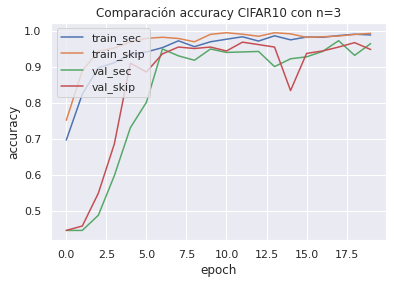

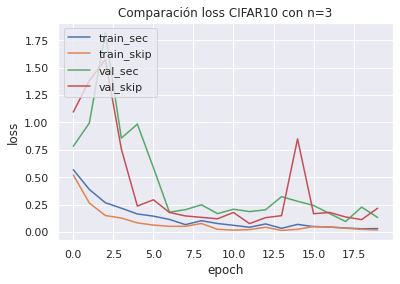

In [73]:
plt.plot(sec1_train_accu,label='train_sec')
plt.plot(skip1_train_accu,label='train_skip')
plt.plot(sec1_val_accu,label='val_sec')
plt.plot(skip1_val_accu,label='val_skip')
plt.title('Comparación accuracy CIFAR10 con n=3')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.show()


plt.plot(sec1_train_loss,label='train_sec')
plt.plot(skip1_train_loss,label='train_skip')
plt.plot(sec1_val_loss,label='val_sec')
plt.plot(skip1_val_loss,label='val_skip')
plt.title('Comparación loss CIFAR10 con n=3')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.show()

Dado que la red no es muy profunda no se aprecia la degradación de la red al no incluir skip connections.

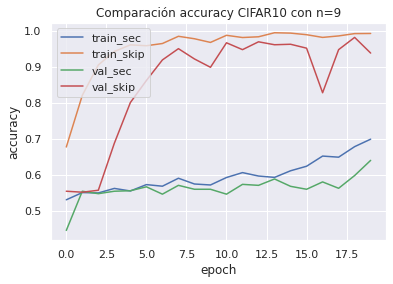

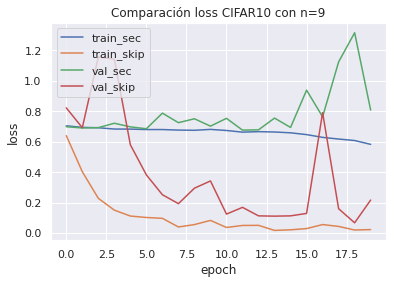

In [74]:
plt.plot(sec3_train_accu,label='train_sec')
plt.plot(skip3_train_accu,label='train_skip')
plt.plot(sec3_val_accu,label='val_sec')
plt.plot(skip3_val_accu,label='val_skip')
plt.title('Comparación accuracy CIFAR10 con n=9')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.show()


plt.plot(sec3_train_loss,label='train_sec')
plt.plot(skip3_train_loss,label='train_skip')
plt.plot(sec3_val_loss,label='val_sec')
plt.plot(skip3_val_loss,label='val_skip')
plt.title('Comparación loss CIFAR10 con n=9')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.show()

En esta gráfica se aprecia claramente el efecto que tiene el agregar skip connections a la red para mejorar el entrenamiento.

# Dataset Figuras Geométricas

## Procesamiento de imagenes

In [75]:
import pandas as pd
import numpy as np
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
#from sklearn.datasets import load_boston
import matplotlib.gridspec as gridspec


#Para trabajar sobre imagenes
import cv2
import random
import os
import matplotlib.image as mpimg
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split 
from sklearn.metrics import classification_report

#tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import MaxPooling2D, Dense, Dropout,Flatten, Conv2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import TensorBoard,EarlyStopping 

In [76]:
image_circ=path+'/shapes/circles/'
image_squa=path+'/shapes/squares/'
image_trian=path+'/shapes/triangles/'

In [109]:
#se dejaran las imagenes en RGB para que sean iguales a los de los dataset anteriores
def load_data() :
    X = []
    y = []
    

    for i in os.listdir(image_circ) :
        image_path = os.path.join(image_circ, i)
        img = cv2.imread(image_path,0)
        img = cv2.resize(img,(32,32),interpolation = cv2.INTER_AREA)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = img.reshape(32,32,3)
        img = img / 255.
        X.append(img)
        y.append([1,0,0])
    for i in os.listdir(image_squa) :
        image_path = os.path.join(image_squa, i)
        img = cv2.imread(image_path,0)
        img = cv2.resize(img,(32,32),interpolation = cv2.INTER_AREA)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = img.reshape(32,32,3)
        img = img / 255.
        X.append(img)
        y.append([0,1,0])
    for i in os.listdir(image_trian) :
        image_path = os.path.join(image_trian, i)
        img = cv2.imread(image_path,0)
        img = cv2.resize(img,(32,32),interpolation = cv2.INTER_AREA)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = img.reshape(32,32,3)
        img = img / 255.
        X.append(img)
        y.append([0,0,1])
    
    return np.asarray(X),np.asarray(y)

In [110]:
labels = ['Circle','Square','Triangle']
X,y = load_data()
X.shape,y.shape

((300, 32, 32, 3), (300, 3))

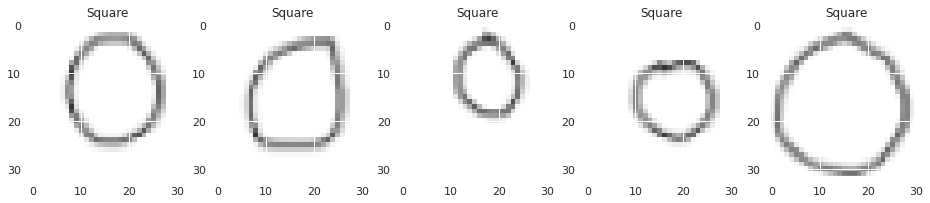

In [111]:
fig = plt.figure(figsize=(16, 16))
for i in range(5):
  img = X[i+20].reshape(32,32,3)
  ax = fig.add_subplot(1, 5,i+1)
  ax.title.set_text(labels[y[i+20][0]])
  plt.imshow(img,cmap='gray')

In [112]:
#definimos los conjuntos de entrenamiento y test
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.1)

#input = keras.Input(shape=(28,28,3,), name='MyInput')
#salida 3 neuronas, con capa softmax

## Arquitecturas

Model: "Brain_CNN"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
MyInput (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_921 (Conv2D)             (None, 32, 32, 16)   448         MyInput[0][0]                    
__________________________________________________________________________________________________
batch_normalization_923 (BatchN (None, 32, 32, 16)   64          conv2d_921[0][0]                 
__________________________________________________________________________________________________
conv2d_922 (Conv2D)             (None, 32, 32, 16)   2320        batch_normalization_923[0][0]    
__________________________________________________________________________________________

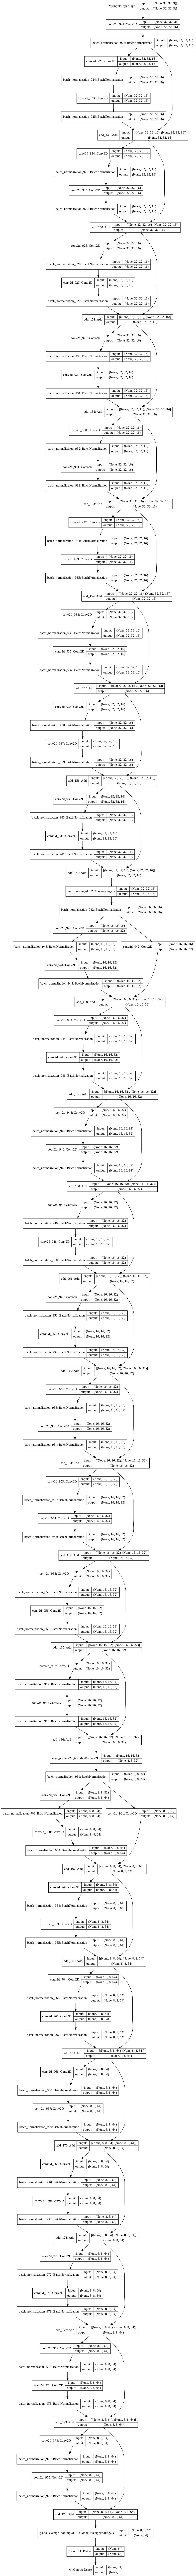

In [125]:
#modelos finales
from keras.layers import merge
# Without skip connections but with batch normalization

def get_model_CNN_sec1(activation_func,seed=1234):
  
    tf.random.set_seed(seed)
    input = keras.Input(shape=(32,32,3), name='MyInput')
    x0 = layers.Conv2D(filters = 16, kernel_size = 3, activation = activation_func, padding="same")(input) 
    bn0 = layers.BatchNormalization()(x0)
    x1 = layers.Conv2D(filters = 16, kernel_size = 3, activation = activation_func, padding="same")(bn0)  
    bn1 = layers.BatchNormalization()(x1)  
    x2 = layers.Conv2D(filters = 16, kernel_size = 3, activation = activation_func, padding="same")(bn1)
    bn2 = layers.BatchNormalization()(x2)    
    x3 = layers.Conv2D(filters = 16, kernel_size = 3, activation = activation_func, padding="same")(bn2)
    bn3 = layers.BatchNormalization()(x3) 
    x4 = layers.Conv2D(filters = 16, kernel_size = 3, activation = activation_func, padding="same")(bn3)
    bn4 = layers.BatchNormalization()(x4)  
    x5 = layers.Conv2D(filters = 16, kernel_size = 3, activation = activation_func, padding="same")(bn4)
    bn5 = layers.BatchNormalization()(x5) 
    x6 = layers.Conv2D(filters = 16, kernel_size = 3, activation = activation_func, padding="same")(bn5)
    bn6 = layers.BatchNormalization()(x6) 
    xp1 = layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid')(bn6) 
    bnp1 = layers.BatchNormalization()(xp1) 
    x7 = layers.Conv2D(filters = 32, kernel_size = 3, activation = activation_func, padding="same")(bnp1) 
    bn7 = layers.BatchNormalization()(x7)    
    x8 = layers.Conv2D(filters = 32, kernel_size = 3, activation = activation_func, padding="same")(bn7)
    bn8 = layers.BatchNormalization()(x8)  
    x9 = layers.Conv2D(filters = 32, kernel_size = 3, activation = activation_func, padding="same")(bn8)
    bn9 = layers.BatchNormalization()(x9)  
    x10 = layers.Conv2D(filters = 32, kernel_size = 3, activation = activation_func, padding="same")(bn9)
    bn10 = layers.BatchNormalization()(x10)  
    x11 = layers.Conv2D(filters = 32, kernel_size = 3, activation = activation_func, padding="same")(bn10)
    bn11 = layers.BatchNormalization()(x11)  
    x12 = layers.Conv2D(filters = 32, kernel_size = 3, activation = activation_func, padding="same")(bn11)
    bn12 = layers.BatchNormalization()(x12)  
    xp2 = layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid')(bn12) 
    bnp2 = layers.BatchNormalization()(xp2) 
    x13 = layers.Conv2D(filters = 64, kernel_size = 3, activation = activation_func, padding="same")(bnp2) 
    bn13 = layers.BatchNormalization()(x13)     
    x14 = layers.Conv2D(filters = 64, kernel_size = 3, activation = activation_func, padding="same")(bn13)
    bn14 = layers.BatchNormalization()(x14)  
    x15 = layers.Conv2D(filters = 64, kernel_size = 3, activation = activation_func, padding="same")(bn14)
    bn15 = layers.BatchNormalization()(x15)  
    x16 = layers.Conv2D(filters = 64, kernel_size = 3, activation = activation_func, padding="same")(bn15)
    bn16 = layers.BatchNormalization()(x16)  
    x17 = layers.Conv2D(filters = 64, kernel_size = 3, activation = activation_func, padding="same")(bn16)
    bn17 = layers.BatchNormalization()(x17)  
    x18 = layers.Conv2D(filters = 64, kernel_size = 3, activation = activation_func, padding="same")(bn17)
    bn18 = layers.BatchNormalization()(x18)  
    xp3 = layers.GlobalAveragePooling2D()(bn18)
    xfl = layers.Flatten()(xp3)
    output = layers.Dense(3, activation='softmax', name='MyOutput')(xfl)
    model = keras.Model(inputs=input, outputs=output, name='Brain_CNN')

    return model


def get_model_CNN_sec3(activation_func,seed=1234):#igual que sec3, pero con más profundidad
  
    tf.random.set_seed(seed)
    input = keras.Input(shape=(32,32,3,), name='MyInput')
    x0 = layers.Conv2D(filters = 16, kernel_size = 3, activation = activation_func, padding="same")(input) 
    bn = layers.BatchNormalization()(x0)
    x  = layers.Conv2D(filters = 16, kernel_size = 3, activation = activation_func, padding="same")(bn)  
    bn = layers.BatchNormalization()(x)  
    x  = layers.Conv2D(filters = 16, kernel_size = 3, activation = activation_func, padding="same")(bn)  
    bn = layers.BatchNormalization()(x) 
    x  = layers.Conv2D(filters = 16, kernel_size = 3, activation = activation_func, padding="same")(bn)  
    bn = layers.BatchNormalization()(x) 
    x  = layers.Conv2D(filters = 16, kernel_size = 3, activation = activation_func, padding="same")(bn)  
    bn = layers.BatchNormalization()(x) 
    x  = layers.Conv2D(filters = 16, kernel_size = 3, activation = activation_func, padding="same")(bn)  
    bn = layers.BatchNormalization()(x) 
    x  = layers.Conv2D(filters = 16, kernel_size = 3, activation = activation_func, padding="same")(bn)  
    bn = layers.BatchNormalization()(x) 
    x  = layers.Conv2D(filters = 16, kernel_size = 3, activation = activation_func, padding="same")(bn)  
    bn = layers.BatchNormalization()(x) 
    x  = layers.Conv2D(filters = 16, kernel_size = 3, activation = activation_func, padding="same")(bn)  
    bn = layers.BatchNormalization()(x) 
    x  = layers.Conv2D(filters = 16, kernel_size = 3, activation = activation_func, padding="same")(bn)  
    bn = layers.BatchNormalization()(x) 
    x  = layers.Conv2D(filters = 16, kernel_size = 3, activation = activation_func, padding="same")(bn)  
    bn = layers.BatchNormalization()(x) 
    x  = layers.Conv2D(filters = 16, kernel_size = 3, activation = activation_func, padding="same")(bn)  
    bn = layers.BatchNormalization()(x) 
    x  = layers.Conv2D(filters = 16, kernel_size = 3, activation = activation_func, padding="same")(bn)  
    bn = layers.BatchNormalization()(x) 
    x  = layers.Conv2D(filters = 16, kernel_size = 3, activation = activation_func, padding="same")(bn)  
    bn = layers.BatchNormalization()(x) 
    x  = layers.Conv2D(filters = 16, kernel_size = 3, activation = activation_func, padding="same")(bn)  
    bn = layers.BatchNormalization()(x) 
    x  = layers.Conv2D(filters = 16, kernel_size = 3, activation = activation_func, padding="same")(bn)  
    bn = layers.BatchNormalization()(x) 
    x  = layers.Conv2D(filters = 16, kernel_size = 3, activation = activation_func, padding="same")(bn)  
    bn = layers.BatchNormalization()(x) 
    x  = layers.Conv2D(filters = 16, kernel_size = 3, activation = activation_func, padding="same")(bn)  
    bn = layers.BatchNormalization()(x) 
    x  = layers.Conv2D(filters = 16, kernel_size = 3, activation = activation_func, padding="same")(bn)  
    bn = layers.BatchNormalization()(x)
    xp1 = layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid')(bn) 
    bnp1 = layers.BatchNormalization()(xp1)
    x  = layers.Conv2D(filters = 32, kernel_size = 3, activation = activation_func, padding="same")(bnp1)  
    bn = layers.BatchNormalization()(x)  
    x  = layers.Conv2D(filters = 32, kernel_size = 3, activation = activation_func, padding="same")(bn)  
    bn = layers.BatchNormalization()(x) 
    x  = layers.Conv2D(filters = 32, kernel_size = 3, activation = activation_func, padding="same")(bn)  
    bn = layers.BatchNormalization()(x) 
    x  = layers.Conv2D(filters = 32, kernel_size = 3, activation = activation_func, padding="same")(bn)  
    bn = layers.BatchNormalization()(x) 
    x  = layers.Conv2D(filters = 32, kernel_size = 3, activation = activation_func, padding="same")(bn)  
    bn = layers.BatchNormalization()(x) 
    x  = layers.Conv2D(filters = 32, kernel_size = 3, activation = activation_func, padding="same")(bn)  
    bn = layers.BatchNormalization()(x) 
    x  = layers.Conv2D(filters = 32, kernel_size = 3, activation = activation_func, padding="same")(bn)  
    bn = layers.BatchNormalization()(x) 
    x  = layers.Conv2D(filters = 32, kernel_size = 3, activation = activation_func, padding="same")(bn)  
    bn = layers.BatchNormalization()(x) 
    x  = layers.Conv2D(filters = 32, kernel_size = 3, activation = activation_func, padding="same")(bn)  
    bn = layers.BatchNormalization()(x) 
    x  = layers.Conv2D(filters = 32, kernel_size = 3, activation = activation_func, padding="same")(bn)  
    bn = layers.BatchNormalization()(x) 
    x  = layers.Conv2D(filters = 32, kernel_size = 3, activation = activation_func, padding="same")(bn)  
    bn = layers.BatchNormalization()(x) 
    x  = layers.Conv2D(filters = 32, kernel_size = 3, activation = activation_func, padding="same")(bn)  
    bn = layers.BatchNormalization()(x) 
    x  = layers.Conv2D(filters = 32, kernel_size = 3, activation = activation_func, padding="same")(bn)  
    bn = layers.BatchNormalization()(x) 
    x  = layers.Conv2D(filters = 32, kernel_size = 3, activation = activation_func, padding="same")(bn)  
    bn = layers.BatchNormalization()(x) 
    x  = layers.Conv2D(filters = 32, kernel_size = 3, activation = activation_func, padding="same")(bn)  
    bn = layers.BatchNormalization()(x) 
    x  = layers.Conv2D(filters = 32, kernel_size = 3, activation = activation_func, padding="same")(bn)  
    bn = layers.BatchNormalization()(x) 
    x  = layers.Conv2D(filters = 32, kernel_size = 3, activation = activation_func, padding="same")(bn)  
    bn = layers.BatchNormalization()(x) 
    x  = layers.Conv2D(filters = 32, kernel_size = 3, activation = activation_func, padding="same")(bn)  
    bn = layers.BatchNormalization()(x) 
    xp2 = layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid')(bn) 
    bnp2 = layers.BatchNormalization()(xp2)
    x  = layers.Conv2D(filters = 64, kernel_size = 3, activation = activation_func, padding="same")(bnp2)  
    bn = layers.BatchNormalization()(x)  
    x  = layers.Conv2D(filters = 64, kernel_size = 3, activation = activation_func, padding="same")(bn)  
    bn = layers.BatchNormalization()(x) 
    x  = layers.Conv2D(filters = 64, kernel_size = 3, activation = activation_func, padding="same")(bn)  
    bn = layers.BatchNormalization()(x) 
    x  = layers.Conv2D(filters = 64, kernel_size = 3, activation = activation_func, padding="same")(bn)  
    bn = layers.BatchNormalization()(x) 
    x  = layers.Conv2D(filters = 64, kernel_size = 3, activation = activation_func, padding="same")(bn)  
    bn = layers.BatchNormalization()(x) 
    x  = layers.Conv2D(filters = 64, kernel_size = 3, activation = activation_func, padding="same")(bn)  
    bn = layers.BatchNormalization()(x) 
    x  = layers.Conv2D(filters = 64, kernel_size = 3, activation = activation_func, padding="same")(bn)  
    bn = layers.BatchNormalization()(x) 
    x  = layers.Conv2D(filters = 64, kernel_size = 3, activation = activation_func, padding="same")(bn)  
    bn = layers.BatchNormalization()(x) 
    x  = layers.Conv2D(filters = 64, kernel_size = 3, activation = activation_func, padding="same")(bn)  
    bn = layers.BatchNormalization()(x) 
    x  = layers.Conv2D(filters = 64, kernel_size = 3, activation = activation_func, padding="same")(bn)  
    bn = layers.BatchNormalization()(x) 
    x  = layers.Conv2D(filters = 64, kernel_size = 3, activation = activation_func, padding="same")(bn)  
    bn = layers.BatchNormalization()(x) 
    x  = layers.Conv2D(filters = 64, kernel_size = 3, activation = activation_func, padding="same")(bn)  
    bn = layers.BatchNormalization()(x) 
    x  = layers.Conv2D(filters = 64, kernel_size = 3, activation = activation_func, padding="same")(bn)  
    bn = layers.BatchNormalization()(x) 
    x  = layers.Conv2D(filters = 64, kernel_size = 3, activation = activation_func, padding="same")(bn)  
    bn = layers.BatchNormalization()(x) 
    x  = layers.Conv2D(filters = 64, kernel_size = 3, activation = activation_func, padding="same")(bn)  
    bn = layers.BatchNormalization()(x) 
    x  = layers.Conv2D(filters = 64, kernel_size = 3, activation = activation_func, padding="same")(bn)  
    bn = layers.BatchNormalization()(x) 
    x  = layers.Conv2D(filters = 64, kernel_size = 3, activation = activation_func, padding="same")(bn)  
    bn = layers.BatchNormalization()(x) 
    x  = layers.Conv2D(filters = 64, kernel_size = 3, activation = activation_func, padding="same")(bn)  
    bn = layers.BatchNormalization()(x)
    xp3 = layers.GlobalAveragePooling2D()(bn)
    xfl = layers.Flatten()(xp3)
    output = layers.Dense(3, activation='softmax', name='MyOutput')(xfl)
    model = keras.Model(inputs=input, outputs=output, name='Brain_CNN')

    return model

# With skip connections

def get_model_CNN_skip1(activation_func,seed=1234): #with zero-padding shorcuts and projection shorctus, and batch normalization
  
    tf.random.set_seed(seed)
    input = keras.Input(shape=(32,32,3,), name='MyInput')
    x0 = layers.Conv2D(filters = 16, kernel_size = 3, activation = activation_func, padding="same")(input) 
    bn0 = layers.BatchNormalization()(x0)
    x1 = layers.Conv2D(filters = 16, kernel_size = 3, activation = activation_func, padding="same")(bn0)  
    bn1 = layers.BatchNormalization()(x1)  
    x2 = layers.Conv2D(filters = 16, kernel_size = 3, activation = activation_func, padding="same")(bn1)
    bn2 = layers.BatchNormalization()(x2) 
    block_1 = layers.add([bn0, bn2]) #zero-padding shorcut   
    x3 = layers.Conv2D(filters = 16, kernel_size = 3, activation = activation_func, padding="same")(block_1)
    bn3 = layers.BatchNormalization()(x3) 
    x4 = layers.Conv2D(filters = 16, kernel_size = 3, activation = activation_func, padding="same")(bn3)
    bn4 = layers.BatchNormalization()(x4) 
    block_2 = layers.add([block_1, bn4]) #zero-padding shorcut
    x5 = layers.Conv2D(filters = 16, kernel_size = 3, activation = activation_func, padding="same")(block_2)
    bn5 = layers.BatchNormalization()(x5) 
    x6 = layers.Conv2D(filters = 16, kernel_size = 3, activation = activation_func, padding="same")(bn5)
    bn6 = layers.BatchNormalization()(x6) 
    block_3 = layers.add([block_2, bn6]) #zero-padding shorcut 
    xp1 = layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid')(block_3) 
    bnp1 = layers.BatchNormalization()(xp1) 
    x7 = layers.Conv2D(filters = 32, kernel_size = 3, activation = activation_func, padding="same")(bnp1) 
    bn7 = layers.BatchNormalization()(x7)    
    x8 = layers.Conv2D(filters = 32, kernel_size = 3, activation = activation_func, padding="same")(bn7)
    bn8 = layers.BatchNormalization()(x8)  
    x1x1_1 = layers.Conv2D(filters = 32, kernel_size = 1, activation = activation_func)(bnp1)   
    block_ps1 = layers.add([x1x1_1, bn8]) #projection shorcut
    x9 = layers.Conv2D(filters = 32, kernel_size = 3, activation = activation_func, padding="same")(block_ps1)
    bn9 = layers.BatchNormalization()(x9)  
    x10 = layers.Conv2D(filters = 32, kernel_size = 3, activation = activation_func, padding="same")(bn9)
    bn10 = layers.BatchNormalization()(x10)  
    block_4 = layers.add([block_ps1, bn10]) #zero-padding shorcut
    x11 = layers.Conv2D(filters = 32, kernel_size = 3, activation = activation_func, padding="same")(block_4)
    bn11 = layers.BatchNormalization()(x11)  
    x12 = layers.Conv2D(filters = 32, kernel_size = 3, activation = activation_func, padding="same")(bn11)
    bn12 = layers.BatchNormalization()(x12)  
    block_5 = layers.add([block_4, bn12]) #zero-padding shorcut
    xp2 = layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid')(block_5) 
    bnp2 = layers.BatchNormalization()(xp2) 
    x13 = layers.Conv2D(filters = 64, kernel_size = 3, activation = activation_func, padding="same")(bnp2) 
    bn13 = layers.BatchNormalization()(x13)     
    x14 = layers.Conv2D(filters = 64, kernel_size = 3, activation = activation_func, padding="same")(bn13)
    bn14 = layers.BatchNormalization()(x14)  
    x1x1_2 = layers.Conv2D(filters = 64, kernel_size = 1, activation = activation_func)(bnp2)   
    block_ps2 = layers.add([x1x1_2, bn14]) #projection shorcut
    x15 = layers.Conv2D(filters = 64, kernel_size = 3, activation = activation_func, padding="same")(block_ps2)
    bn15 = layers.BatchNormalization()(x15)  
    x16 = layers.Conv2D(filters = 64, kernel_size = 3, activation = activation_func, padding="same")(bn15)
    bn16 = layers.BatchNormalization()(x16)  
    block_6 = layers.add([block_ps2, bn16]) #zero-padding shorcut
    x17 = layers.Conv2D(filters = 64, kernel_size = 3, activation = activation_func, padding="same")(block_6)
    bn17 = layers.BatchNormalization()(x17)  
    x18 = layers.Conv2D(filters = 64, kernel_size = 3, activation = activation_func, padding="same")(bn17)
    bn18 = layers.BatchNormalization()(x18)  
    block_7 = layers.add([block_6, bn18]) #zero-padding shorcut
    xp3 = layers.GlobalAveragePooling2D()(block_7)
    xfl = layers.Flatten()(xp3)
    output = layers.Dense(3, activation='softmax', name='MyOutput')(xfl)
    model = keras.Model(inputs=input, outputs=output, name='Brain_CNN')

    return model

def get_model_CNN_skip3(activation_func,seed=1234): ##with zero-padding shorcuts and projection shorctus, and batch normalization, but more layer than model skip3 with equal filters number 
  
    tf.random.set_seed(seed)
    input = keras.Input(shape=(32,32,3,), name='MyInput')
    x0 = layers.Conv2D(filters = 16, kernel_size = 3, activation = activation_func, padding="same")(input) 
    bn0 = layers.BatchNormalization()(x0)
    x1 = layers.Conv2D(filters = 16, kernel_size = 3, activation = activation_func, padding="same")(bn0)
    bn1 = layers.BatchNormalization()(x1)    
    x2 = layers.Conv2D(filters = 16, kernel_size = 3, activation = activation_func, padding="same")(bn1)
    bn2 = layers.BatchNormalization()(x2)
    block_1 = layers.add([bn0, bn2])      
    x3 = layers.Conv2D(filters = 16, kernel_size = 3, activation = activation_func, padding="same")(block_1)
    bn3 = layers.BatchNormalization()(x3)
    x4 = layers.Conv2D(filters = 16, kernel_size = 3, activation = activation_func, padding="same")(bn3)
    bn4 = layers.BatchNormalization()(x4)
    block_2 = layers.add([block_1, bn4])  
    x5 = layers.Conv2D(filters = 16, kernel_size = 3, activation = activation_func, padding="same")(block_2)
    bn5 = layers.BatchNormalization()(x5)
    x6 = layers.Conv2D(filters = 16, kernel_size = 3, activation = activation_func, padding="same")(bn5)
    bn6 = layers.BatchNormalization()(x6)
    block_3 = layers.add([block_2, bn6]) 
    x7 = layers.Conv2D(filters = 16, kernel_size = 3, activation = activation_func, padding="same")(block_3)
    bn7 = layers.BatchNormalization()(x7)
    x8 = layers.Conv2D(filters = 16, kernel_size = 3, activation = activation_func, padding="same")(bn7)
    bn8 = layers.BatchNormalization()(x8)
    block_4 = layers.add([block_3, bn8]) 
    x9 = layers.Conv2D(filters = 16, kernel_size = 3, activation = activation_func, padding="same")(block_4)
    bn9 = layers.BatchNormalization()(x9)
    x10 = layers.Conv2D(filters = 16, kernel_size = 3, activation = activation_func, padding="same")(bn9)
    bn10 = layers.BatchNormalization()(x10)
    block_5 = layers.add([block_4, bn10]) 
    x11 = layers.Conv2D(filters = 16, kernel_size = 3, activation = activation_func, padding="same")(block_5)
    bn11 = layers.BatchNormalization()(x11)    
    x12 = layers.Conv2D(filters = 16, kernel_size = 3, activation = activation_func, padding="same")(bn11)
    bn12 = layers.BatchNormalization()(x12)
    block_6 = layers.add([block_5, bn12])      
    x13 = layers.Conv2D(filters = 16, kernel_size = 3, activation = activation_func, padding="same")(block_6)
    bn13 = layers.BatchNormalization()(x13)
    x14 = layers.Conv2D(filters = 16, kernel_size = 3, activation = activation_func, padding="same")(bn13)
    bn14 = layers.BatchNormalization()(x14)
    block_7 = layers.add([block_6, bn14])  
    x15 = layers.Conv2D(filters = 16, kernel_size = 3, activation = activation_func, padding="same")(block_7)
    bn15 = layers.BatchNormalization()(x15)
    x16 = layers.Conv2D(filters = 16, kernel_size = 3, activation = activation_func, padding="same")(bn15)
    bn16 = layers.BatchNormalization()(x16)
    block_8 = layers.add([block_7, bn16]) 
    x17 = layers.Conv2D(filters = 16, kernel_size = 3, activation = activation_func, padding="same")(block_8)
    bn17 = layers.BatchNormalization()(x17)
    x18 = layers.Conv2D(filters = 16, kernel_size = 3, activation = activation_func, padding="same")(bn17)
    bn18 = layers.BatchNormalization()(x18)
    block_9 = layers.add([block_8, bn18]) 
    xp1 = layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid')(block_9) 
    bnp1 = layers.BatchNormalization()(xp1)
    x19 = layers.Conv2D(filters = 32, kernel_size = 3, activation = activation_func, padding="same")(bnp1) 
    bn19 = layers.BatchNormalization()(x19)   
    x20 = layers.Conv2D(filters = 32, kernel_size = 3, activation = activation_func, padding="same")(bn19)
    bn20 = layers.BatchNormalization()(x20)
    x1x1_1 = layers.Conv2D(filters = 32, kernel_size = 1, activation = activation_func)(bnp1)   
    block_ps1 = layers.add([x1x1_1, bn20]) 
    x21 = layers.Conv2D(filters = 32, kernel_size = 3, activation = activation_func, padding="same")(block_ps1)
    bn21 = layers.BatchNormalization()(x21)
    x22 = layers.Conv2D(filters = 32, kernel_size = 3, activation = activation_func, padding="same")(bn21)
    bn22 = layers.BatchNormalization()(x22)
    block_10 = layers.add([block_ps1, bn22])
    x23 = layers.Conv2D(filters = 32, kernel_size = 3, activation = activation_func, padding="same")(block_10)
    bn23 = layers.BatchNormalization()(x23)
    x24 = layers.Conv2D(filters = 32, kernel_size = 3, activation = activation_func, padding="same")(bn23)
    bn24 = layers.BatchNormalization()(x24)
    block_11 = layers.add([block_10, bn24])
    x25 = layers.Conv2D(filters = 32, kernel_size = 3, activation = activation_func, padding="same")(block_11)
    bn25 = layers.BatchNormalization()(x25)
    x26 = layers.Conv2D(filters = 32, kernel_size = 3, activation = activation_func, padding="same")(bn25)
    bn26 = layers.BatchNormalization()(x26)
    block_12 = layers.add([block_11, bn26])
    x27 = layers.Conv2D(filters = 32, kernel_size = 3, activation = activation_func, padding="same")(block_12)
    bn27 = layers.BatchNormalization()(x27)
    x28 = layers.Conv2D(filters = 32, kernel_size = 3, activation = activation_func, padding="same")(bn27)
    bn28 = layers.BatchNormalization()(x28)
    block_13 = layers.add([block_12, bn28])
    x29 = layers.Conv2D(filters = 32, kernel_size = 3, activation = activation_func, padding="same")(block_13)
    bn29 = layers.BatchNormalization()(x29)
    x30 = layers.Conv2D(filters = 32, kernel_size = 3, activation = activation_func, padding="same")(bn29)
    bn30 = layers.BatchNormalization()(x30)
    block_14 = layers.add([block_13, bn30])
    x31 = layers.Conv2D(filters = 32, kernel_size = 3, activation = activation_func, padding="same")(block_14)
    bn31 = layers.BatchNormalization()(x31)
    x32 = layers.Conv2D(filters = 32, kernel_size = 3, activation = activation_func, padding="same")(bn31)
    bn32 = layers.BatchNormalization()(x32)
    block_15 = layers.add([block_14, bn32])
    x33 = layers.Conv2D(filters = 32, kernel_size = 3, activation = activation_func, padding="same")(block_15)
    bn33 = layers.BatchNormalization()(x33)
    x34 = layers.Conv2D(filters = 32, kernel_size = 3, activation = activation_func, padding="same")(bn33)
    bn34 = layers.BatchNormalization()(x34)
    block_16 = layers.add([block_15, bn34])
    x35 = layers.Conv2D(filters = 32, kernel_size = 3, activation = activation_func, padding="same")(block_16)
    bn35 = layers.BatchNormalization()(x35)
    x36 = layers.Conv2D(filters = 32, kernel_size = 3, activation = activation_func, padding="same")(bn35)
    bn36 = layers.BatchNormalization()(x36)
    block_17 = layers.add([block_16, bn36])
    xp2 = layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid')(block_17) 
    bnp2 = layers.BatchNormalization()(xp2)
    x37 = layers.Conv2D(filters = 64, kernel_size = 3, activation = activation_func, padding="same")(bnp2)    
    bn37 = layers.BatchNormalization()(x37)
    x38 = layers.Conv2D(filters = 64, kernel_size = 3, activation = activation_func, padding="same")(bn37)
    bn38 = layers.BatchNormalization()(x38)
    x1x1_2 = layers.Conv2D(filters = 64, kernel_size = 1, activation = activation_func)(bnp2)   
    block_ps2 = layers.add([x1x1_2, bn38]) 
    x39 = layers.Conv2D(filters = 64, kernel_size = 3, activation = activation_func, padding="same")(block_ps2)
    bn39 = layers.BatchNormalization()(x39)
    x40 = layers.Conv2D(filters = 64, kernel_size = 3, activation = activation_func, padding="same")(bn39)
    bn40 = layers.BatchNormalization()(x40)
    block_18 = layers.add([block_ps2, bn40])
    x41 = layers.Conv2D(filters = 64, kernel_size = 3, activation = activation_func, padding="same")(block_18)
    bn41 = layers.BatchNormalization()(x41)
    x42 = layers.Conv2D(filters = 64, kernel_size = 3, activation = activation_func, padding="same")(bn41)
    bn42 = layers.BatchNormalization()(x42)
    block_19 = layers.add([block_18, bn42])
    x43 = layers.Conv2D(filters = 64, kernel_size = 3, activation = activation_func, padding="same")(block_19)
    bn43 = layers.BatchNormalization()(x43)
    x44 = layers.Conv2D(filters = 64, kernel_size = 3, activation = activation_func, padding="same")(bn43)
    bn44 = layers.BatchNormalization()(x44)
    block_20 = layers.add([block_19, bn44])
    x45 = layers.Conv2D(filters = 64, kernel_size = 3, activation = activation_func, padding="same")(block_20)
    bn45 = layers.BatchNormalization()(x45)
    x46 = layers.Conv2D(filters = 64, kernel_size = 3, activation = activation_func, padding="same")(bn45)
    bn46 = layers.BatchNormalization()(x46)
    block_21 = layers.add([block_20, bn46])
    x47 = layers.Conv2D(filters = 64, kernel_size = 3, activation = activation_func, padding="same")(block_21)
    bn47 = layers.BatchNormalization()(x47)
    x48 = layers.Conv2D(filters = 64, kernel_size = 3, activation = activation_func, padding="same")(bn47)
    bn48 = layers.BatchNormalization()(x48)
    block_22 = layers.add([block_21, bn48])
    x49 = layers.Conv2D(filters = 64, kernel_size = 3, activation = activation_func, padding="same")(block_22)
    bn49 = layers.BatchNormalization()(x49)
    x50 = layers.Conv2D(filters = 64, kernel_size = 3, activation = activation_func, padding="same")(bn49)
    bn50 = layers.BatchNormalization()(x50)
    block_23 = layers.add([block_22, bn50])
    x51 = layers.Conv2D(filters = 64, kernel_size = 3, activation = activation_func, padding="same")(block_23)
    bn51 = layers.BatchNormalization()(x51)
    x52 = layers.Conv2D(filters = 64, kernel_size = 3, activation = activation_func, padding="same")(bn51)
    bn52 = layers.BatchNormalization()(x52)
    block_24 = layers.add([block_23, bn52])
    xp3 = layers.GlobalAveragePooling2D()(block_24)
    xfl = layers.Flatten()(xp3)
    output = layers.Dense(3, activation='softmax', name='MyOutput')(xfl)
    model = keras.Model(inputs=input, outputs=output, name='Brain_CNN')

    return model

model2 = get_model_CNN_skip3('relu')

model2.summary()

keras.utils.plot_model(model2, show_shapes=True)

## Resultados

### CNN sec1

In [117]:
# CNN sec1
_batch_size = 32

model2.compile( loss='categorical_crossentropy', optimizer = keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])

# Entrenar modelo
history = model2.fit(
    x = X_train,
    y = y_train,
    batch_size=_batch_size,
    epochs=20,
    verbose=1,

    
)

sec1_train_accu = history.history['accuracy']
#sec1_val_accu = history.history['val_accuracy']
sec1_train_loss = history.history['loss']
#sec1_val_loss = history.history['val_loss']

Epoch 1/20
9/9 [==============================] - 2s 16ms/step - loss: 0.0716 - accuracy: 0.9667
Epoch 2/20
9/9 [==============================] - 0s 15ms/step - loss: 0.1034 - accuracy: 0.9704
Epoch 3/20
9/9 [==============================] - 0s 13ms/step - loss: 0.0277 - accuracy: 0.9926
Epoch 4/20
9/9 [==============================] - 0s 12ms/step - loss: 0.0177 - accuracy: 0.9963
Epoch 5/20
9/9 [==============================] - 0s 12ms/step - loss: 0.0133 - accuracy: 1.0000
Epoch 6/20
9/9 [==============================] - 0s 11ms/step - loss: 0.0092 - accuracy: 1.0000
Epoch 7/20
9/9 [==============================] - 0s 12ms/step - loss: 0.0062 - accuracy: 1.0000
Epoch 8/20
9/9 [==============================] - 0s 11ms/step - loss: 0.0066 - accuracy: 1.0000
Epoch 9/20
9/9 [==============================] - 0s 11ms/step - loss: 0.0029 - accuracy: 1.0000
Epoch 10/20
9/9 [==============================] - 0s 11ms/step - loss: 0.0880 - accuracy: 0.9704
Epoch 11/20
9/9 [============

In [102]:
X_train.shape

(270, 32, 32, 3)

In [103]:
y_train.shape

(270, 1)

### CNN sec3

In [122]:
# CNN sec3
_batch_size = 32

model2.compile( loss='categorical_crossentropy', optimizer = keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])

# Entrenar modelo
history = model2.fit(
    x = X_train,
    y = y_train,
    batch_size=_batch_size,
    epochs=20,
    verbose=1,

  
)

sec3_train_accu = history.history['accuracy']
#sec3_val_accu = history.history['val_accuracy']
sec3_train_loss = history.history['loss']
#sec3_val_loss = history.history['val_loss']


Epoch 1/20
9/9 [==============================] - 5s 35ms/step - loss: 1.1276 - accuracy: 0.3259
Epoch 2/20
9/9 [==============================] - 0s 28ms/step - loss: 1.1326 - accuracy: 0.3630
Epoch 3/20
9/9 [==============================] - 0s 28ms/step - loss: 1.1182 - accuracy: 0.3556
Epoch 4/20
9/9 [==============================] - 0s 27ms/step - loss: 1.1191 - accuracy: 0.3593
Epoch 5/20
9/9 [==============================] - 0s 28ms/step - loss: 1.1056 - accuracy: 0.3481
Epoch 6/20
9/9 [==============================] - 0s 28ms/step - loss: 1.1336 - accuracy: 0.3630
Epoch 7/20
9/9 [==============================] - 0s 28ms/step - loss: 1.0953 - accuracy: 0.3630
Epoch 8/20
9/9 [==============================] - 0s 27ms/step - loss: 1.1252 - accuracy: 0.3556
Epoch 9/20
9/9 [==============================] - 0s 27ms/step - loss: 1.1245 - accuracy: 0.3593
Epoch 10/20
9/9 [==============================] - 0s 29ms/step - loss: 1.0853 - accuracy: 0.4074
Epoch 11/20
9/9 [============

### CNN skip1

In [124]:
# CNN skip1 
_batch_size = 32

model2.compile( loss='categorical_crossentropy', optimizer = keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])

# Entrenar modelo
history = model2.fit(
    x = X_train,
    y = y_train,
    batch_size=_batch_size,
    epochs=20,
    verbose=1,

    
)

skip1_train_accu = history.history['accuracy']
#skip1_val_accu = history.history['val_accuracy']
skip1_train_loss = history.history['loss']
#skip1_val_loss = history.history['val_loss']


Epoch 1/20
9/9 [==============================] - 2s 25ms/step - loss: 0.7677 - accuracy: 0.6370
Epoch 2/20
9/9 [==============================] - 0s 16ms/step - loss: 0.3007 - accuracy: 0.9000
Epoch 3/20
9/9 [==============================] - 0s 13ms/step - loss: 0.1048 - accuracy: 0.9630
Epoch 4/20
9/9 [==============================] - 0s 12ms/step - loss: 0.0621 - accuracy: 0.9704
Epoch 5/20
9/9 [==============================] - 0s 13ms/step - loss: 0.0629 - accuracy: 0.9778
Epoch 6/20
9/9 [==============================] - 0s 12ms/step - loss: 0.0718 - accuracy: 0.9704
Epoch 7/20
9/9 [==============================] - 0s 13ms/step - loss: 0.0373 - accuracy: 0.9815
Epoch 8/20
9/9 [==============================] - 0s 13ms/step - loss: 0.1013 - accuracy: 0.9593
Epoch 9/20
9/9 [==============================] - 0s 13ms/step - loss: 0.0583 - accuracy: 0.9778
Epoch 10/20
9/9 [==============================] - 0s 12ms/step - loss: 0.0429 - accuracy: 0.9926
Epoch 11/20
9/9 [============

### CNN skip3

In [126]:
# CNN skip3
_batch_size = 32

model2.compile( loss='categorical_crossentropy', optimizer = keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])

# Entrenar modelo
history = model2.fit(
    x = X_train,
    y = y_train,
    batch_size=_batch_size,
    epochs=20,
    verbose=1,

    
)

skip3_train_accu = history.history['accuracy']
#skip3_val_accu = history.history['val_accuracy']
skip3_train_loss = history.history['loss']
#skip3_val_loss = history.history['val_loss']

Epoch 1/20
9/9 [==============================] - 6s 35ms/step - loss: 1.3810 - accuracy: 0.4556
Epoch 2/20
9/9 [==============================] - 0s 29ms/step - loss: 0.7906 - accuracy: 0.6519
Epoch 3/20
9/9 [==============================] - 0s 27ms/step - loss: 0.4579 - accuracy: 0.8407
Epoch 4/20
9/9 [==============================] - 0s 27ms/step - loss: 0.2635 - accuracy: 0.8963
Epoch 5/20
9/9 [==============================] - 0s 28ms/step - loss: 0.2151 - accuracy: 0.9259
Epoch 6/20
9/9 [==============================] - 0s 28ms/step - loss: 0.1268 - accuracy: 0.9556
Epoch 7/20
9/9 [==============================] - 0s 27ms/step - loss: 0.0581 - accuracy: 0.9741
Epoch 8/20
9/9 [==============================] - 0s 28ms/step - loss: 0.0655 - accuracy: 0.9667
Epoch 9/20
9/9 [==============================] - 0s 28ms/step - loss: 0.0861 - accuracy: 0.9741
Epoch 10/20
9/9 [==============================] - 0s 28ms/step - loss: 0.0337 - accuracy: 0.9926
Epoch 11/20
9/9 [============

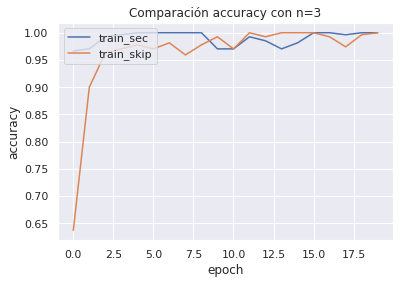

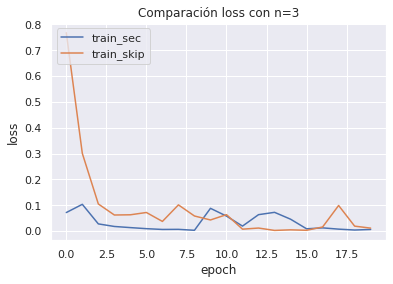

In [127]:
plt.plot(sec1_train_accu,label='train_sec')
plt.plot(skip1_train_accu,label='train_skip')
#plt.plot(sec1_val_accu,label='val_sec')
#plt.plot(skip1_val_accu,label='val_skip')
plt.title('Comparación accuracy con n=3')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.show()


plt.plot(sec1_train_loss,label='train_sec')
plt.plot(skip1_train_loss,label='train_skip')
#plt.plot(sec1_val_loss,label='val_sec')
#plt.plot(skip1_val_loss,label='val_skip')
plt.title('Comparación loss con n=3')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.show()

Dado que la red no es muy profunda no se aprecia la degradación de la red al no incluir skip connections.

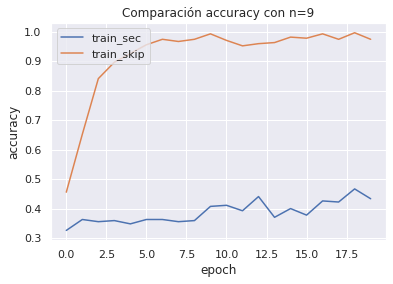

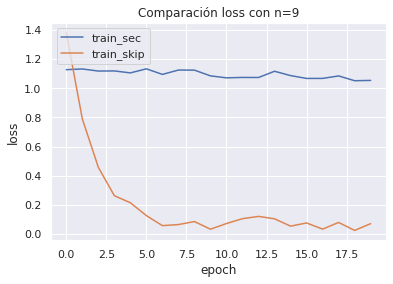

In [128]:
plt.plot(sec3_train_accu,label='train_sec')
plt.plot(skip3_train_accu,label='train_skip')
#plt.plot(sec3_val_accu,label='val_sec')
#plt.plot(skip3_val_accu,label='val_skip')
plt.title('Comparación accuracy con n=9')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.show()


plt.plot(sec3_train_loss,label='train_sec')
plt.plot(skip3_train_loss,label='train_skip')
#plt.plot(sec3_val_loss,label='val_sec')
#plt.plot(skip3_val_loss,label='val_skip')
plt.title('Comparación loss con n=9')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.show()

En esta gráfica se aprecia claramente el efecto que tiene el agregar skip connections a la red para mejorar el entrenamiento.

# Conclusiones

Se realizaron pruebas experimentales con distintos datasets, para redes donde se fue aumentando la profundidad, donde no se incluía skip connections y en otras si se incluía skip connections.
Se puede concluir de este trabajo que el utilizar skip connections en redes lo suficientemente profundas mejora el entrenamiento de la red, por lo que se espera tenga un mejor desempeño en la tarea de interés, de esta forma podemos validar la hipótesis planteada para este trabajo de investigación.